In [1]:
#Import needed packages
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
#Loads 201 CSV files into a dataframe.
path="C:/Users/predi/Documents/GitHub/DSC680/Assignments/Project 1/Datasets"
csv_files = glob.glob(path + "/*.csv")
raw_df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))

In [3]:
#Lower cases all headers and removes any white space from them.
raw_df.columns=raw_df.columns.str.lower()
raw_df.columns=raw_df.columns.str.strip()
#Creates a list of all column names in the dataframe
raw_df.columns

Index(['id', 'timestamp', '/es', '/nq', '/rty', 'spy', 'qqq', 'iwm', 'aapl',
       'msft', 'nvda', 'xlk', 'xlf', 'xlp', 'xly', 'xtn', 'hyg', 'db_col_16',
       'db_col_17', '/es volume', 'tlt', 'tlt volume', '***', '****',
       '/es sma20', '/es sma50', '35', '2020-12-27 17:59:09.000', '3692.75',
       '12703', '2001.8', '369', '309.56', '199.01', '131.97', '222.75',
       '519.75', '129.06', '28.95', '66.72', '157.88', '71.3937', '87.05', '0',
       '0.1', '0.2', '157.29', '3117104', '145462', '2021-01-03 17:59:08.000',
       '3748.75', '12883', '1978.3', '373.88', '313.74', '196.06', '132.69',
       '222.42', '522.2', '130.02', '29.48', '67.45', '160.78', '71.37',
       '87.3', '157.73', '7742413', '290744', '2021-01-10 17:59:08.000',
       '3822', '13123.25', '2092.1', '381.26', '319.03', '207.72', '132.05',
       '219.62', '531.07', '130.76', '30.92', '66.9', '168.79', '73.3652',
       '87.37', '151.32', '1.362282e+07', 'tnx', 'tyx', 'vix', 'spx',
       'spx pcr', 'sp

In [4]:
#Drops all columns but the three that are related to the S&P 500 future contracts.
drop_list=['id', '/nq', '/rty', 'spy', 'qqq', 'iwm', 'aapl','msft', 
           'nvda', 'xlk', 'xlf', 'xlp', 'xly', 'xtn', 'hyg', 'db_col_16',
           'db_col_17','tlt', 'tlt volume', '***', '****','35', 
           '2020-12-27 17:59:09.000', '3692.75','12703', '2001.8', '369',
           '309.56', '199.01', '131.97', '222.75','519.75', '129.06', '28.95', 
           '66.72', '157.88', '71.3937', '87.05', '0','0.1', '0.2', '157.29', 
           '3117104', '145462', '2021-01-03 17:59:08.000','3748.75', '12883', 
           '1978.3', '373.88', '313.74', '196.06', '132.69','222.42', '522.2', 
           '130.02', '29.48', '67.45', '160.78', '71.37','87.3', '157.73', 
           '7742413', '290744', '2021-01-10 17:59:08.000','3822', '13123.25',
           '2092.1', '381.26', '319.03', '207.72', '132.05','219.62', '531.07', 
           '130.76', '30.92', '66.9', '168.79', '73.3652','87.37', '151.32', 
           '1.362282e+07', 'tnx', 'tyx', 'vix', 'spx','spx pcr', 'spy pcr',
           '/es sma20','/es sma50','/es pcr']
dropped_df = raw_df.drop(columns=drop_list)
#Shows striped down dataframe
dropped_df.sample(10)

,timestamp,/es,/es volume
101342,2020-10-22 06:34:11.000,3436.50,2.0
110747,2023-04-06 14:26:26.000,4133.00,0.0
3590,2021-11-28 20:58:48.000,4637.75,82.0
123178,2023-03-24 00:48:24.000,3982.00,10.0
123993,2021-02-05 01:34:23.000,3877.50,6.0
62878,2021-04-27 22:23:09.000,4184.75,10.0
140614,2023-08-18 15:33:13.000,4381.25,155.0
83533,2021-03-10 15:47:06.000,3903.50,133.0
138768,2022-12-16 13:49:35.000,3865.50,127.0
14752,2023-02-13 06:18:07.000,4102.75,0.0


In [5]:
#Creates five minute candle sticks out of the 3 second observations.
dropped_df['timestamp'] = pd.to_datetime(dropped_df['timestamp'])
new_df = dropped_df.groupby(pd.Grouper(key='timestamp', freq='5T')).agg({
    'timestamp': 'last',
    '/es': ['max', 'min', 'last'],
    '/es volume': 'sum'})
# Flattens multi-level columns, resets index, and renames
new_df.columns = [f'{col[0]}_{col[1]}' for col in new_df.columns]
new_df.reset_index(drop=True, inplace=True)
new_df.rename(columns={'timestamp_last': 'last_timestamp', 
                       '/es_max': 'max_es', '/es_min': 'min_es', '/es_last': 'last_es', 
                       'es volume_sum': 'total_volume'}, inplace=True)
#Rounds the time stamps to the nearest minute
new_df['last_timestamp'] = pd.to_datetime(new_df['last_timestamp']).dt.round('T')
new_df.set_index('last_timestamp', inplace=True)
#Drops NaN rows created by Grouper for the weekends
new_df.dropna(axis=0,inplace=True)

In [6]:
#Creates simple moving averages columns for multiple period lengths
new_df['ma_10'] = new_df['last_es'].rolling(window=10).mean()
new_df['ma_20'] = new_df['last_es'].rolling(window=20).mean()
new_df['ma_50'] = new_df['last_es'].rolling(window=50).mean()
new_df['ma_100'] = new_df['last_es'].rolling(window=100).mean()
new_df['ma_200'] = new_df['last_es'].rolling(window=200).mean()

#Creates upper and lower Bollinger Bands columns
new_df['std'] = new_df['last_es'].rolling(window=20).std()
new_df['bb_upper'] = new_df['ma_20'] + (2 * new_df['std'])
new_df['bb_lower'] = new_df['ma_20'] - (2 * new_df['std'])
#Drops columns created for calulations
new_df.drop(columns=['std'], inplace=True)

In [7]:
#Calculate the 12-day and 26-day EMAs, to be used in MACD calulation
new_df['ema_12'] = new_df['last_es'].ewm(span=12, adjust=False).mean()
new_df['ema_26'] = new_df['last_es'].ewm(span=26, adjust=False).mean()
#Calculates the MACD 
new_df['macd_rough'] = new_df['ema_12'] - new_df['ema_26']
new_df['macd'] = new_df['macd_rough'].ewm(span=9, adjust=False).mean()
#Drops columns created for calulations
new_df.drop(columns=['macd_rough'], inplace=True)

In [8]:
#Calculates the Stochastic Oscillator
new_df['l14'] = new_df['min_es'].rolling(window=14).min()
new_df['h14'] = new_df['max_es'].rolling(window=14).max()
new_df['k'] =((new_df['last_es'] - new_df['l14']) / (new_df['h14'] - new_df['l14'])) * 100
new_df['stochastic'] = new_df['k'].rolling(window=3).mean()
#Drops columns created for calulations
new_df.drop(columns=['l14','h14','k'], inplace=True)

In [9]:
#Calulates Fibonacci retracements over 60 minutes
retracement_levels = [0.236, 0.382, 0.500, 0.618, 0.786]
new_df['price_range'] = new_df['last_es'].rolling(window=12).max() - new_df[
    'last_es'].rolling(window=12).min()

for level in retracement_levels:
    new_df[f'fibonacci_{int(level * 100)}%'] = new_df[
        'last_es'].rolling(window=12).max() - new_df['price_range'] * level

#Drops columns created for calulations
new_df.drop(columns=['price_range'], inplace=True)

In [10]:
#Calulates VWAP on a rolling 60 minute window
new_df['tpv'] = ((new_df['min_es']+new_df['last_es']+new_df[
    'max_es'])/3)*new_df['/es volume_sum']
new_df['vwap'] = (new_df['tpv'].rolling(window=12).sum()) / (new_df[
    '/es volume_sum'].rolling(window=12).sum())

#Drops columns created for calulations
new_df.drop(columns=['tpv'], inplace=True)

#Drops rows with NaN values
new_df.dropna(inplace=True)

In [11]:
#calulates the max difference in price for the next 5 minutes 
new_df['price_movement'] = new_df['max_es'].shift(-1) - new_df['last_es']
#drops the two max and min outliers created by the calculation
new_df.drop(new_df['price_movement'].idxmax(), inplace=True)
new_df.drop(new_df['price_movement'].idxmin(), inplace=True)

#Creates boolean if there was atleats a 2 point increase during the period
new_df['2+price_movement'] = (new_df['price_movement'] >= 2).astype(int)

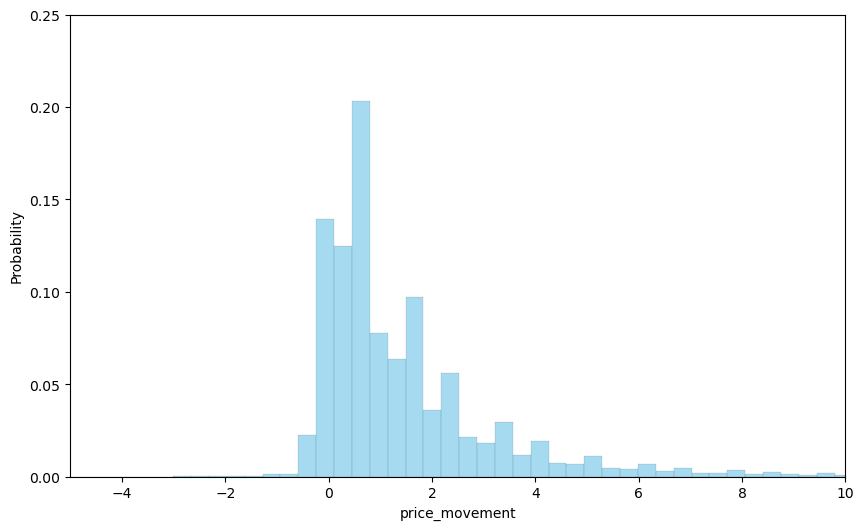

In [12]:
#creates a distbution graph of the prive movements.
plt.figure(figsize=(10,6))
sns.histplot(data=new_df["price_movement"], stat="probability", color='skyblue', edgecolor='black', bins=800)
plt.ylim(0, 0.25)
plt.xlim(-5,10)
plt.show()

In [13]:
#Creates a copy of the df to use for the MI
mi_x = new_df.copy()
mi_x.drop(columns="price_movement",inplace=True)
mi_y = mi_x.pop("2+price_movement")

#Label encoding for categoricals
for colname in mi_x.select_dtypes("object"):
    mi_x[colname], _ = mi_x[colname].factorize()

#All discrete features should now have integer dtypes
discrete_features = mi_x.dtypes == int

In [14]:
#Creates a function to calculate the MI scores
def make_mi_scores(mi_x, mi_y, discrete_features):
    mi_scores = mutual_info_regression(mi_x, mi_y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=mi_x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(mi_x, mi_y, discrete_features)

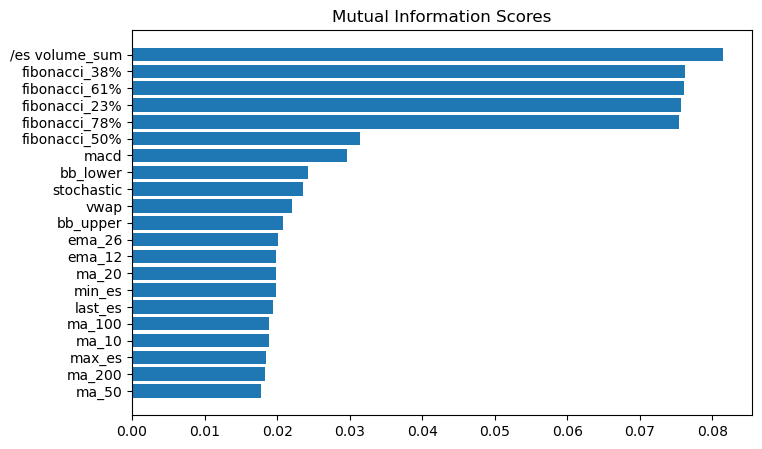

In [15]:
#Creates a function to graph the MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [16]:
#Splits the data into x and y datasets
x=new_df.drop(columns=['price_movement','2+price_movement'])
y=new_df['2+price_movement']

#Splits the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [17]:
#Logistic regression parameters
logistic_params = {'penalty': ['l1', 'l2'],
                   'C': np.logspace(-4, 4, 20),
                   'max_iter': [500,1000,1500]}

#Logistic regression grid search
logistic_model = LogisticRegression()
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5)
logistic_grid.fit(x_train, y_train)

C:\Users\predi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\predi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\predi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\predi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
Va

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [500, 1000, 1500],
                         'penalty': ['l1', 'l2']})

In [18]:
#XGBoost parameters
xgb_params = {'learning_rate': [0.1, 0.2],
              'n_estimators': [100, 250, 500],
              'max_depth': [3, 5, 6],}

#XGBoost grid search
xgb_model = XGBClassifier()
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5)
xgb_grid.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5, 6],
                         'n_estimators': [100, 250, 500]})

In [19]:
#CatBoost parameters
catboost_params = {'learning_rate': [0.1, 0.2],
                   'iterations': [100, 250, 500],
                   'depth': [3, 5, 6],}

#CatBoost grid search
catboost_model = CatBoostClassifier()
catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5)
catboost_grid.fit(x_train, y_train)

0:	learn: 0.6550075	total: 205ms	remaining: 20.3s
1:	learn: 0.6236608	total: 230ms	remaining: 11.3s
2:	learn: 0.5978040	total: 244ms	remaining: 7.89s
3:	learn: 0.5788910	total: 257ms	remaining: 6.16s
4:	learn: 0.5645031	total: 269ms	remaining: 5.11s
5:	learn: 0.5507640	total: 282ms	remaining: 4.41s
6:	learn: 0.5406088	total: 295ms	remaining: 3.91s
7:	learn: 0.5320950	total: 307ms	remaining: 3.53s
8:	learn: 0.5249212	total: 320ms	remaining: 3.23s
9:	learn: 0.5205271	total: 332ms	remaining: 2.99s
10:	learn: 0.5165271	total: 345ms	remaining: 2.79s
11:	learn: 0.5128857	total: 358ms	remaining: 2.62s
12:	learn: 0.5093870	total: 370ms	remaining: 2.48s
13:	learn: 0.5070727	total: 384ms	remaining: 2.36s
14:	learn: 0.5050877	total: 398ms	remaining: 2.25s
15:	learn: 0.5037497	total: 410ms	remaining: 2.15s
16:	learn: 0.5020441	total: 423ms	remaining: 2.06s
17:	learn: 0.5010545	total: 436ms	remaining: 1.99s
18:	learn: 0.4996412	total: 449ms	remaining: 1.91s
19:	learn: 0.4986087	total: 461ms	remaini

72:	learn: 0.4897391	total: 1.26s	remaining: 466ms
73:	learn: 0.4897045	total: 1.28s	remaining: 448ms
74:	learn: 0.4896587	total: 1.29s	remaining: 431ms
75:	learn: 0.4896123	total: 1.31s	remaining: 414ms
76:	learn: 0.4895690	total: 1.33s	remaining: 397ms
77:	learn: 0.4895153	total: 1.34s	remaining: 379ms
78:	learn: 0.4894848	total: 1.36s	remaining: 362ms
79:	learn: 0.4894324	total: 1.38s	remaining: 345ms
80:	learn: 0.4893839	total: 1.4s	remaining: 328ms
81:	learn: 0.4893204	total: 1.42s	remaining: 311ms
82:	learn: 0.4893017	total: 1.43s	remaining: 293ms
83:	learn: 0.4892838	total: 1.45s	remaining: 276ms
84:	learn: 0.4892382	total: 1.47s	remaining: 259ms
85:	learn: 0.4891964	total: 1.48s	remaining: 241ms
86:	learn: 0.4891585	total: 1.5s	remaining: 224ms
87:	learn: 0.4891190	total: 1.51s	remaining: 207ms
88:	learn: 0.4890926	total: 1.53s	remaining: 189ms
89:	learn: 0.4890609	total: 1.55s	remaining: 172ms
90:	learn: 0.4890210	total: 1.57s	remaining: 155ms
91:	learn: 0.4889850	total: 1.58s

47:	learn: 0.4912406	total: 624ms	remaining: 676ms
48:	learn: 0.4911226	total: 638ms	remaining: 664ms
49:	learn: 0.4910509	total: 649ms	remaining: 649ms
50:	learn: 0.4909470	total: 663ms	remaining: 637ms
51:	learn: 0.4908670	total: 675ms	remaining: 623ms
52:	learn: 0.4906978	total: 688ms	remaining: 610ms
53:	learn: 0.4906319	total: 702ms	remaining: 598ms
54:	learn: 0.4905676	total: 715ms	remaining: 585ms
55:	learn: 0.4905374	total: 726ms	remaining: 570ms
56:	learn: 0.4904681	total: 739ms	remaining: 557ms
57:	learn: 0.4903951	total: 751ms	remaining: 544ms
58:	learn: 0.4903400	total: 763ms	remaining: 530ms
59:	learn: 0.4902618	total: 776ms	remaining: 517ms
60:	learn: 0.4902251	total: 788ms	remaining: 504ms
61:	learn: 0.4901487	total: 800ms	remaining: 491ms
62:	learn: 0.4900786	total: 813ms	remaining: 478ms
63:	learn: 0.4899607	total: 827ms	remaining: 465ms
64:	learn: 0.4899138	total: 838ms	remaining: 451ms
65:	learn: 0.4898050	total: 853ms	remaining: 439ms
66:	learn: 0.4897631	total: 865

15:	learn: 0.4933370	total: 212ms	remaining: 1.11s
16:	learn: 0.4926960	total: 229ms	remaining: 1.12s
17:	learn: 0.4923494	total: 244ms	remaining: 1.11s
18:	learn: 0.4919924	total: 259ms	remaining: 1.1s
19:	learn: 0.4915030	total: 273ms	remaining: 1.09s
20:	learn: 0.4913269	total: 284ms	remaining: 1.07s
21:	learn: 0.4911153	total: 296ms	remaining: 1.05s
22:	learn: 0.4908824	total: 308ms	remaining: 1.03s
23:	learn: 0.4907770	total: 320ms	remaining: 1.01s
24:	learn: 0.4904816	total: 332ms	remaining: 996ms
25:	learn: 0.4902863	total: 346ms	remaining: 984ms
26:	learn: 0.4900845	total: 358ms	remaining: 968ms
27:	learn: 0.4899605	total: 370ms	remaining: 951ms
28:	learn: 0.4898665	total: 382ms	remaining: 935ms
29:	learn: 0.4897450	total: 393ms	remaining: 918ms
30:	learn: 0.4896564	total: 405ms	remaining: 902ms
31:	learn: 0.4895264	total: 418ms	remaining: 888ms
32:	learn: 0.4894689	total: 430ms	remaining: 873ms
33:	learn: 0.4893607	total: 444ms	remaining: 861ms
34:	learn: 0.4891162	total: 456m

91:	learn: 0.4868024	total: 1.22s	remaining: 106ms
92:	learn: 0.4867363	total: 1.23s	remaining: 92.9ms
93:	learn: 0.4866924	total: 1.25s	remaining: 79.6ms
94:	learn: 0.4865363	total: 1.26s	remaining: 66.3ms
95:	learn: 0.4864999	total: 1.27s	remaining: 53ms
96:	learn: 0.4864757	total: 1.28s	remaining: 39.7ms
97:	learn: 0.4864502	total: 1.29s	remaining: 26.4ms
98:	learn: 0.4863853	total: 1.31s	remaining: 13.2ms
99:	learn: 0.4863223	total: 1.32s	remaining: 0us
0:	learn: 0.6224884	total: 14.5ms	remaining: 1.44s
1:	learn: 0.5763832	total: 27.3ms	remaining: 1.34s
2:	learn: 0.5460091	total: 40.6ms	remaining: 1.31s
3:	learn: 0.5296804	total: 54ms	remaining: 1.3s
4:	learn: 0.5174606	total: 67.5ms	remaining: 1.28s
5:	learn: 0.5092698	total: 79.9ms	remaining: 1.25s
6:	learn: 0.5055200	total: 92.5ms	remaining: 1.23s
7:	learn: 0.5018566	total: 106ms	remaining: 1.22s
8:	learn: 0.4989384	total: 118ms	remaining: 1.2s
9:	learn: 0.4976135	total: 130ms	remaining: 1.17s
10:	learn: 0.4963844	total: 145ms	r

61:	learn: 0.4881166	total: 814ms	remaining: 499ms
62:	learn: 0.4880895	total: 828ms	remaining: 486ms
63:	learn: 0.4880495	total: 841ms	remaining: 473ms
64:	learn: 0.4879688	total: 853ms	remaining: 459ms
65:	learn: 0.4879415	total: 867ms	remaining: 446ms
66:	learn: 0.4878566	total: 881ms	remaining: 434ms
67:	learn: 0.4877433	total: 894ms	remaining: 420ms
68:	learn: 0.4876601	total: 907ms	remaining: 407ms
69:	learn: 0.4875595	total: 919ms	remaining: 394ms
70:	learn: 0.4874812	total: 933ms	remaining: 381ms
71:	learn: 0.4874568	total: 945ms	remaining: 368ms
72:	learn: 0.4874319	total: 959ms	remaining: 355ms
73:	learn: 0.4873377	total: 973ms	remaining: 342ms
74:	learn: 0.4872761	total: 985ms	remaining: 328ms
75:	learn: 0.4872428	total: 998ms	remaining: 315ms
76:	learn: 0.4872007	total: 1.01s	remaining: 302ms
77:	learn: 0.4870992	total: 1.02s	remaining: 289ms
78:	learn: 0.4870488	total: 1.04s	remaining: 275ms
79:	learn: 0.4870174	total: 1.05s	remaining: 262ms
80:	learn: 0.4869936	total: 1.0

27:	learn: 0.4941305	total: 421ms	remaining: 3.34s
28:	learn: 0.4936882	total: 440ms	remaining: 3.35s
29:	learn: 0.4934310	total: 458ms	remaining: 3.36s
30:	learn: 0.4931063	total: 475ms	remaining: 3.35s
31:	learn: 0.4929459	total: 492ms	remaining: 3.35s
32:	learn: 0.4927384	total: 512ms	remaining: 3.37s
33:	learn: 0.4925232	total: 529ms	remaining: 3.36s
34:	learn: 0.4923468	total: 546ms	remaining: 3.35s
35:	learn: 0.4921938	total: 563ms	remaining: 3.35s
36:	learn: 0.4919186	total: 578ms	remaining: 3.33s
37:	learn: 0.4917945	total: 596ms	remaining: 3.32s
38:	learn: 0.4915474	total: 612ms	remaining: 3.31s
39:	learn: 0.4913625	total: 629ms	remaining: 3.3s
40:	learn: 0.4912601	total: 646ms	remaining: 3.29s
41:	learn: 0.4911403	total: 663ms	remaining: 3.28s
42:	learn: 0.4910693	total: 680ms	remaining: 3.27s
43:	learn: 0.4909625	total: 696ms	remaining: 3.26s
44:	learn: 0.4908273	total: 715ms	remaining: 3.25s
45:	learn: 0.4907433	total: 732ms	remaining: 3.25s
46:	learn: 0.4906490	total: 750m

192:	learn: 0.4853431	total: 3.29s	remaining: 973ms
193:	learn: 0.4853328	total: 3.31s	remaining: 956ms
194:	learn: 0.4853013	total: 3.33s	remaining: 940ms
195:	learn: 0.4852762	total: 3.35s	remaining: 923ms
196:	learn: 0.4852487	total: 3.37s	remaining: 906ms
197:	learn: 0.4852073	total: 3.39s	remaining: 890ms
198:	learn: 0.4851872	total: 3.41s	remaining: 873ms
199:	learn: 0.4851667	total: 3.42s	remaining: 856ms
200:	learn: 0.4851423	total: 3.44s	remaining: 839ms
201:	learn: 0.4851172	total: 3.46s	remaining: 822ms
202:	learn: 0.4851053	total: 3.48s	remaining: 805ms
203:	learn: 0.4850837	total: 3.49s	remaining: 788ms
204:	learn: 0.4850633	total: 3.51s	remaining: 771ms
205:	learn: 0.4850554	total: 3.52s	remaining: 753ms
206:	learn: 0.4850377	total: 3.54s	remaining: 735ms
207:	learn: 0.4850298	total: 3.55s	remaining: 717ms
208:	learn: 0.4849957	total: 3.56s	remaining: 699ms
209:	learn: 0.4849812	total: 3.58s	remaining: 681ms
210:	learn: 0.4849585	total: 3.59s	remaining: 663ms
211:	learn: 

111:	learn: 0.4882878	total: 1.43s	remaining: 1.76s
112:	learn: 0.4882697	total: 1.44s	remaining: 1.75s
113:	learn: 0.4882339	total: 1.46s	remaining: 1.74s
114:	learn: 0.4881846	total: 1.47s	remaining: 1.72s
115:	learn: 0.4881683	total: 1.48s	remaining: 1.71s
116:	learn: 0.4881565	total: 1.5s	remaining: 1.7s
117:	learn: 0.4880823	total: 1.52s	remaining: 1.7s
118:	learn: 0.4880469	total: 1.53s	remaining: 1.69s
119:	learn: 0.4880344	total: 1.55s	remaining: 1.68s
120:	learn: 0.4880168	total: 1.56s	remaining: 1.66s
121:	learn: 0.4879857	total: 1.57s	remaining: 1.65s
122:	learn: 0.4879639	total: 1.58s	remaining: 1.64s
123:	learn: 0.4879464	total: 1.6s	remaining: 1.63s
124:	learn: 0.4879094	total: 1.61s	remaining: 1.61s
125:	learn: 0.4878888	total: 1.63s	remaining: 1.6s
126:	learn: 0.4878619	total: 1.64s	remaining: 1.59s
127:	learn: 0.4878351	total: 1.66s	remaining: 1.58s
128:	learn: 0.4878139	total: 1.67s	remaining: 1.56s
129:	learn: 0.4877952	total: 1.68s	remaining: 1.55s
130:	learn: 0.487

31:	learn: 0.4927330	total: 412ms	remaining: 2.81s
32:	learn: 0.4924382	total: 425ms	remaining: 2.79s
33:	learn: 0.4922581	total: 436ms	remaining: 2.77s
34:	learn: 0.4921144	total: 448ms	remaining: 2.75s
35:	learn: 0.4919185	total: 461ms	remaining: 2.74s
36:	learn: 0.4917809	total: 473ms	remaining: 2.72s
37:	learn: 0.4916128	total: 487ms	remaining: 2.71s
38:	learn: 0.4915030	total: 499ms	remaining: 2.7s
39:	learn: 0.4914204	total: 510ms	remaining: 2.68s
40:	learn: 0.4912112	total: 523ms	remaining: 2.67s
41:	learn: 0.4911104	total: 534ms	remaining: 2.65s
42:	learn: 0.4909888	total: 546ms	remaining: 2.63s
43:	learn: 0.4908849	total: 559ms	remaining: 2.62s
44:	learn: 0.4908274	total: 570ms	remaining: 2.6s
45:	learn: 0.4907413	total: 582ms	remaining: 2.58s
46:	learn: 0.4906636	total: 595ms	remaining: 2.57s
47:	learn: 0.4905043	total: 606ms	remaining: 2.55s
48:	learn: 0.4903918	total: 622ms	remaining: 2.55s
49:	learn: 0.4903111	total: 635ms	remaining: 2.54s
50:	learn: 0.4902375	total: 647ms

192:	learn: 0.4854036	total: 2.44s	remaining: 721ms
193:	learn: 0.4853554	total: 2.46s	remaining: 709ms
194:	learn: 0.4853440	total: 2.47s	remaining: 696ms
195:	learn: 0.4853205	total: 2.48s	remaining: 684ms
196:	learn: 0.4853069	total: 2.49s	remaining: 671ms
197:	learn: 0.4852879	total: 2.5s	remaining: 658ms
198:	learn: 0.4852611	total: 2.52s	remaining: 646ms
199:	learn: 0.4852196	total: 2.53s	remaining: 634ms
200:	learn: 0.4852035	total: 2.54s	remaining: 621ms
201:	learn: 0.4851822	total: 2.56s	remaining: 608ms
202:	learn: 0.4851231	total: 2.57s	remaining: 595ms
203:	learn: 0.4851020	total: 2.58s	remaining: 582ms
204:	learn: 0.4850919	total: 2.59s	remaining: 569ms
205:	learn: 0.4850802	total: 2.61s	remaining: 557ms
206:	learn: 0.4850609	total: 2.62s	remaining: 544ms
207:	learn: 0.4850354	total: 2.63s	remaining: 531ms
208:	learn: 0.4850063	total: 2.65s	remaining: 519ms
209:	learn: 0.4849928	total: 2.66s	remaining: 506ms
210:	learn: 0.4849861	total: 2.67s	remaining: 494ms
211:	learn: 0

110:	learn: 0.4880801	total: 1.42s	remaining: 1.78s
111:	learn: 0.4880303	total: 1.43s	remaining: 1.77s
112:	learn: 0.4879906	total: 1.45s	remaining: 1.75s
113:	learn: 0.4879599	total: 1.46s	remaining: 1.74s
114:	learn: 0.4879301	total: 1.47s	remaining: 1.73s
115:	learn: 0.4878965	total: 1.48s	remaining: 1.71s
116:	learn: 0.4878784	total: 1.49s	remaining: 1.7s
117:	learn: 0.4878531	total: 1.5s	remaining: 1.68s
118:	learn: 0.4878348	total: 1.52s	remaining: 1.67s
119:	learn: 0.4877693	total: 1.53s	remaining: 1.66s
120:	learn: 0.4877482	total: 1.54s	remaining: 1.65s
121:	learn: 0.4877177	total: 1.56s	remaining: 1.63s
122:	learn: 0.4876916	total: 1.57s	remaining: 1.62s
123:	learn: 0.4876726	total: 1.58s	remaining: 1.61s
124:	learn: 0.4876580	total: 1.6s	remaining: 1.6s
125:	learn: 0.4876418	total: 1.61s	remaining: 1.58s
126:	learn: 0.4875982	total: 1.62s	remaining: 1.57s
127:	learn: 0.4875660	total: 1.64s	remaining: 1.56s
128:	learn: 0.4875260	total: 1.65s	remaining: 1.55s
129:	learn: 0.48

30:	learn: 0.4941383	total: 414ms	remaining: 2.93s
31:	learn: 0.4937839	total: 427ms	remaining: 2.91s
32:	learn: 0.4936387	total: 438ms	remaining: 2.88s
33:	learn: 0.4934734	total: 451ms	remaining: 2.87s
34:	learn: 0.4933315	total: 463ms	remaining: 2.84s
35:	learn: 0.4932155	total: 476ms	remaining: 2.83s
36:	learn: 0.4929963	total: 488ms	remaining: 2.81s
37:	learn: 0.4928519	total: 502ms	remaining: 2.8s
38:	learn: 0.4927440	total: 514ms	remaining: 2.78s
39:	learn: 0.4925565	total: 526ms	remaining: 2.76s
40:	learn: 0.4924513	total: 538ms	remaining: 2.74s
41:	learn: 0.4922944	total: 552ms	remaining: 2.73s
42:	learn: 0.4921828	total: 564ms	remaining: 2.72s
43:	learn: 0.4920052	total: 577ms	remaining: 2.7s
44:	learn: 0.4918997	total: 590ms	remaining: 2.69s
45:	learn: 0.4917087	total: 603ms	remaining: 2.67s
46:	learn: 0.4916269	total: 616ms	remaining: 2.66s
47:	learn: 0.4915083	total: 627ms	remaining: 2.64s
48:	learn: 0.4914005	total: 640ms	remaining: 2.63s
49:	learn: 0.4912916	total: 653ms

196:	learn: 0.4863850	total: 2.86s	remaining: 770ms
197:	learn: 0.4863616	total: 2.88s	remaining: 756ms
198:	learn: 0.4863418	total: 2.9s	remaining: 742ms
199:	learn: 0.4862926	total: 2.92s	remaining: 729ms
200:	learn: 0.4862819	total: 2.93s	remaining: 715ms
201:	learn: 0.4862496	total: 2.95s	remaining: 701ms
202:	learn: 0.4862305	total: 2.97s	remaining: 688ms
203:	learn: 0.4862234	total: 2.99s	remaining: 674ms
204:	learn: 0.4862096	total: 3s	remaining: 660ms
205:	learn: 0.4861495	total: 3.02s	remaining: 645ms
206:	learn: 0.4861262	total: 3.03s	remaining: 630ms
207:	learn: 0.4860994	total: 3.05s	remaining: 616ms
208:	learn: 0.4860828	total: 3.07s	remaining: 602ms
209:	learn: 0.4860492	total: 3.09s	remaining: 588ms
210:	learn: 0.4860309	total: 3.1s	remaining: 574ms
211:	learn: 0.4860135	total: 3.12s	remaining: 560ms
212:	learn: 0.4859626	total: 3.14s	remaining: 546ms
213:	learn: 0.4859519	total: 3.16s	remaining: 531ms
214:	learn: 0.4859081	total: 3.17s	remaining: 517ms
215:	learn: 0.485

112:	learn: 0.4847558	total: 1.64s	remaining: 1.99s
113:	learn: 0.4847272	total: 1.65s	remaining: 1.97s
114:	learn: 0.4846948	total: 1.67s	remaining: 1.96s
115:	learn: 0.4846390	total: 1.68s	remaining: 1.94s
116:	learn: 0.4845406	total: 1.69s	remaining: 1.92s
117:	learn: 0.4845208	total: 1.71s	remaining: 1.91s
118:	learn: 0.4845089	total: 1.72s	remaining: 1.89s
119:	learn: 0.4844505	total: 1.73s	remaining: 1.87s
120:	learn: 0.4843645	total: 1.74s	remaining: 1.86s
121:	learn: 0.4843384	total: 1.75s	remaining: 1.84s
122:	learn: 0.4843025	total: 1.77s	remaining: 1.82s
123:	learn: 0.4842825	total: 1.78s	remaining: 1.81s
124:	learn: 0.4842707	total: 1.79s	remaining: 1.79s
125:	learn: 0.4842588	total: 1.81s	remaining: 1.78s
126:	learn: 0.4842289	total: 1.82s	remaining: 1.76s
127:	learn: 0.4842204	total: 1.83s	remaining: 1.74s
128:	learn: 0.4842050	total: 1.84s	remaining: 1.73s
129:	learn: 0.4841891	total: 1.85s	remaining: 1.71s
130:	learn: 0.4841625	total: 1.87s	remaining: 1.7s
131:	learn: 0

32:	learn: 0.4903082	total: 416ms	remaining: 2.74s
33:	learn: 0.4901418	total: 429ms	remaining: 2.73s
34:	learn: 0.4900456	total: 443ms	remaining: 2.72s
35:	learn: 0.4899247	total: 456ms	remaining: 2.71s
36:	learn: 0.4898201	total: 468ms	remaining: 2.69s
37:	learn: 0.4896181	total: 482ms	remaining: 2.69s
38:	learn: 0.4895297	total: 495ms	remaining: 2.68s
39:	learn: 0.4894520	total: 508ms	remaining: 2.67s
40:	learn: 0.4893505	total: 521ms	remaining: 2.65s
41:	learn: 0.4892632	total: 534ms	remaining: 2.65s
42:	learn: 0.4892260	total: 545ms	remaining: 2.62s
43:	learn: 0.4891921	total: 557ms	remaining: 2.61s
44:	learn: 0.4891052	total: 569ms	remaining: 2.59s
45:	learn: 0.4890368	total: 581ms	remaining: 2.58s
46:	learn: 0.4889909	total: 592ms	remaining: 2.56s
47:	learn: 0.4889337	total: 604ms	remaining: 2.54s
48:	learn: 0.4888848	total: 617ms	remaining: 2.53s
49:	learn: 0.4887940	total: 632ms	remaining: 2.53s
50:	learn: 0.4887278	total: 646ms	remaining: 2.52s
51:	learn: 0.4886874	total: 658

203:	learn: 0.4824318	total: 2.65s	remaining: 597ms
204:	learn: 0.4824086	total: 2.66s	remaining: 584ms
205:	learn: 0.4823875	total: 2.67s	remaining: 571ms
206:	learn: 0.4823541	total: 2.69s	remaining: 558ms
207:	learn: 0.4823146	total: 2.7s	remaining: 545ms
208:	learn: 0.4822604	total: 2.71s	remaining: 532ms
209:	learn: 0.4822196	total: 2.72s	remaining: 519ms
210:	learn: 0.4821745	total: 2.74s	remaining: 506ms
211:	learn: 0.4821451	total: 2.75s	remaining: 493ms
212:	learn: 0.4821168	total: 2.77s	remaining: 480ms
213:	learn: 0.4820517	total: 2.78s	remaining: 467ms
214:	learn: 0.4820361	total: 2.79s	remaining: 454ms
215:	learn: 0.4819972	total: 2.8s	remaining: 441ms
216:	learn: 0.4819849	total: 2.82s	remaining: 428ms
217:	learn: 0.4819232	total: 2.83s	remaining: 416ms
218:	learn: 0.4818585	total: 2.84s	remaining: 403ms
219:	learn: 0.4818450	total: 2.86s	remaining: 390ms
220:	learn: 0.4818019	total: 2.87s	remaining: 377ms
221:	learn: 0.4817795	total: 2.88s	remaining: 364ms
222:	learn: 0.

124:	learn: 0.4842054	total: 1.63s	remaining: 1.63s
125:	learn: 0.4841546	total: 1.64s	remaining: 1.62s
126:	learn: 0.4841042	total: 1.65s	remaining: 1.6s
127:	learn: 0.4840455	total: 1.67s	remaining: 1.59s
128:	learn: 0.4840312	total: 1.68s	remaining: 1.58s
129:	learn: 0.4840190	total: 1.69s	remaining: 1.56s
130:	learn: 0.4839680	total: 1.7s	remaining: 1.55s
131:	learn: 0.4839250	total: 1.72s	remaining: 1.53s
132:	learn: 0.4839022	total: 1.73s	remaining: 1.52s
133:	learn: 0.4838655	total: 1.74s	remaining: 1.51s
134:	learn: 0.4838206	total: 1.75s	remaining: 1.49s
135:	learn: 0.4837454	total: 1.77s	remaining: 1.48s
136:	learn: 0.4837236	total: 1.78s	remaining: 1.47s
137:	learn: 0.4836989	total: 1.79s	remaining: 1.46s
138:	learn: 0.4836851	total: 1.81s	remaining: 1.44s
139:	learn: 0.4836512	total: 1.82s	remaining: 1.43s
140:	learn: 0.4836263	total: 1.83s	remaining: 1.42s
141:	learn: 0.4835912	total: 1.85s	remaining: 1.4s
142:	learn: 0.4835587	total: 1.86s	remaining: 1.39s
143:	learn: 0.4

44:	learn: 0.4889566	total: 626ms	remaining: 2.85s
45:	learn: 0.4888541	total: 641ms	remaining: 2.84s
46:	learn: 0.4888125	total: 659ms	remaining: 2.85s
47:	learn: 0.4887817	total: 676ms	remaining: 2.84s
48:	learn: 0.4887265	total: 694ms	remaining: 2.85s
49:	learn: 0.4886825	total: 711ms	remaining: 2.84s
50:	learn: 0.4886449	total: 727ms	remaining: 2.83s
51:	learn: 0.4886174	total: 747ms	remaining: 2.84s
52:	learn: 0.4885838	total: 762ms	remaining: 2.83s
53:	learn: 0.4885319	total: 782ms	remaining: 2.84s
54:	learn: 0.4885008	total: 796ms	remaining: 2.82s
55:	learn: 0.4884358	total: 811ms	remaining: 2.81s
56:	learn: 0.4883867	total: 823ms	remaining: 2.79s
57:	learn: 0.4883451	total: 836ms	remaining: 2.77s
58:	learn: 0.4882971	total: 847ms	remaining: 2.74s
59:	learn: 0.4882637	total: 860ms	remaining: 2.72s
60:	learn: 0.4881928	total: 874ms	remaining: 2.71s
61:	learn: 0.4881166	total: 887ms	remaining: 2.69s
62:	learn: 0.4880895	total: 900ms	remaining: 2.67s
63:	learn: 0.4880495	total: 913

209:	learn: 0.4819813	total: 3.06s	remaining: 582ms
210:	learn: 0.4819458	total: 3.08s	remaining: 568ms
211:	learn: 0.4819204	total: 3.09s	remaining: 554ms
212:	learn: 0.4819038	total: 3.11s	remaining: 540ms
213:	learn: 0.4818864	total: 3.13s	remaining: 527ms
214:	learn: 0.4818669	total: 3.15s	remaining: 513ms
215:	learn: 0.4818379	total: 3.18s	remaining: 500ms
216:	learn: 0.4817952	total: 3.2s	remaining: 487ms
217:	learn: 0.4817743	total: 3.23s	remaining: 474ms
218:	learn: 0.4817621	total: 3.25s	remaining: 461ms
219:	learn: 0.4817252	total: 3.28s	remaining: 447ms
220:	learn: 0.4817058	total: 3.3s	remaining: 433ms
221:	learn: 0.4816849	total: 3.32s	remaining: 419ms
222:	learn: 0.4816265	total: 3.34s	remaining: 404ms
223:	learn: 0.4815660	total: 3.35s	remaining: 389ms
224:	learn: 0.4815390	total: 3.37s	remaining: 375ms
225:	learn: 0.4814742	total: 3.39s	remaining: 360ms
226:	learn: 0.4814554	total: 3.41s	remaining: 346ms
227:	learn: 0.4814367	total: 3.43s	remaining: 331ms
228:	learn: 0.

128:	learn: 0.4850635	total: 2.27s	remaining: 2.13s
129:	learn: 0.4850383	total: 2.29s	remaining: 2.11s
130:	learn: 0.4849880	total: 2.3s	remaining: 2.09s
131:	learn: 0.4849227	total: 2.31s	remaining: 2.07s
132:	learn: 0.4848821	total: 2.33s	remaining: 2.05s
133:	learn: 0.4848448	total: 2.35s	remaining: 2.03s
134:	learn: 0.4847883	total: 2.36s	remaining: 2.01s
135:	learn: 0.4847595	total: 2.38s	remaining: 1.99s
136:	learn: 0.4847008	total: 2.39s	remaining: 1.97s
137:	learn: 0.4846516	total: 2.41s	remaining: 1.96s
138:	learn: 0.4846276	total: 2.42s	remaining: 1.94s
139:	learn: 0.4846132	total: 2.44s	remaining: 1.92s
140:	learn: 0.4845373	total: 2.46s	remaining: 1.9s
141:	learn: 0.4845043	total: 2.47s	remaining: 1.88s
142:	learn: 0.4844735	total: 2.49s	remaining: 1.86s
143:	learn: 0.4844488	total: 2.5s	remaining: 1.84s
144:	learn: 0.4843917	total: 2.52s	remaining: 1.82s
145:	learn: 0.4843596	total: 2.53s	remaining: 1.8s
146:	learn: 0.4843367	total: 2.54s	remaining: 1.78s
147:	learn: 0.48

46:	learn: 0.4906490	total: 610ms	remaining: 5.88s
47:	learn: 0.4905636	total: 623ms	remaining: 5.86s
48:	learn: 0.4904795	total: 636ms	remaining: 5.86s
49:	learn: 0.4904005	total: 649ms	remaining: 5.84s
50:	learn: 0.4903214	total: 661ms	remaining: 5.82s
51:	learn: 0.4902476	total: 674ms	remaining: 5.8s
52:	learn: 0.4901692	total: 686ms	remaining: 5.78s
53:	learn: 0.4899968	total: 699ms	remaining: 5.77s
54:	learn: 0.4899219	total: 712ms	remaining: 5.76s
55:	learn: 0.4898357	total: 725ms	remaining: 5.74s
56:	learn: 0.4897754	total: 736ms	remaining: 5.72s
57:	learn: 0.4896564	total: 749ms	remaining: 5.71s
58:	learn: 0.4895687	total: 761ms	remaining: 5.69s
59:	learn: 0.4895015	total: 774ms	remaining: 5.67s
60:	learn: 0.4894636	total: 789ms	remaining: 5.68s
61:	learn: 0.4894146	total: 806ms	remaining: 5.69s
62:	learn: 0.4893129	total: 821ms	remaining: 5.7s
63:	learn: 0.4892761	total: 833ms	remaining: 5.68s
64:	learn: 0.4892353	total: 845ms	remaining: 5.66s
65:	learn: 0.4892018	total: 858ms

218:	learn: 0.4847934	total: 2.85s	remaining: 3.66s
219:	learn: 0.4847847	total: 2.87s	remaining: 3.65s
220:	learn: 0.4847684	total: 2.88s	remaining: 3.63s
221:	learn: 0.4847090	total: 2.89s	remaining: 3.62s
222:	learn: 0.4846973	total: 2.9s	remaining: 3.61s
223:	learn: 0.4846824	total: 2.92s	remaining: 3.59s
224:	learn: 0.4846675	total: 2.93s	remaining: 3.58s
225:	learn: 0.4846509	total: 2.94s	remaining: 3.56s
226:	learn: 0.4846105	total: 2.95s	remaining: 3.55s
227:	learn: 0.4845991	total: 2.97s	remaining: 3.54s
228:	learn: 0.4845823	total: 2.98s	remaining: 3.53s
229:	learn: 0.4845732	total: 2.99s	remaining: 3.51s
230:	learn: 0.4845567	total: 3.01s	remaining: 3.5s
231:	learn: 0.4845479	total: 3.02s	remaining: 3.49s
232:	learn: 0.4845390	total: 3.03s	remaining: 3.48s
233:	learn: 0.4845043	total: 3.05s	remaining: 3.46s
234:	learn: 0.4844894	total: 3.06s	remaining: 3.45s
235:	learn: 0.4844751	total: 3.07s	remaining: 3.44s
236:	learn: 0.4844192	total: 3.09s	remaining: 3.42s
237:	learn: 0.

387:	learn: 0.4817090	total: 5.07s	remaining: 1.46s
388:	learn: 0.4817025	total: 5.08s	remaining: 1.45s
389:	learn: 0.4816739	total: 5.1s	remaining: 1.44s
390:	learn: 0.4816495	total: 5.11s	remaining: 1.43s
391:	learn: 0.4816362	total: 5.13s	remaining: 1.41s
392:	learn: 0.4816227	total: 5.14s	remaining: 1.4s
393:	learn: 0.4816055	total: 5.15s	remaining: 1.39s
394:	learn: 0.4815685	total: 5.17s	remaining: 1.37s
395:	learn: 0.4815627	total: 5.18s	remaining: 1.36s
396:	learn: 0.4815478	total: 5.19s	remaining: 1.35s
397:	learn: 0.4815382	total: 5.21s	remaining: 1.33s
398:	learn: 0.4815108	total: 5.22s	remaining: 1.32s
399:	learn: 0.4814992	total: 5.23s	remaining: 1.31s
400:	learn: 0.4814915	total: 5.24s	remaining: 1.29s
401:	learn: 0.4814757	total: 5.26s	remaining: 1.28s
402:	learn: 0.4814676	total: 5.27s	remaining: 1.27s
403:	learn: 0.4814508	total: 5.29s	remaining: 1.25s
404:	learn: 0.4814452	total: 5.3s	remaining: 1.24s
405:	learn: 0.4814216	total: 5.31s	remaining: 1.23s
406:	learn: 0.4

47:	learn: 0.4913618	total: 615ms	remaining: 5.79s
48:	learn: 0.4912339	total: 628ms	remaining: 5.78s
49:	learn: 0.4911567	total: 641ms	remaining: 5.76s
50:	learn: 0.4910335	total: 654ms	remaining: 5.76s
51:	learn: 0.4909013	total: 667ms	remaining: 5.74s
52:	learn: 0.4908423	total: 679ms	remaining: 5.72s
53:	learn: 0.4907930	total: 691ms	remaining: 5.71s
54:	learn: 0.4907042	total: 703ms	remaining: 5.69s
55:	learn: 0.4905819	total: 716ms	remaining: 5.67s
56:	learn: 0.4905300	total: 728ms	remaining: 5.66s
57:	learn: 0.4904868	total: 740ms	remaining: 5.64s
58:	learn: 0.4904157	total: 753ms	remaining: 5.63s
59:	learn: 0.4903486	total: 765ms	remaining: 5.61s
60:	learn: 0.4903152	total: 776ms	remaining: 5.59s
61:	learn: 0.4902725	total: 791ms	remaining: 5.59s
62:	learn: 0.4901934	total: 807ms	remaining: 5.6s
63:	learn: 0.4901379	total: 823ms	remaining: 5.6s
64:	learn: 0.4901029	total: 836ms	remaining: 5.59s
65:	learn: 0.4900583	total: 846ms	remaining: 5.56s
66:	learn: 0.4900275	total: 858ms

211:	learn: 0.4857221	total: 2.85s	remaining: 3.88s
212:	learn: 0.4857085	total: 2.87s	remaining: 3.87s
213:	learn: 0.4856784	total: 2.89s	remaining: 3.86s
214:	learn: 0.4856267	total: 2.91s	remaining: 3.85s
215:	learn: 0.4856128	total: 2.92s	remaining: 3.84s
216:	learn: 0.4855865	total: 2.94s	remaining: 3.83s
217:	learn: 0.4855743	total: 2.96s	remaining: 3.82s
218:	learn: 0.4855653	total: 2.97s	remaining: 3.81s
219:	learn: 0.4855325	total: 2.99s	remaining: 3.8s
220:	learn: 0.4855232	total: 3s	remaining: 3.79s
221:	learn: 0.4855016	total: 3.02s	remaining: 3.78s
222:	learn: 0.4854812	total: 3.04s	remaining: 3.77s
223:	learn: 0.4854674	total: 3.05s	remaining: 3.76s
224:	learn: 0.4854466	total: 3.06s	remaining: 3.75s
225:	learn: 0.4854355	total: 3.08s	remaining: 3.73s
226:	learn: 0.4854258	total: 3.09s	remaining: 3.72s
227:	learn: 0.4853815	total: 3.11s	remaining: 3.71s
228:	learn: 0.4853560	total: 3.12s	remaining: 3.69s
229:	learn: 0.4853381	total: 3.13s	remaining: 3.68s
230:	learn: 0.48

374:	learn: 0.4826751	total: 5.72s	remaining: 1.91s
375:	learn: 0.4826633	total: 5.74s	remaining: 1.89s
376:	learn: 0.4826466	total: 5.76s	remaining: 1.88s
377:	learn: 0.4826256	total: 5.78s	remaining: 1.87s
378:	learn: 0.4826088	total: 5.8s	remaining: 1.85s
379:	learn: 0.4825789	total: 5.82s	remaining: 1.84s
380:	learn: 0.4825725	total: 5.84s	remaining: 1.82s
381:	learn: 0.4825641	total: 5.85s	remaining: 1.81s
382:	learn: 0.4825538	total: 5.87s	remaining: 1.79s
383:	learn: 0.4825337	total: 5.88s	remaining: 1.78s
384:	learn: 0.4825260	total: 5.9s	remaining: 1.76s
385:	learn: 0.4825046	total: 5.92s	remaining: 1.75s
386:	learn: 0.4824981	total: 5.94s	remaining: 1.74s
387:	learn: 0.4824757	total: 5.96s	remaining: 1.72s
388:	learn: 0.4824654	total: 5.98s	remaining: 1.71s
389:	learn: 0.4824468	total: 6s	remaining: 1.69s
390:	learn: 0.4824381	total: 6.02s	remaining: 1.68s
391:	learn: 0.4824192	total: 6.04s	remaining: 1.66s
392:	learn: 0.4823919	total: 6.06s	remaining: 1.65s
393:	learn: 0.482

48:	learn: 0.4903918	total: 623ms	remaining: 5.74s
49:	learn: 0.4903111	total: 637ms	remaining: 5.73s
50:	learn: 0.4902375	total: 649ms	remaining: 5.71s
51:	learn: 0.4901558	total: 662ms	remaining: 5.7s
52:	learn: 0.4900184	total: 675ms	remaining: 5.69s
53:	learn: 0.4899231	total: 687ms	remaining: 5.67s
54:	learn: 0.4898596	total: 701ms	remaining: 5.67s
55:	learn: 0.4898178	total: 714ms	remaining: 5.66s
56:	learn: 0.4897676	total: 725ms	remaining: 5.64s
57:	learn: 0.4897171	total: 738ms	remaining: 5.62s
58:	learn: 0.4896141	total: 750ms	remaining: 5.6s
59:	learn: 0.4895700	total: 761ms	remaining: 5.58s
60:	learn: 0.4895290	total: 773ms	remaining: 5.56s
61:	learn: 0.4894920	total: 784ms	remaining: 5.54s
62:	learn: 0.4894297	total: 797ms	remaining: 5.53s
63:	learn: 0.4893806	total: 810ms	remaining: 5.52s
64:	learn: 0.4893520	total: 823ms	remaining: 5.51s
65:	learn: 0.4892899	total: 834ms	remaining: 5.48s
66:	learn: 0.4892363	total: 846ms	remaining: 5.47s
67:	learn: 0.4891977	total: 859ms

208:	learn: 0.4850063	total: 2.64s	remaining: 3.67s
209:	learn: 0.4849928	total: 2.65s	remaining: 3.66s
210:	learn: 0.4849861	total: 2.67s	remaining: 3.65s
211:	learn: 0.4849768	total: 2.68s	remaining: 3.64s
212:	learn: 0.4849536	total: 2.69s	remaining: 3.62s
213:	learn: 0.4849324	total: 2.7s	remaining: 3.61s
214:	learn: 0.4849081	total: 2.71s	remaining: 3.6s
215:	learn: 0.4848961	total: 2.73s	remaining: 3.58s
216:	learn: 0.4848486	total: 2.74s	remaining: 3.58s
217:	learn: 0.4848205	total: 2.75s	remaining: 3.56s
218:	learn: 0.4848095	total: 2.77s	remaining: 3.55s
219:	learn: 0.4847930	total: 2.78s	remaining: 3.54s
220:	learn: 0.4847786	total: 2.79s	remaining: 3.52s
221:	learn: 0.4847482	total: 2.81s	remaining: 3.51s
222:	learn: 0.4847301	total: 2.82s	remaining: 3.5s
223:	learn: 0.4847208	total: 2.83s	remaining: 3.49s
224:	learn: 0.4846869	total: 2.85s	remaining: 3.48s
225:	learn: 0.4846794	total: 2.86s	remaining: 3.47s
226:	learn: 0.4846580	total: 2.87s	remaining: 3.45s
227:	learn: 0.4

375:	learn: 0.4820377	total: 4.86s	remaining: 1.6s
376:	learn: 0.4820149	total: 4.87s	remaining: 1.59s
377:	learn: 0.4820044	total: 4.88s	remaining: 1.58s
378:	learn: 0.4819921	total: 4.89s	remaining: 1.56s
379:	learn: 0.4819766	total: 4.91s	remaining: 1.55s
380:	learn: 0.4819600	total: 4.92s	remaining: 1.54s
381:	learn: 0.4819514	total: 4.93s	remaining: 1.52s
382:	learn: 0.4819375	total: 4.95s	remaining: 1.51s
383:	learn: 0.4819298	total: 4.96s	remaining: 1.5s
384:	learn: 0.4819124	total: 4.97s	remaining: 1.49s
385:	learn: 0.4818921	total: 4.99s	remaining: 1.47s
386:	learn: 0.4818810	total: 5s	remaining: 1.46s
387:	learn: 0.4818655	total: 5.01s	remaining: 1.45s
388:	learn: 0.4818504	total: 5.03s	remaining: 1.43s
389:	learn: 0.4818418	total: 5.04s	remaining: 1.42s
390:	learn: 0.4818256	total: 5.05s	remaining: 1.41s
391:	learn: 0.4818166	total: 5.06s	remaining: 1.4s
392:	learn: 0.4817999	total: 5.08s	remaining: 1.38s
393:	learn: 0.4817817	total: 5.09s	remaining: 1.37s
394:	learn: 0.4817

48:	learn: 0.4911226	total: 624ms	remaining: 5.74s
49:	learn: 0.4910509	total: 635ms	remaining: 5.72s
50:	learn: 0.4909470	total: 649ms	remaining: 5.71s
51:	learn: 0.4908670	total: 661ms	remaining: 5.69s
52:	learn: 0.4906978	total: 675ms	remaining: 5.69s
53:	learn: 0.4906319	total: 688ms	remaining: 5.68s
54:	learn: 0.4905676	total: 702ms	remaining: 5.68s
55:	learn: 0.4905374	total: 712ms	remaining: 5.65s
56:	learn: 0.4904681	total: 726ms	remaining: 5.64s
57:	learn: 0.4903951	total: 739ms	remaining: 5.63s
58:	learn: 0.4903400	total: 750ms	remaining: 5.61s
59:	learn: 0.4902618	total: 764ms	remaining: 5.61s
60:	learn: 0.4902251	total: 780ms	remaining: 5.61s
61:	learn: 0.4901487	total: 795ms	remaining: 5.61s
62:	learn: 0.4900786	total: 807ms	remaining: 5.6s
63:	learn: 0.4899607	total: 819ms	remaining: 5.58s
64:	learn: 0.4899138	total: 832ms	remaining: 5.57s
65:	learn: 0.4898050	total: 846ms	remaining: 5.56s
66:	learn: 0.4897631	total: 859ms	remaining: 5.55s
67:	learn: 0.4897073	total: 872m

221:	learn: 0.4851826	total: 2.86s	remaining: 3.58s
222:	learn: 0.4851722	total: 2.87s	remaining: 3.57s
223:	learn: 0.4851231	total: 2.89s	remaining: 3.56s
224:	learn: 0.4851023	total: 2.9s	remaining: 3.54s
225:	learn: 0.4850928	total: 2.91s	remaining: 3.53s
226:	learn: 0.4850768	total: 2.92s	remaining: 3.52s
227:	learn: 0.4850601	total: 2.94s	remaining: 3.5s
228:	learn: 0.4850367	total: 2.95s	remaining: 3.49s
229:	learn: 0.4850237	total: 2.96s	remaining: 3.48s
230:	learn: 0.4850171	total: 2.98s	remaining: 3.47s
231:	learn: 0.4850008	total: 2.99s	remaining: 3.46s
232:	learn: 0.4849916	total: 3s	remaining: 3.44s
233:	learn: 0.4849808	total: 3.02s	remaining: 3.43s
234:	learn: 0.4849645	total: 3.03s	remaining: 3.42s
235:	learn: 0.4849247	total: 3.04s	remaining: 3.4s
236:	learn: 0.4849072	total: 3.06s	remaining: 3.39s
237:	learn: 0.4848773	total: 3.07s	remaining: 3.38s
238:	learn: 0.4848703	total: 3.08s	remaining: 3.37s
239:	learn: 0.4848533	total: 3.1s	remaining: 3.36s
240:	learn: 0.48484

383:	learn: 0.4822813	total: 5.11s	remaining: 1.54s
384:	learn: 0.4822682	total: 5.13s	remaining: 1.53s
385:	learn: 0.4822541	total: 5.14s	remaining: 1.52s
386:	learn: 0.4822049	total: 5.16s	remaining: 1.51s
387:	learn: 0.4821980	total: 5.18s	remaining: 1.49s
388:	learn: 0.4821740	total: 5.2s	remaining: 1.48s
389:	learn: 0.4821691	total: 5.21s	remaining: 1.47s
390:	learn: 0.4821567	total: 5.23s	remaining: 1.46s
391:	learn: 0.4821436	total: 5.25s	remaining: 1.45s
392:	learn: 0.4821285	total: 5.27s	remaining: 1.43s
393:	learn: 0.4821085	total: 5.28s	remaining: 1.42s
394:	learn: 0.4820983	total: 5.3s	remaining: 1.41s
395:	learn: 0.4820901	total: 5.32s	remaining: 1.4s
396:	learn: 0.4820754	total: 5.34s	remaining: 1.38s
397:	learn: 0.4820671	total: 5.35s	remaining: 1.37s
398:	learn: 0.4820498	total: 5.37s	remaining: 1.36s
399:	learn: 0.4820277	total: 5.39s	remaining: 1.35s
400:	learn: 0.4820070	total: 5.4s	remaining: 1.33s
401:	learn: 0.4819970	total: 5.42s	remaining: 1.32s
402:	learn: 0.48

56:	learn: 0.4907909	total: 817ms	remaining: 6.35s
57:	learn: 0.4907333	total: 832ms	remaining: 6.34s
58:	learn: 0.4905711	total: 844ms	remaining: 6.31s
59:	learn: 0.4905157	total: 857ms	remaining: 6.28s
60:	learn: 0.4904593	total: 869ms	remaining: 6.25s
61:	learn: 0.4904009	total: 881ms	remaining: 6.22s
62:	learn: 0.4902763	total: 894ms	remaining: 6.2s
63:	learn: 0.4902195	total: 906ms	remaining: 6.17s
64:	learn: 0.4901482	total: 919ms	remaining: 6.15s
65:	learn: 0.4901025	total: 931ms	remaining: 6.12s
66:	learn: 0.4900561	total: 943ms	remaining: 6.09s
67:	learn: 0.4900025	total: 955ms	remaining: 6.07s
68:	learn: 0.4899678	total: 967ms	remaining: 6.04s
69:	learn: 0.4899256	total: 980ms	remaining: 6.02s
70:	learn: 0.4898949	total: 992ms	remaining: 5.99s
71:	learn: 0.4898384	total: 1s	remaining: 5.97s
72:	learn: 0.4898101	total: 1.01s	remaining: 5.94s
73:	learn: 0.4897450	total: 1.03s	remaining: 5.91s
74:	learn: 0.4896854	total: 1.04s	remaining: 5.89s
75:	learn: 0.4896566	total: 1.05s	r

217:	learn: 0.4858573	total: 2.84s	remaining: 3.68s
218:	learn: 0.4858434	total: 2.85s	remaining: 3.66s
219:	learn: 0.4857948	total: 2.87s	remaining: 3.65s
220:	learn: 0.4857527	total: 2.88s	remaining: 3.64s
221:	learn: 0.4857409	total: 2.9s	remaining: 3.63s
222:	learn: 0.4857188	total: 2.91s	remaining: 3.61s
223:	learn: 0.4856969	total: 2.92s	remaining: 3.6s
224:	learn: 0.4856833	total: 2.94s	remaining: 3.59s
225:	learn: 0.4856763	total: 2.95s	remaining: 3.57s
226:	learn: 0.4856536	total: 2.96s	remaining: 3.56s
227:	learn: 0.4856368	total: 2.98s	remaining: 3.55s
228:	learn: 0.4856224	total: 2.99s	remaining: 3.54s
229:	learn: 0.4856113	total: 3s	remaining: 3.52s
230:	learn: 0.4856020	total: 3.01s	remaining: 3.5s
231:	learn: 0.4855952	total: 3.02s	remaining: 3.49s
232:	learn: 0.4855863	total: 3.04s	remaining: 3.48s
233:	learn: 0.4855720	total: 3.05s	remaining: 3.47s
234:	learn: 0.4855315	total: 3.06s	remaining: 3.45s
235:	learn: 0.4855050	total: 3.08s	remaining: 3.44s
236:	learn: 0.4854

387:	learn: 0.4827289	total: 5.07s	remaining: 1.46s
388:	learn: 0.4827179	total: 5.09s	remaining: 1.45s
389:	learn: 0.4827092	total: 5.1s	remaining: 1.44s
390:	learn: 0.4826944	total: 5.11s	remaining: 1.43s
391:	learn: 0.4826791	total: 5.13s	remaining: 1.41s
392:	learn: 0.4826532	total: 5.14s	remaining: 1.4s
393:	learn: 0.4826303	total: 5.15s	remaining: 1.39s
394:	learn: 0.4826045	total: 5.17s	remaining: 1.37s
395:	learn: 0.4825902	total: 5.18s	remaining: 1.36s
396:	learn: 0.4825740	total: 5.19s	remaining: 1.35s
397:	learn: 0.4825620	total: 5.21s	remaining: 1.33s
398:	learn: 0.4825522	total: 5.22s	remaining: 1.32s
399:	learn: 0.4825384	total: 5.23s	remaining: 1.31s
400:	learn: 0.4825175	total: 5.25s	remaining: 1.29s
401:	learn: 0.4825096	total: 5.26s	remaining: 1.28s
402:	learn: 0.4825010	total: 5.27s	remaining: 1.27s
403:	learn: 0.4824777	total: 5.28s	remaining: 1.25s
404:	learn: 0.4824615	total: 5.3s	remaining: 1.24s
405:	learn: 0.4824558	total: 5.31s	remaining: 1.23s
406:	learn: 0.4

46:	learn: 0.4881197	total: 634ms	remaining: 6.11s
47:	learn: 0.4880977	total: 646ms	remaining: 6.08s
48:	learn: 0.4880523	total: 658ms	remaining: 6.05s
49:	learn: 0.4880104	total: 670ms	remaining: 6.03s
50:	learn: 0.4879471	total: 683ms	remaining: 6.01s
51:	learn: 0.4879142	total: 697ms	remaining: 6s
52:	learn: 0.4878548	total: 708ms	remaining: 5.97s
53:	learn: 0.4878148	total: 721ms	remaining: 5.95s
54:	learn: 0.4876484	total: 734ms	remaining: 5.94s
55:	learn: 0.4876136	total: 775ms	remaining: 6.14s
56:	learn: 0.4875437	total: 790ms	remaining: 6.14s
57:	learn: 0.4875183	total: 807ms	remaining: 6.15s
58:	learn: 0.4874624	total: 820ms	remaining: 6.13s
59:	learn: 0.4874196	total: 835ms	remaining: 6.12s
60:	learn: 0.4873983	total: 846ms	remaining: 6.09s
61:	learn: 0.4873197	total: 857ms	remaining: 6.05s
62:	learn: 0.4872772	total: 871ms	remaining: 6.04s
63:	learn: 0.4872297	total: 882ms	remaining: 6.01s
64:	learn: 0.4871787	total: 893ms	remaining: 5.98s
65:	learn: 0.4871228	total: 906ms	

214:	learn: 0.4814291	total: 2.84s	remaining: 3.77s
215:	learn: 0.4814025	total: 2.85s	remaining: 3.75s
216:	learn: 0.4813878	total: 2.87s	remaining: 3.74s
217:	learn: 0.4813781	total: 2.88s	remaining: 3.73s
218:	learn: 0.4813652	total: 2.89s	remaining: 3.71s
219:	learn: 0.4813491	total: 2.91s	remaining: 3.7s
220:	learn: 0.4813321	total: 2.92s	remaining: 3.69s
221:	learn: 0.4812791	total: 2.93s	remaining: 3.67s
222:	learn: 0.4812457	total: 2.95s	remaining: 3.66s
223:	learn: 0.4812208	total: 2.96s	remaining: 3.65s
224:	learn: 0.4811578	total: 2.97s	remaining: 3.63s
225:	learn: 0.4811303	total: 2.99s	remaining: 3.62s
226:	learn: 0.4811004	total: 3s	remaining: 3.61s
227:	learn: 0.4810591	total: 3.01s	remaining: 3.6s
228:	learn: 0.4810388	total: 3.03s	remaining: 3.58s
229:	learn: 0.4810229	total: 3.04s	remaining: 3.57s
230:	learn: 0.4809925	total: 3.06s	remaining: 3.56s
231:	learn: 0.4809552	total: 3.07s	remaining: 3.54s
232:	learn: 0.4809398	total: 3.08s	remaining: 3.53s
233:	learn: 0.480

383:	learn: 0.4775252	total: 5.06s	remaining: 1.53s
384:	learn: 0.4775092	total: 5.07s	remaining: 1.51s
385:	learn: 0.4774837	total: 5.09s	remaining: 1.5s
386:	learn: 0.4774671	total: 5.1s	remaining: 1.49s
387:	learn: 0.4774513	total: 5.11s	remaining: 1.48s
388:	learn: 0.4774256	total: 5.13s	remaining: 1.46s
389:	learn: 0.4774045	total: 5.14s	remaining: 1.45s
390:	learn: 0.4773733	total: 5.15s	remaining: 1.44s
391:	learn: 0.4773408	total: 5.17s	remaining: 1.42s
392:	learn: 0.4773184	total: 5.18s	remaining: 1.41s
393:	learn: 0.4772977	total: 5.19s	remaining: 1.4s
394:	learn: 0.4772512	total: 5.21s	remaining: 1.38s
395:	learn: 0.4772359	total: 5.22s	remaining: 1.37s
396:	learn: 0.4772106	total: 5.23s	remaining: 1.36s
397:	learn: 0.4771776	total: 5.25s	remaining: 1.34s
398:	learn: 0.4771693	total: 5.26s	remaining: 1.33s
399:	learn: 0.4771377	total: 5.28s	remaining: 1.32s
400:	learn: 0.4771286	total: 5.29s	remaining: 1.3s
401:	learn: 0.4770848	total: 5.3s	remaining: 1.29s
402:	learn: 0.477

47:	learn: 0.4889337	total: 830ms	remaining: 7.82s
48:	learn: 0.4888848	total: 848ms	remaining: 7.8s
49:	learn: 0.4887940	total: 866ms	remaining: 7.8s
50:	learn: 0.4887278	total: 885ms	remaining: 7.79s
51:	learn: 0.4886874	total: 903ms	remaining: 7.78s
52:	learn: 0.4885850	total: 921ms	remaining: 7.77s
53:	learn: 0.4885499	total: 939ms	remaining: 7.76s
54:	learn: 0.4884645	total: 956ms	remaining: 7.73s
55:	learn: 0.4884305	total: 975ms	remaining: 7.73s
56:	learn: 0.4883777	total: 995ms	remaining: 7.73s
57:	learn: 0.4883329	total: 1.02s	remaining: 7.76s
58:	learn: 0.4882561	total: 1.03s	remaining: 7.74s
59:	learn: 0.4882090	total: 1.05s	remaining: 7.73s
60:	learn: 0.4881591	total: 1.07s	remaining: 7.71s
61:	learn: 0.4881014	total: 1.09s	remaining: 7.67s
62:	learn: 0.4880449	total: 1.1s	remaining: 7.65s
63:	learn: 0.4880037	total: 1.12s	remaining: 7.63s
64:	learn: 0.4879636	total: 1.14s	remaining: 7.62s
65:	learn: 0.4879272	total: 1.16s	remaining: 7.6s
66:	learn: 0.4878984	total: 1.17s	r

219:	learn: 0.4818450	total: 3.48s	remaining: 4.43s
220:	learn: 0.4818019	total: 3.5s	remaining: 4.42s
221:	learn: 0.4817795	total: 3.51s	remaining: 4.4s
222:	learn: 0.4817489	total: 3.53s	remaining: 4.38s
223:	learn: 0.4817358	total: 3.54s	remaining: 4.36s
224:	learn: 0.4817205	total: 3.55s	remaining: 4.34s
225:	learn: 0.4817089	total: 3.56s	remaining: 4.32s
226:	learn: 0.4816939	total: 3.58s	remaining: 4.3s
227:	learn: 0.4816458	total: 3.59s	remaining: 4.29s
228:	learn: 0.4816287	total: 3.6s	remaining: 4.27s
229:	learn: 0.4816082	total: 3.62s	remaining: 4.25s
230:	learn: 0.4815936	total: 3.63s	remaining: 4.23s
231:	learn: 0.4815498	total: 3.65s	remaining: 4.21s
232:	learn: 0.4815362	total: 3.65s	remaining: 4.19s
233:	learn: 0.4815033	total: 3.67s	remaining: 4.17s
234:	learn: 0.4814909	total: 3.68s	remaining: 4.15s
235:	learn: 0.4814735	total: 3.69s	remaining: 4.13s
236:	learn: 0.4814510	total: 3.71s	remaining: 4.11s
237:	learn: 0.4814341	total: 3.72s	remaining: 4.09s
238:	learn: 0.48

389:	learn: 0.4778884	total: 5.72s	remaining: 1.61s
390:	learn: 0.4778680	total: 5.73s	remaining: 1.6s
391:	learn: 0.4778567	total: 5.74s	remaining: 1.58s
392:	learn: 0.4778434	total: 5.76s	remaining: 1.57s
393:	learn: 0.4778204	total: 5.77s	remaining: 1.55s
394:	learn: 0.4778029	total: 5.78s	remaining: 1.54s
395:	learn: 0.4777820	total: 5.8s	remaining: 1.52s
396:	learn: 0.4777589	total: 5.81s	remaining: 1.51s
397:	learn: 0.4777107	total: 5.82s	remaining: 1.49s
398:	learn: 0.4776995	total: 5.84s	remaining: 1.48s
399:	learn: 0.4776870	total: 5.85s	remaining: 1.46s
400:	learn: 0.4776625	total: 5.87s	remaining: 1.45s
401:	learn: 0.4776392	total: 5.88s	remaining: 1.43s
402:	learn: 0.4776120	total: 5.89s	remaining: 1.42s
403:	learn: 0.4775974	total: 5.91s	remaining: 1.4s
404:	learn: 0.4775582	total: 5.92s	remaining: 1.39s
405:	learn: 0.4775304	total: 5.94s	remaining: 1.37s
406:	learn: 0.4775045	total: 5.95s	remaining: 1.36s
407:	learn: 0.4774944	total: 5.96s	remaining: 1.34s
408:	learn: 0.4

63:	learn: 0.4870982	total: 824ms	remaining: 5.61s
64:	learn: 0.4870652	total: 835ms	remaining: 5.59s
65:	learn: 0.4870302	total: 847ms	remaining: 5.57s
66:	learn: 0.4869768	total: 860ms	remaining: 5.56s
67:	learn: 0.4869452	total: 871ms	remaining: 5.54s
68:	learn: 0.4869200	total: 882ms	remaining: 5.51s
69:	learn: 0.4868526	total: 894ms	remaining: 5.49s
70:	learn: 0.4866937	total: 909ms	remaining: 5.49s
71:	learn: 0.4866506	total: 920ms	remaining: 5.47s
72:	learn: 0.4866170	total: 932ms	remaining: 5.45s
73:	learn: 0.4865016	total: 946ms	remaining: 5.44s
74:	learn: 0.4864781	total: 959ms	remaining: 5.43s
75:	learn: 0.4864405	total: 971ms	remaining: 5.42s
76:	learn: 0.4863688	total: 985ms	remaining: 5.41s
77:	learn: 0.4863212	total: 996ms	remaining: 5.39s
78:	learn: 0.4862970	total: 1.01s	remaining: 5.37s
79:	learn: 0.4862477	total: 1.02s	remaining: 5.36s
80:	learn: 0.4862163	total: 1.03s	remaining: 5.36s
81:	learn: 0.4861816	total: 1.05s	remaining: 5.34s
82:	learn: 0.4861253	total: 1.0

231:	learn: 0.4806808	total: 3.06s	remaining: 3.53s
232:	learn: 0.4806503	total: 3.07s	remaining: 3.52s
233:	learn: 0.4806395	total: 3.08s	remaining: 3.5s
234:	learn: 0.4806062	total: 3.09s	remaining: 3.49s
235:	learn: 0.4805929	total: 3.1s	remaining: 3.47s
236:	learn: 0.4805536	total: 3.12s	remaining: 3.46s
237:	learn: 0.4805353	total: 3.13s	remaining: 3.45s
238:	learn: 0.4805241	total: 3.15s	remaining: 3.44s
239:	learn: 0.4805091	total: 3.16s	remaining: 3.42s
240:	learn: 0.4804755	total: 3.17s	remaining: 3.41s
241:	learn: 0.4804186	total: 3.19s	remaining: 3.4s
242:	learn: 0.4803852	total: 3.2s	remaining: 3.38s
243:	learn: 0.4803382	total: 3.21s	remaining: 3.37s
244:	learn: 0.4803119	total: 3.23s	remaining: 3.36s
245:	learn: 0.4802932	total: 3.24s	remaining: 3.34s
246:	learn: 0.4802814	total: 3.25s	remaining: 3.33s
247:	learn: 0.4802322	total: 3.27s	remaining: 3.32s
248:	learn: 0.4802145	total: 3.29s	remaining: 3.31s
249:	learn: 0.4801925	total: 3.3s	remaining: 3.3s
250:	learn: 0.4801

397:	learn: 0.4766392	total: 5.28s	remaining: 1.35s
398:	learn: 0.4766199	total: 5.29s	remaining: 1.34s
399:	learn: 0.4765993	total: 5.31s	remaining: 1.33s
400:	learn: 0.4765830	total: 5.32s	remaining: 1.31s
401:	learn: 0.4765604	total: 5.33s	remaining: 1.3s
402:	learn: 0.4765494	total: 5.34s	remaining: 1.29s
403:	learn: 0.4765171	total: 5.36s	remaining: 1.27s
404:	learn: 0.4764956	total: 5.37s	remaining: 1.26s
405:	learn: 0.4764863	total: 5.39s	remaining: 1.25s
406:	learn: 0.4764427	total: 5.4s	remaining: 1.23s
407:	learn: 0.4764262	total: 5.41s	remaining: 1.22s
408:	learn: 0.4764155	total: 5.43s	remaining: 1.21s
409:	learn: 0.4763902	total: 5.44s	remaining: 1.19s
410:	learn: 0.4763331	total: 5.46s	remaining: 1.18s
411:	learn: 0.4763130	total: 5.47s	remaining: 1.17s
412:	learn: 0.4762983	total: 5.48s	remaining: 1.16s
413:	learn: 0.4762729	total: 5.5s	remaining: 1.14s
414:	learn: 0.4762329	total: 5.51s	remaining: 1.13s
415:	learn: 0.4762225	total: 5.52s	remaining: 1.11s
416:	learn: 0.4

59:	learn: 0.4882637	total: 831ms	remaining: 6.09s
60:	learn: 0.4881928	total: 851ms	remaining: 6.13s
61:	learn: 0.4881166	total: 879ms	remaining: 6.21s
62:	learn: 0.4880895	total: 906ms	remaining: 6.28s
63:	learn: 0.4880495	total: 936ms	remaining: 6.38s
64:	learn: 0.4879688	total: 960ms	remaining: 6.42s
65:	learn: 0.4879415	total: 985ms	remaining: 6.48s
66:	learn: 0.4878566	total: 1.01s	remaining: 6.53s
67:	learn: 0.4877433	total: 1.03s	remaining: 6.55s
68:	learn: 0.4876601	total: 1.05s	remaining: 6.55s
69:	learn: 0.4875595	total: 1.06s	remaining: 6.54s
70:	learn: 0.4874812	total: 1.08s	remaining: 6.54s
71:	learn: 0.4874568	total: 1.1s	remaining: 6.53s
72:	learn: 0.4874319	total: 1.11s	remaining: 6.53s
73:	learn: 0.4873377	total: 1.13s	remaining: 6.53s
74:	learn: 0.4872761	total: 1.15s	remaining: 6.52s
75:	learn: 0.4872428	total: 1.17s	remaining: 6.5s
76:	learn: 0.4872007	total: 1.18s	remaining: 6.49s
77:	learn: 0.4870992	total: 1.2s	remaining: 6.49s
78:	learn: 0.4870488	total: 1.22s	

221:	learn: 0.4816849	total: 3.97s	remaining: 4.98s
222:	learn: 0.4816265	total: 3.99s	remaining: 4.95s
223:	learn: 0.4815660	total: 4s	remaining: 4.93s
224:	learn: 0.4815390	total: 4.01s	remaining: 4.9s
225:	learn: 0.4814742	total: 4.03s	remaining: 4.88s
226:	learn: 0.4814554	total: 4.04s	remaining: 4.86s
227:	learn: 0.4814367	total: 4.05s	remaining: 4.83s
228:	learn: 0.4814281	total: 4.07s	remaining: 4.81s
229:	learn: 0.4814083	total: 4.08s	remaining: 4.79s
230:	learn: 0.4813751	total: 4.09s	remaining: 4.76s
231:	learn: 0.4813504	total: 4.11s	remaining: 4.74s
232:	learn: 0.4813385	total: 4.12s	remaining: 4.72s
233:	learn: 0.4813231	total: 4.13s	remaining: 4.7s
234:	learn: 0.4812747	total: 4.15s	remaining: 4.67s
235:	learn: 0.4812612	total: 4.16s	remaining: 4.65s
236:	learn: 0.4812394	total: 4.17s	remaining: 4.63s
237:	learn: 0.4812213	total: 4.19s	remaining: 4.61s
238:	learn: 0.4811914	total: 4.2s	remaining: 4.59s
239:	learn: 0.4811602	total: 4.21s	remaining: 4.57s
240:	learn: 0.4811

382:	learn: 0.4777473	total: 6.21s	remaining: 1.9s
383:	learn: 0.4777226	total: 6.22s	remaining: 1.88s
384:	learn: 0.4776832	total: 6.23s	remaining: 1.86s
385:	learn: 0.4776554	total: 6.25s	remaining: 1.84s
386:	learn: 0.4776233	total: 6.26s	remaining: 1.83s
387:	learn: 0.4776035	total: 6.27s	remaining: 1.81s
388:	learn: 0.4775864	total: 6.29s	remaining: 1.79s
389:	learn: 0.4775739	total: 6.3s	remaining: 1.78s
390:	learn: 0.4775333	total: 6.31s	remaining: 1.76s
391:	learn: 0.4774892	total: 6.33s	remaining: 1.74s
392:	learn: 0.4774766	total: 6.34s	remaining: 1.73s
393:	learn: 0.4774502	total: 6.35s	remaining: 1.71s
394:	learn: 0.4774360	total: 6.37s	remaining: 1.69s
395:	learn: 0.4774125	total: 6.38s	remaining: 1.68s
396:	learn: 0.4773806	total: 6.39s	remaining: 1.66s
397:	learn: 0.4773343	total: 6.41s	remaining: 1.64s
398:	learn: 0.4773226	total: 6.42s	remaining: 1.63s
399:	learn: 0.4773151	total: 6.43s	remaining: 1.61s
400:	learn: 0.4772631	total: 6.45s	remaining: 1.59s
401:	learn: 0.

48:	learn: 0.4890085	total: 619ms	remaining: 5.7s
49:	learn: 0.4889136	total: 632ms	remaining: 5.68s
50:	learn: 0.4888684	total: 645ms	remaining: 5.67s
51:	learn: 0.4887747	total: 658ms	remaining: 5.67s
52:	learn: 0.4887268	total: 673ms	remaining: 5.68s
53:	learn: 0.4886455	total: 686ms	remaining: 5.67s
54:	learn: 0.4885948	total: 699ms	remaining: 5.66s
55:	learn: 0.4885456	total: 712ms	remaining: 5.64s
56:	learn: 0.4885022	total: 723ms	remaining: 5.62s
57:	learn: 0.4884637	total: 735ms	remaining: 5.6s
58:	learn: 0.4884118	total: 747ms	remaining: 5.58s
59:	learn: 0.4883737	total: 760ms	remaining: 5.57s
60:	learn: 0.4883072	total: 773ms	remaining: 5.56s
61:	learn: 0.4882480	total: 787ms	remaining: 5.56s
62:	learn: 0.4882076	total: 801ms	remaining: 5.56s
63:	learn: 0.4881838	total: 819ms	remaining: 5.58s
64:	learn: 0.4881107	total: 833ms	remaining: 5.58s
65:	learn: 0.4880779	total: 846ms	remaining: 5.57s
66:	learn: 0.4879080	total: 860ms	remaining: 5.56s
67:	learn: 0.4878682	total: 871ms

219:	learn: 0.4819691	total: 2.86s	remaining: 3.64s
220:	learn: 0.4819372	total: 2.87s	remaining: 3.62s
221:	learn: 0.4818968	total: 2.88s	remaining: 3.61s
222:	learn: 0.4818808	total: 2.9s	remaining: 3.6s
223:	learn: 0.4818369	total: 2.91s	remaining: 3.59s
224:	learn: 0.4817958	total: 2.92s	remaining: 3.58s
225:	learn: 0.4817732	total: 2.94s	remaining: 3.56s
226:	learn: 0.4817481	total: 2.96s	remaining: 3.55s
227:	learn: 0.4816835	total: 2.97s	remaining: 3.54s
228:	learn: 0.4816276	total: 2.98s	remaining: 3.53s
229:	learn: 0.4815643	total: 3s	remaining: 3.52s
230:	learn: 0.4815391	total: 3.01s	remaining: 3.5s
231:	learn: 0.4815048	total: 3.02s	remaining: 3.49s
232:	learn: 0.4814698	total: 3.04s	remaining: 3.48s
233:	learn: 0.4814515	total: 3.05s	remaining: 3.47s
234:	learn: 0.4813842	total: 3.06s	remaining: 3.45s
235:	learn: 0.4813698	total: 3.07s	remaining: 3.44s
236:	learn: 0.4813469	total: 3.09s	remaining: 3.43s
237:	learn: 0.4812965	total: 3.1s	remaining: 3.41s
238:	learn: 0.48128

385:	learn: 0.4776609	total: 5.08s	remaining: 1.5s
386:	learn: 0.4776460	total: 5.09s	remaining: 1.49s
387:	learn: 0.4776346	total: 5.11s	remaining: 1.47s
388:	learn: 0.4776072	total: 5.12s	remaining: 1.46s
389:	learn: 0.4775918	total: 5.14s	remaining: 1.45s
390:	learn: 0.4775762	total: 5.15s	remaining: 1.44s
391:	learn: 0.4775448	total: 5.16s	remaining: 1.42s
392:	learn: 0.4775302	total: 5.17s	remaining: 1.41s
393:	learn: 0.4775174	total: 5.18s	remaining: 1.4s
394:	learn: 0.4775065	total: 5.2s	remaining: 1.38s
395:	learn: 0.4774937	total: 5.21s	remaining: 1.37s
396:	learn: 0.4774605	total: 5.22s	remaining: 1.35s
397:	learn: 0.4774414	total: 5.24s	remaining: 1.34s
398:	learn: 0.4774313	total: 5.25s	remaining: 1.33s
399:	learn: 0.4774227	total: 5.26s	remaining: 1.31s
400:	learn: 0.4774061	total: 5.28s	remaining: 1.3s
401:	learn: 0.4773953	total: 5.29s	remaining: 1.29s
402:	learn: 0.4773681	total: 5.3s	remaining: 1.28s
403:	learn: 0.4773421	total: 5.32s	remaining: 1.26s
404:	learn: 0.477

47:	learn: 0.4884390	total: 830ms	remaining: 899ms
48:	learn: 0.4883430	total: 846ms	remaining: 881ms
49:	learn: 0.4882879	total: 863ms	remaining: 863ms
50:	learn: 0.4882307	total: 879ms	remaining: 845ms
51:	learn: 0.4881466	total: 895ms	remaining: 826ms
52:	learn: 0.4880782	total: 913ms	remaining: 810ms
53:	learn: 0.4879944	total: 930ms	remaining: 792ms
54:	learn: 0.4879328	total: 947ms	remaining: 775ms
55:	learn: 0.4878782	total: 963ms	remaining: 757ms
56:	learn: 0.4877936	total: 981ms	remaining: 740ms
57:	learn: 0.4877370	total: 997ms	remaining: 722ms
58:	learn: 0.4876657	total: 1.01s	remaining: 704ms
59:	learn: 0.4875791	total: 1.03s	remaining: 686ms
60:	learn: 0.4875175	total: 1.05s	remaining: 669ms
61:	learn: 0.4874587	total: 1.06s	remaining: 651ms
62:	learn: 0.4874125	total: 1.08s	remaining: 634ms
63:	learn: 0.4873357	total: 1.1s	remaining: 617ms
64:	learn: 0.4872509	total: 1.11s	remaining: 599ms
65:	learn: 0.4872095	total: 1.13s	remaining: 583ms
66:	learn: 0.4871699	total: 1.15

9:	learn: 0.5162053	total: 231ms	remaining: 2.07s
10:	learn: 0.5122962	total: 256ms	remaining: 2.07s
11:	learn: 0.5088788	total: 278ms	remaining: 2.04s
12:	learn: 0.5058737	total: 300ms	remaining: 2.01s
13:	learn: 0.5032815	total: 322ms	remaining: 1.98s
14:	learn: 0.5014819	total: 345ms	remaining: 1.96s
15:	learn: 0.4997543	total: 366ms	remaining: 1.92s
16:	learn: 0.4981761	total: 389ms	remaining: 1.9s
17:	learn: 0.4971913	total: 411ms	remaining: 1.87s
18:	learn: 0.4959703	total: 427ms	remaining: 1.82s
19:	learn: 0.4950585	total: 443ms	remaining: 1.77s
20:	learn: 0.4944963	total: 459ms	remaining: 1.73s
21:	learn: 0.4937094	total: 476ms	remaining: 1.69s
22:	learn: 0.4930894	total: 492ms	remaining: 1.65s
23:	learn: 0.4926287	total: 508ms	remaining: 1.61s
24:	learn: 0.4921311	total: 525ms	remaining: 1.57s
25:	learn: 0.4918918	total: 541ms	remaining: 1.54s
26:	learn: 0.4915208	total: 557ms	remaining: 1.51s
27:	learn: 0.4912151	total: 575ms	remaining: 1.48s
28:	learn: 0.4909130	total: 591ms

73:	learn: 0.4873300	total: 1.25s	remaining: 438ms
74:	learn: 0.4872858	total: 1.26s	remaining: 421ms
75:	learn: 0.4872491	total: 1.28s	remaining: 404ms
76:	learn: 0.4871711	total: 1.3s	remaining: 388ms
77:	learn: 0.4871392	total: 1.31s	remaining: 370ms
78:	learn: 0.4870983	total: 1.33s	remaining: 354ms
79:	learn: 0.4870545	total: 1.35s	remaining: 338ms
80:	learn: 0.4870121	total: 1.37s	remaining: 321ms
81:	learn: 0.4869870	total: 1.38s	remaining: 303ms
82:	learn: 0.4869528	total: 1.4s	remaining: 286ms
83:	learn: 0.4869171	total: 1.42s	remaining: 270ms
84:	learn: 0.4868610	total: 1.43s	remaining: 253ms
85:	learn: 0.4868290	total: 1.45s	remaining: 236ms
86:	learn: 0.4867933	total: 1.47s	remaining: 220ms
87:	learn: 0.4867545	total: 1.49s	remaining: 203ms
88:	learn: 0.4866769	total: 1.51s	remaining: 186ms
89:	learn: 0.4866380	total: 1.52s	remaining: 169ms
90:	learn: 0.4866220	total: 1.54s	remaining: 152ms
91:	learn: 0.4865817	total: 1.55s	remaining: 135ms
92:	learn: 0.4865165	total: 1.57s

36:	learn: 0.4869369	total: 629ms	remaining: 1.07s
37:	learn: 0.4868821	total: 646ms	remaining: 1.05s
38:	learn: 0.4867969	total: 663ms	remaining: 1.04s
39:	learn: 0.4867094	total: 681ms	remaining: 1.02s
40:	learn: 0.4866246	total: 699ms	remaining: 1s
41:	learn: 0.4865590	total: 715ms	remaining: 987ms
42:	learn: 0.4865143	total: 732ms	remaining: 971ms
43:	learn: 0.4864463	total: 748ms	remaining: 952ms
44:	learn: 0.4863953	total: 765ms	remaining: 935ms
45:	learn: 0.4863433	total: 780ms	remaining: 916ms
46:	learn: 0.4861918	total: 803ms	remaining: 906ms
47:	learn: 0.4861433	total: 825ms	remaining: 894ms
48:	learn: 0.4861030	total: 844ms	remaining: 878ms
49:	learn: 0.4860290	total: 861ms	remaining: 861ms
50:	learn: 0.4859432	total: 879ms	remaining: 844ms
51:	learn: 0.4858876	total: 895ms	remaining: 826ms
52:	learn: 0.4858185	total: 913ms	remaining: 809ms
53:	learn: 0.4857711	total: 930ms	remaining: 792ms
54:	learn: 0.4857022	total: 948ms	remaining: 776ms
55:	learn: 0.4856317	total: 965ms	

0:	learn: 0.6153616	total: 18.6ms	remaining: 1.84s
1:	learn: 0.5676970	total: 35.6ms	remaining: 1.74s
2:	learn: 0.5421421	total: 53.4ms	remaining: 1.73s
3:	learn: 0.5244914	total: 70.9ms	remaining: 1.7s
4:	learn: 0.5134910	total: 87.3ms	remaining: 1.66s
5:	learn: 0.5077902	total: 103ms	remaining: 1.62s
6:	learn: 0.5021829	total: 121ms	remaining: 1.61s
7:	learn: 0.4986352	total: 138ms	remaining: 1.59s
8:	learn: 0.4965534	total: 155ms	remaining: 1.57s
9:	learn: 0.4945525	total: 174ms	remaining: 1.57s
10:	learn: 0.4936618	total: 190ms	remaining: 1.54s
11:	learn: 0.4930920	total: 207ms	remaining: 1.52s
12:	learn: 0.4921226	total: 226ms	remaining: 1.51s
13:	learn: 0.4914864	total: 244ms	remaining: 1.5s
14:	learn: 0.4910615	total: 261ms	remaining: 1.48s
15:	learn: 0.4906487	total: 278ms	remaining: 1.46s
16:	learn: 0.4903841	total: 295ms	remaining: 1.44s
17:	learn: 0.4901072	total: 313ms	remaining: 1.43s
18:	learn: 0.4896915	total: 328ms	remaining: 1.4s
19:	learn: 0.4894509	total: 346ms	remai

67:	learn: 0.4848792	total: 1.26s	remaining: 594ms
68:	learn: 0.4847838	total: 1.28s	remaining: 577ms
69:	learn: 0.4847233	total: 1.31s	remaining: 560ms
70:	learn: 0.4846768	total: 1.33s	remaining: 544ms
71:	learn: 0.4846003	total: 1.35s	remaining: 527ms
72:	learn: 0.4844991	total: 1.38s	remaining: 509ms
73:	learn: 0.4844127	total: 1.4s	remaining: 492ms
74:	learn: 0.4843718	total: 1.42s	remaining: 474ms
75:	learn: 0.4843190	total: 1.45s	remaining: 457ms
76:	learn: 0.4842438	total: 1.47s	remaining: 439ms
77:	learn: 0.4841701	total: 1.5s	remaining: 422ms
78:	learn: 0.4841142	total: 1.52s	remaining: 404ms
79:	learn: 0.4840132	total: 1.54s	remaining: 385ms
80:	learn: 0.4839660	total: 1.56s	remaining: 367ms
81:	learn: 0.4838415	total: 1.59s	remaining: 349ms
82:	learn: 0.4837806	total: 1.61s	remaining: 330ms
83:	learn: 0.4837223	total: 1.64s	remaining: 312ms
84:	learn: 0.4836626	total: 1.66s	remaining: 293ms
85:	learn: 0.4834879	total: 1.68s	remaining: 274ms
86:	learn: 0.4833619	total: 1.71s

37:	learn: 0.4894897	total: 637ms	remaining: 3.55s
38:	learn: 0.4893579	total: 654ms	remaining: 3.54s
39:	learn: 0.4892476	total: 672ms	remaining: 3.53s
40:	learn: 0.4890999	total: 691ms	remaining: 3.52s
41:	learn: 0.4890033	total: 709ms	remaining: 3.51s
42:	learn: 0.4888939	total: 726ms	remaining: 3.5s
43:	learn: 0.4887442	total: 741ms	remaining: 3.47s
44:	learn: 0.4886786	total: 757ms	remaining: 3.45s
45:	learn: 0.4885758	total: 774ms	remaining: 3.43s
46:	learn: 0.4885148	total: 791ms	remaining: 3.41s
47:	learn: 0.4884390	total: 807ms	remaining: 3.39s
48:	learn: 0.4883430	total: 823ms	remaining: 3.38s
49:	learn: 0.4882879	total: 840ms	remaining: 3.36s
50:	learn: 0.4882307	total: 856ms	remaining: 3.34s
51:	learn: 0.4881466	total: 872ms	remaining: 3.32s
52:	learn: 0.4880782	total: 889ms	remaining: 3.3s
53:	learn: 0.4879944	total: 906ms	remaining: 3.29s
54:	learn: 0.4879328	total: 922ms	remaining: 3.27s
55:	learn: 0.4878782	total: 938ms	remaining: 3.25s
56:	learn: 0.4877936	total: 955ms

203:	learn: 0.4816955	total: 3.51s	remaining: 792ms
204:	learn: 0.4816129	total: 3.53s	remaining: 775ms
205:	learn: 0.4815832	total: 3.55s	remaining: 758ms
206:	learn: 0.4815185	total: 3.56s	remaining: 741ms
207:	learn: 0.4814903	total: 3.58s	remaining: 724ms
208:	learn: 0.4814675	total: 3.6s	remaining: 706ms
209:	learn: 0.4814458	total: 3.62s	remaining: 689ms
210:	learn: 0.4814068	total: 3.63s	remaining: 672ms
211:	learn: 0.4813698	total: 3.65s	remaining: 655ms
212:	learn: 0.4813446	total: 3.67s	remaining: 637ms
213:	learn: 0.4813063	total: 3.69s	remaining: 620ms
214:	learn: 0.4812710	total: 3.7s	remaining: 603ms
215:	learn: 0.4812428	total: 3.72s	remaining: 586ms
216:	learn: 0.4812007	total: 3.74s	remaining: 569ms
217:	learn: 0.4811779	total: 3.75s	remaining: 551ms
218:	learn: 0.4811451	total: 3.77s	remaining: 534ms
219:	learn: 0.4811008	total: 3.79s	remaining: 517ms
220:	learn: 0.4810816	total: 3.81s	remaining: 500ms
221:	learn: 0.4810177	total: 3.83s	remaining: 483ms
222:	learn: 0.

116:	learn: 0.4857612	total: 2.07s	remaining: 2.35s
117:	learn: 0.4857132	total: 2.09s	remaining: 2.33s
118:	learn: 0.4856958	total: 2.1s	remaining: 2.32s
119:	learn: 0.4856496	total: 2.12s	remaining: 2.3s
120:	learn: 0.4856021	total: 2.14s	remaining: 2.28s
121:	learn: 0.4855560	total: 2.16s	remaining: 2.27s
122:	learn: 0.4855128	total: 2.18s	remaining: 2.25s
123:	learn: 0.4854713	total: 2.19s	remaining: 2.23s
124:	learn: 0.4854153	total: 2.21s	remaining: 2.21s
125:	learn: 0.4853675	total: 2.23s	remaining: 2.19s
126:	learn: 0.4853346	total: 2.25s	remaining: 2.18s
127:	learn: 0.4852573	total: 2.27s	remaining: 2.16s
128:	learn: 0.4852119	total: 2.29s	remaining: 2.15s
129:	learn: 0.4851635	total: 2.31s	remaining: 2.13s
130:	learn: 0.4851329	total: 2.32s	remaining: 2.11s
131:	learn: 0.4850712	total: 2.34s	remaining: 2.09s
132:	learn: 0.4850228	total: 2.36s	remaining: 2.08s
133:	learn: 0.4849937	total: 2.38s	remaining: 2.06s
134:	learn: 0.4849460	total: 2.39s	remaining: 2.04s
135:	learn: 0.

36:	learn: 0.4896071	total: 619ms	remaining: 3.56s
37:	learn: 0.4894732	total: 638ms	remaining: 3.56s
38:	learn: 0.4893395	total: 654ms	remaining: 3.54s
39:	learn: 0.4891474	total: 672ms	remaining: 3.53s
40:	learn: 0.4890417	total: 690ms	remaining: 3.52s
41:	learn: 0.4889507	total: 706ms	remaining: 3.5s
42:	learn: 0.4887727	total: 724ms	remaining: 3.48s
43:	learn: 0.4886969	total: 743ms	remaining: 3.48s
44:	learn: 0.4886040	total: 759ms	remaining: 3.46s
45:	learn: 0.4885435	total: 780ms	remaining: 3.46s
46:	learn: 0.4884749	total: 799ms	remaining: 3.45s
47:	learn: 0.4883447	total: 817ms	remaining: 3.44s
48:	learn: 0.4882375	total: 834ms	remaining: 3.42s
49:	learn: 0.4881443	total: 850ms	remaining: 3.4s
50:	learn: 0.4880551	total: 867ms	remaining: 3.38s
51:	learn: 0.4879666	total: 884ms	remaining: 3.37s
52:	learn: 0.4878968	total: 899ms	remaining: 3.34s
53:	learn: 0.4878291	total: 916ms	remaining: 3.32s
54:	learn: 0.4877462	total: 932ms	remaining: 3.3s
55:	learn: 0.4876800	total: 948ms	

203:	learn: 0.4814674	total: 3.76s	remaining: 848ms
204:	learn: 0.4814464	total: 3.78s	remaining: 830ms
205:	learn: 0.4814031	total: 3.81s	remaining: 814ms
206:	learn: 0.4813501	total: 3.83s	remaining: 797ms
207:	learn: 0.4812801	total: 3.86s	remaining: 779ms
208:	learn: 0.4812263	total: 3.88s	remaining: 762ms
209:	learn: 0.4812051	total: 3.9s	remaining: 744ms
210:	learn: 0.4811618	total: 3.93s	remaining: 727ms
211:	learn: 0.4811225	total: 3.96s	remaining: 709ms
212:	learn: 0.4810760	total: 3.98s	remaining: 692ms
213:	learn: 0.4810255	total: 4.01s	remaining: 674ms
214:	learn: 0.4809817	total: 4.03s	remaining: 657ms
215:	learn: 0.4809373	total: 4.06s	remaining: 639ms
216:	learn: 0.4808901	total: 4.08s	remaining: 621ms
217:	learn: 0.4808645	total: 4.11s	remaining: 603ms
218:	learn: 0.4808110	total: 4.13s	remaining: 585ms
219:	learn: 0.4807505	total: 4.16s	remaining: 567ms
220:	learn: 0.4807050	total: 4.18s	remaining: 549ms
221:	learn: 0.4806802	total: 4.21s	remaining: 531ms
222:	learn: 0

118:	learn: 0.4855327	total: 2.29s	remaining: 2.52s
119:	learn: 0.4855126	total: 2.31s	remaining: 2.5s
120:	learn: 0.4854778	total: 2.32s	remaining: 2.48s
121:	learn: 0.4854456	total: 2.34s	remaining: 2.46s
122:	learn: 0.4854116	total: 2.36s	remaining: 2.43s
123:	learn: 0.4853627	total: 2.37s	remaining: 2.41s
124:	learn: 0.4853171	total: 2.39s	remaining: 2.39s
125:	learn: 0.4852859	total: 2.41s	remaining: 2.37s
126:	learn: 0.4852491	total: 2.43s	remaining: 2.35s
127:	learn: 0.4852165	total: 2.45s	remaining: 2.33s
128:	learn: 0.4851897	total: 2.46s	remaining: 2.31s
129:	learn: 0.4851674	total: 2.48s	remaining: 2.29s
130:	learn: 0.4851427	total: 2.5s	remaining: 2.27s
131:	learn: 0.4850886	total: 2.52s	remaining: 2.25s
132:	learn: 0.4850605	total: 2.53s	remaining: 2.23s
133:	learn: 0.4850137	total: 2.55s	remaining: 2.21s
134:	learn: 0.4849792	total: 2.57s	remaining: 2.19s
135:	learn: 0.4849458	total: 2.58s	remaining: 2.17s
136:	learn: 0.4849073	total: 2.6s	remaining: 2.14s
137:	learn: 0.4

37:	learn: 0.4901820	total: 642ms	remaining: 3.58s
38:	learn: 0.4899918	total: 659ms	remaining: 3.56s
39:	learn: 0.4899188	total: 676ms	remaining: 3.55s
40:	learn: 0.4897724	total: 693ms	remaining: 3.53s
41:	learn: 0.4896774	total: 708ms	remaining: 3.5s
42:	learn: 0.4895443	total: 724ms	remaining: 3.49s
43:	learn: 0.4894447	total: 742ms	remaining: 3.47s
44:	learn: 0.4893457	total: 758ms	remaining: 3.45s
45:	learn: 0.4892990	total: 776ms	remaining: 3.44s
46:	learn: 0.4892048	total: 798ms	remaining: 3.45s
47:	learn: 0.4890986	total: 821ms	remaining: 3.45s
48:	learn: 0.4890171	total: 837ms	remaining: 3.43s
49:	learn: 0.4889420	total: 855ms	remaining: 3.42s
50:	learn: 0.4888660	total: 871ms	remaining: 3.4s
51:	learn: 0.4887962	total: 889ms	remaining: 3.38s
52:	learn: 0.4887186	total: 906ms	remaining: 3.37s
53:	learn: 0.4886802	total: 920ms	remaining: 3.34s
54:	learn: 0.4886351	total: 934ms	remaining: 3.31s
55:	learn: 0.4885620	total: 951ms	remaining: 3.29s
56:	learn: 0.4885233	total: 968ms

203:	learn: 0.4824282	total: 3.52s	remaining: 795ms
204:	learn: 0.4823909	total: 3.54s	remaining: 778ms
205:	learn: 0.4823500	total: 3.56s	remaining: 760ms
206:	learn: 0.4823274	total: 3.58s	remaining: 743ms
207:	learn: 0.4822945	total: 3.59s	remaining: 726ms
208:	learn: 0.4822711	total: 3.61s	remaining: 708ms
209:	learn: 0.4822509	total: 3.63s	remaining: 691ms
210:	learn: 0.4821705	total: 3.65s	remaining: 674ms
211:	learn: 0.4821344	total: 3.66s	remaining: 657ms
212:	learn: 0.4821031	total: 3.68s	remaining: 640ms
213:	learn: 0.4820841	total: 3.7s	remaining: 622ms
214:	learn: 0.4820576	total: 3.71s	remaining: 605ms
215:	learn: 0.4820229	total: 3.73s	remaining: 588ms
216:	learn: 0.4819827	total: 3.75s	remaining: 571ms
217:	learn: 0.4819544	total: 3.77s	remaining: 554ms
218:	learn: 0.4819294	total: 3.79s	remaining: 536ms
219:	learn: 0.4819156	total: 3.81s	remaining: 519ms
220:	learn: 0.4818387	total: 3.83s	remaining: 502ms
221:	learn: 0.4818119	total: 3.84s	remaining: 485ms
222:	learn: 0

117:	learn: 0.4809405	total: 2.05s	remaining: 2.29s
118:	learn: 0.4808558	total: 2.06s	remaining: 2.27s
119:	learn: 0.4808068	total: 2.08s	remaining: 2.25s
120:	learn: 0.4807165	total: 2.1s	remaining: 2.24s
121:	learn: 0.4806608	total: 2.12s	remaining: 2.22s
122:	learn: 0.4805921	total: 2.13s	remaining: 2.2s
123:	learn: 0.4805300	total: 2.15s	remaining: 2.19s
124:	learn: 0.4803824	total: 2.17s	remaining: 2.17s
125:	learn: 0.4802902	total: 2.19s	remaining: 2.15s
126:	learn: 0.4801601	total: 2.21s	remaining: 2.14s
127:	learn: 0.4800554	total: 2.22s	remaining: 2.12s
128:	learn: 0.4799778	total: 2.24s	remaining: 2.1s
129:	learn: 0.4799313	total: 2.26s	remaining: 2.08s
130:	learn: 0.4798505	total: 2.28s	remaining: 2.07s
131:	learn: 0.4797942	total: 2.29s	remaining: 2.05s
132:	learn: 0.4797494	total: 2.31s	remaining: 2.04s
133:	learn: 0.4795457	total: 2.33s	remaining: 2.02s
134:	learn: 0.4795181	total: 2.35s	remaining: 2s
135:	learn: 0.4794696	total: 2.36s	remaining: 1.98s
136:	learn: 0.4794

27:	learn: 0.4886737	total: 642ms	remaining: 5.09s
28:	learn: 0.4885702	total: 664ms	remaining: 5.06s
29:	learn: 0.4884836	total: 686ms	remaining: 5.03s
30:	learn: 0.4883762	total: 709ms	remaining: 5.01s
31:	learn: 0.4882537	total: 733ms	remaining: 4.99s
32:	learn: 0.4881923	total: 754ms	remaining: 4.96s
33:	learn: 0.4881066	total: 779ms	remaining: 4.95s
34:	learn: 0.4879896	total: 806ms	remaining: 4.95s
35:	learn: 0.4878985	total: 833ms	remaining: 4.95s
36:	learn: 0.4878407	total: 856ms	remaining: 4.93s
37:	learn: 0.4877270	total: 880ms	remaining: 4.91s
38:	learn: 0.4876495	total: 904ms	remaining: 4.89s
39:	learn: 0.4875271	total: 928ms	remaining: 4.87s
40:	learn: 0.4874725	total: 952ms	remaining: 4.85s
41:	learn: 0.4873578	total: 975ms	remaining: 4.83s
42:	learn: 0.4872884	total: 998ms	remaining: 4.8s
43:	learn: 0.4872031	total: 1.02s	remaining: 4.78s
44:	learn: 0.4871152	total: 1.05s	remaining: 4.77s
45:	learn: 0.4869840	total: 1.07s	remaining: 4.75s
46:	learn: 0.4869356	total: 1.09

190:	learn: 0.4763352	total: 4.26s	remaining: 1.31s
191:	learn: 0.4762634	total: 4.28s	remaining: 1.29s
192:	learn: 0.4762292	total: 4.29s	remaining: 1.27s
193:	learn: 0.4761501	total: 4.31s	remaining: 1.24s
194:	learn: 0.4761025	total: 4.33s	remaining: 1.22s
195:	learn: 0.4760069	total: 4.35s	remaining: 1.2s
196:	learn: 0.4759555	total: 4.37s	remaining: 1.17s
197:	learn: 0.4759100	total: 4.39s	remaining: 1.15s
198:	learn: 0.4758271	total: 4.42s	remaining: 1.13s
199:	learn: 0.4757646	total: 4.44s	remaining: 1.11s
200:	learn: 0.4756702	total: 4.47s	remaining: 1.09s
201:	learn: 0.4756277	total: 4.49s	remaining: 1.07s
202:	learn: 0.4755956	total: 4.52s	remaining: 1.04s
203:	learn: 0.4754959	total: 4.54s	remaining: 1.02s
204:	learn: 0.4754666	total: 4.56s	remaining: 1s
205:	learn: 0.4754326	total: 4.57s	remaining: 977ms
206:	learn: 0.4753839	total: 4.59s	remaining: 954ms
207:	learn: 0.4753481	total: 4.61s	remaining: 931ms
208:	learn: 0.4753079	total: 4.63s	remaining: 908ms
209:	learn: 0.47

110:	learn: 0.4813596	total: 2.11s	remaining: 2.65s
111:	learn: 0.4812976	total: 2.14s	remaining: 2.63s
112:	learn: 0.4812508	total: 2.16s	remaining: 2.62s
113:	learn: 0.4811844	total: 2.19s	remaining: 2.61s
114:	learn: 0.4810806	total: 2.2s	remaining: 2.58s
115:	learn: 0.4809824	total: 2.22s	remaining: 2.57s
116:	learn: 0.4808722	total: 2.24s	remaining: 2.55s
117:	learn: 0.4807558	total: 2.26s	remaining: 2.53s
118:	learn: 0.4807024	total: 2.27s	remaining: 2.5s
119:	learn: 0.4806579	total: 2.29s	remaining: 2.48s
120:	learn: 0.4806213	total: 2.31s	remaining: 2.46s
121:	learn: 0.4804840	total: 2.33s	remaining: 2.44s
122:	learn: 0.4803218	total: 2.35s	remaining: 2.42s
123:	learn: 0.4802264	total: 2.37s	remaining: 2.41s
124:	learn: 0.4801564	total: 2.39s	remaining: 2.39s
125:	learn: 0.4801024	total: 2.4s	remaining: 2.36s
126:	learn: 0.4800409	total: 2.42s	remaining: 2.34s
127:	learn: 0.4799933	total: 2.44s	remaining: 2.32s
128:	learn: 0.4799607	total: 2.45s	remaining: 2.3s
129:	learn: 0.47

24:	learn: 0.4884812	total: 418ms	remaining: 3.76s
25:	learn: 0.4883094	total: 436ms	remaining: 3.75s
26:	learn: 0.4881533	total: 453ms	remaining: 3.74s
27:	learn: 0.4879856	total: 471ms	remaining: 3.73s
28:	learn: 0.4879005	total: 489ms	remaining: 3.73s
29:	learn: 0.4877947	total: 505ms	remaining: 3.7s
30:	learn: 0.4876902	total: 522ms	remaining: 3.69s
31:	learn: 0.4876208	total: 537ms	remaining: 3.66s
32:	learn: 0.4874897	total: 555ms	remaining: 3.65s
33:	learn: 0.4874059	total: 572ms	remaining: 3.63s
34:	learn: 0.4873274	total: 590ms	remaining: 3.62s
35:	learn: 0.4872712	total: 605ms	remaining: 3.59s
36:	learn: 0.4872079	total: 624ms	remaining: 3.59s
37:	learn: 0.4871423	total: 642ms	remaining: 3.58s
38:	learn: 0.4870832	total: 659ms	remaining: 3.56s
39:	learn: 0.4870236	total: 676ms	remaining: 3.55s
40:	learn: 0.4869031	total: 695ms	remaining: 3.54s
41:	learn: 0.4868388	total: 712ms	remaining: 3.53s
42:	learn: 0.4867706	total: 730ms	remaining: 3.52s
43:	learn: 0.4867344	total: 747m

187:	learn: 0.4761253	total: 3.3s	remaining: 1.09s
188:	learn: 0.4760573	total: 3.32s	remaining: 1.07s
189:	learn: 0.4760044	total: 3.34s	remaining: 1.05s
190:	learn: 0.4759498	total: 3.36s	remaining: 1.04s
191:	learn: 0.4758558	total: 3.38s	remaining: 1.02s
192:	learn: 0.4757725	total: 3.4s	remaining: 1s
193:	learn: 0.4756612	total: 3.41s	remaining: 986ms
194:	learn: 0.4756270	total: 3.43s	remaining: 968ms
195:	learn: 0.4755528	total: 3.45s	remaining: 950ms
196:	learn: 0.4755201	total: 3.47s	remaining: 933ms
197:	learn: 0.4754845	total: 3.48s	remaining: 915ms
198:	learn: 0.4754425	total: 3.5s	remaining: 897ms
199:	learn: 0.4754108	total: 3.52s	remaining: 880ms
200:	learn: 0.4753536	total: 3.54s	remaining: 862ms
201:	learn: 0.4753233	total: 3.55s	remaining: 845ms
202:	learn: 0.4752736	total: 3.57s	remaining: 827ms
203:	learn: 0.4752176	total: 3.59s	remaining: 810ms
204:	learn: 0.4751945	total: 3.61s	remaining: 792ms
205:	learn: 0.4751332	total: 3.63s	remaining: 774ms
206:	learn: 0.4750

104:	learn: 0.4823481	total: 2.34s	remaining: 3.23s
105:	learn: 0.4822116	total: 2.36s	remaining: 3.21s
106:	learn: 0.4821620	total: 2.38s	remaining: 3.19s
107:	learn: 0.4820927	total: 2.41s	remaining: 3.16s
108:	learn: 0.4820510	total: 2.43s	remaining: 3.14s
109:	learn: 0.4819719	total: 2.45s	remaining: 3.12s
110:	learn: 0.4819144	total: 2.47s	remaining: 3.1s
111:	learn: 0.4818779	total: 2.5s	remaining: 3.08s
112:	learn: 0.4817404	total: 2.52s	remaining: 3.06s
113:	learn: 0.4816524	total: 2.55s	remaining: 3.04s
114:	learn: 0.4814364	total: 2.57s	remaining: 3.02s
115:	learn: 0.4813485	total: 2.6s	remaining: 3s
116:	learn: 0.4813093	total: 2.62s	remaining: 2.98s
117:	learn: 0.4811752	total: 2.64s	remaining: 2.96s
118:	learn: 0.4811000	total: 2.67s	remaining: 2.94s
119:	learn: 0.4810237	total: 2.69s	remaining: 2.91s
120:	learn: 0.4809785	total: 2.71s	remaining: 2.89s
121:	learn: 0.4808583	total: 2.73s	remaining: 2.87s
122:	learn: 0.4807064	total: 2.76s	remaining: 2.85s
123:	learn: 0.4806

22:	learn: 0.4932173	total: 425ms	remaining: 8.81s
23:	learn: 0.4928469	total: 441ms	remaining: 8.75s
24:	learn: 0.4923422	total: 457ms	remaining: 8.69s
25:	learn: 0.4919934	total: 473ms	remaining: 8.63s
26:	learn: 0.4916097	total: 489ms	remaining: 8.57s
27:	learn: 0.4912745	total: 506ms	remaining: 8.53s
28:	learn: 0.4910545	total: 522ms	remaining: 8.48s
29:	learn: 0.4908545	total: 540ms	remaining: 8.46s
30:	learn: 0.4906361	total: 556ms	remaining: 8.41s
31:	learn: 0.4904881	total: 572ms	remaining: 8.36s
32:	learn: 0.4902993	total: 588ms	remaining: 8.32s
33:	learn: 0.4901454	total: 604ms	remaining: 8.28s
34:	learn: 0.4900398	total: 620ms	remaining: 8.24s
35:	learn: 0.4897990	total: 638ms	remaining: 8.22s
36:	learn: 0.4896369	total: 655ms	remaining: 8.2s
37:	learn: 0.4894897	total: 673ms	remaining: 8.18s
38:	learn: 0.4893579	total: 689ms	remaining: 8.15s
39:	learn: 0.4892476	total: 711ms	remaining: 8.17s
40:	learn: 0.4890999	total: 729ms	remaining: 8.16s
41:	learn: 0.4890033	total: 747m

183:	learn: 0.4825830	total: 3.27s	remaining: 5.61s
184:	learn: 0.4825663	total: 3.28s	remaining: 5.59s
185:	learn: 0.4825300	total: 3.3s	remaining: 5.58s
186:	learn: 0.4824934	total: 3.32s	remaining: 5.56s
187:	learn: 0.4824186	total: 3.34s	remaining: 5.54s
188:	learn: 0.4823806	total: 3.35s	remaining: 5.52s
189:	learn: 0.4823586	total: 3.37s	remaining: 5.5s
190:	learn: 0.4823286	total: 3.39s	remaining: 5.48s
191:	learn: 0.4822785	total: 3.41s	remaining: 5.47s
192:	learn: 0.4822352	total: 3.42s	remaining: 5.45s
193:	learn: 0.4821851	total: 3.44s	remaining: 5.43s
194:	learn: 0.4821454	total: 3.46s	remaining: 5.41s
195:	learn: 0.4820805	total: 3.48s	remaining: 5.4s
196:	learn: 0.4820096	total: 3.5s	remaining: 5.38s
197:	learn: 0.4819205	total: 3.52s	remaining: 5.36s
198:	learn: 0.4818860	total: 3.53s	remaining: 5.34s
199:	learn: 0.4818499	total: 3.55s	remaining: 5.33s
200:	learn: 0.4818059	total: 3.57s	remaining: 5.31s
201:	learn: 0.4817278	total: 3.59s	remaining: 5.29s
202:	learn: 0.48

345:	learn: 0.4766874	total: 6.18s	remaining: 2.75s
346:	learn: 0.4766650	total: 6.2s	remaining: 2.73s
347:	learn: 0.4766393	total: 6.21s	remaining: 2.71s
348:	learn: 0.4765810	total: 6.23s	remaining: 2.7s
349:	learn: 0.4765532	total: 6.25s	remaining: 2.68s
350:	learn: 0.4765202	total: 6.27s	remaining: 2.66s
351:	learn: 0.4764773	total: 6.29s	remaining: 2.64s
352:	learn: 0.4764252	total: 6.3s	remaining: 2.63s
353:	learn: 0.4763984	total: 6.32s	remaining: 2.61s
354:	learn: 0.4763771	total: 6.34s	remaining: 2.59s
355:	learn: 0.4763407	total: 6.36s	remaining: 2.57s
356:	learn: 0.4762772	total: 6.38s	remaining: 2.55s
357:	learn: 0.4762539	total: 6.39s	remaining: 2.54s
358:	learn: 0.4762092	total: 6.41s	remaining: 2.52s
359:	learn: 0.4761824	total: 6.43s	remaining: 2.5s
360:	learn: 0.4761568	total: 6.45s	remaining: 2.48s
361:	learn: 0.4761258	total: 6.46s	remaining: 2.46s
362:	learn: 0.4760755	total: 6.48s	remaining: 2.45s
363:	learn: 0.4760524	total: 6.5s	remaining: 2.43s
364:	learn: 0.476

12:	learn: 0.5072801	total: 223ms	remaining: 8.34s
13:	learn: 0.5044219	total: 240ms	remaining: 8.32s
14:	learn: 0.5022116	total: 255ms	remaining: 8.24s
15:	learn: 0.5006352	total: 272ms	remaining: 8.23s
16:	learn: 0.4991094	total: 289ms	remaining: 8.21s
17:	learn: 0.4977242	total: 306ms	remaining: 8.2s
18:	learn: 0.4970048	total: 322ms	remaining: 8.16s
19:	learn: 0.4959504	total: 340ms	remaining: 8.17s
20:	learn: 0.4953751	total: 357ms	remaining: 8.14s
21:	learn: 0.4946393	total: 373ms	remaining: 8.11s
22:	learn: 0.4940384	total: 390ms	remaining: 8.08s
23:	learn: 0.4935278	total: 407ms	remaining: 8.06s
24:	learn: 0.4930430	total: 425ms	remaining: 8.06s
25:	learn: 0.4926961	total: 442ms	remaining: 8.06s
26:	learn: 0.4922382	total: 460ms	remaining: 8.06s
27:	learn: 0.4919250	total: 480ms	remaining: 8.09s
28:	learn: 0.4916224	total: 497ms	remaining: 8.07s
29:	learn: 0.4913678	total: 514ms	remaining: 8.06s
30:	learn: 0.4912303	total: 531ms	remaining: 8.04s
31:	learn: 0.4909969	total: 547m

180:	learn: 0.4831628	total: 3.76s	remaining: 6.63s
181:	learn: 0.4831049	total: 3.78s	remaining: 6.61s
182:	learn: 0.4830826	total: 3.8s	remaining: 6.59s
183:	learn: 0.4830567	total: 3.82s	remaining: 6.57s
184:	learn: 0.4830098	total: 3.85s	remaining: 6.55s
185:	learn: 0.4829835	total: 3.87s	remaining: 6.54s
186:	learn: 0.4829485	total: 3.9s	remaining: 6.52s
187:	learn: 0.4829070	total: 3.92s	remaining: 6.5s
188:	learn: 0.4828831	total: 3.94s	remaining: 6.49s
189:	learn: 0.4828002	total: 3.97s	remaining: 6.48s
190:	learn: 0.4827733	total: 3.99s	remaining: 6.46s
191:	learn: 0.4826951	total: 4.02s	remaining: 6.45s
192:	learn: 0.4826472	total: 4.04s	remaining: 6.43s
193:	learn: 0.4825943	total: 4.07s	remaining: 6.42s
194:	learn: 0.4825773	total: 4.09s	remaining: 6.4s
195:	learn: 0.4825563	total: 4.11s	remaining: 6.38s
196:	learn: 0.4825046	total: 4.14s	remaining: 6.36s
197:	learn: 0.4824368	total: 4.16s	remaining: 6.35s
198:	learn: 0.4823785	total: 4.19s	remaining: 6.33s
199:	learn: 0.48

346:	learn: 0.4770797	total: 6.92s	remaining: 3.05s
347:	learn: 0.4770504	total: 6.94s	remaining: 3.03s
348:	learn: 0.4770307	total: 6.96s	remaining: 3.01s
349:	learn: 0.4769925	total: 6.98s	remaining: 2.99s
350:	learn: 0.4769376	total: 7s	remaining: 2.97s
351:	learn: 0.4768631	total: 7.02s	remaining: 2.95s
352:	learn: 0.4768311	total: 7.03s	remaining: 2.93s
353:	learn: 0.4767987	total: 7.05s	remaining: 2.91s
354:	learn: 0.4767815	total: 7.07s	remaining: 2.89s
355:	learn: 0.4767574	total: 7.08s	remaining: 2.87s
356:	learn: 0.4767209	total: 7.1s	remaining: 2.85s
357:	learn: 0.4766798	total: 7.12s	remaining: 2.82s
358:	learn: 0.4766405	total: 7.14s	remaining: 2.8s
359:	learn: 0.4766102	total: 7.16s	remaining: 2.78s
360:	learn: 0.4765876	total: 7.18s	remaining: 2.76s
361:	learn: 0.4765577	total: 7.19s	remaining: 2.74s
362:	learn: 0.4765262	total: 7.21s	remaining: 2.72s
363:	learn: 0.4765094	total: 7.23s	remaining: 2.7s
364:	learn: 0.4764876	total: 7.25s	remaining: 2.68s
365:	learn: 0.4764

12:	learn: 0.5058737	total: 218ms	remaining: 8.15s
13:	learn: 0.5032815	total: 234ms	remaining: 8.11s
14:	learn: 0.5014819	total: 250ms	remaining: 8.1s
15:	learn: 0.4997543	total: 265ms	remaining: 8.03s
16:	learn: 0.4981761	total: 281ms	remaining: 8s
17:	learn: 0.4971913	total: 298ms	remaining: 7.99s
18:	learn: 0.4959703	total: 314ms	remaining: 7.95s
19:	learn: 0.4950585	total: 330ms	remaining: 7.91s
20:	learn: 0.4944963	total: 346ms	remaining: 7.88s
21:	learn: 0.4937094	total: 363ms	remaining: 7.89s
22:	learn: 0.4930894	total: 379ms	remaining: 7.86s
23:	learn: 0.4926287	total: 394ms	remaining: 7.82s
24:	learn: 0.4921311	total: 413ms	remaining: 7.84s
25:	learn: 0.4918918	total: 429ms	remaining: 7.82s
26:	learn: 0.4915208	total: 445ms	remaining: 7.79s
27:	learn: 0.4912151	total: 461ms	remaining: 7.77s
28:	learn: 0.4909130	total: 477ms	remaining: 7.75s
29:	learn: 0.4907225	total: 493ms	remaining: 7.72s
30:	learn: 0.4905326	total: 510ms	remaining: 7.72s
31:	learn: 0.4903223	total: 527ms	r

178:	learn: 0.4823852	total: 3.07s	remaining: 5.51s
179:	learn: 0.4823461	total: 3.09s	remaining: 5.49s
180:	learn: 0.4823018	total: 3.11s	remaining: 5.47s
181:	learn: 0.4822652	total: 3.12s	remaining: 5.46s
182:	learn: 0.4822281	total: 3.14s	remaining: 5.44s
183:	learn: 0.4821862	total: 3.16s	remaining: 5.42s
184:	learn: 0.4821320	total: 3.18s	remaining: 5.41s
185:	learn: 0.4820944	total: 3.19s	remaining: 5.39s
186:	learn: 0.4820721	total: 3.21s	remaining: 5.37s
187:	learn: 0.4820481	total: 3.23s	remaining: 5.35s
188:	learn: 0.4820321	total: 3.24s	remaining: 5.33s
189:	learn: 0.4819865	total: 3.26s	remaining: 5.32s
190:	learn: 0.4819506	total: 3.28s	remaining: 5.31s
191:	learn: 0.4819249	total: 3.3s	remaining: 5.29s
192:	learn: 0.4818635	total: 3.31s	remaining: 5.27s
193:	learn: 0.4818208	total: 3.33s	remaining: 5.25s
194:	learn: 0.4817928	total: 3.35s	remaining: 5.24s
195:	learn: 0.4817589	total: 3.37s	remaining: 5.22s
196:	learn: 0.4817221	total: 3.38s	remaining: 5.21s
197:	learn: 0

341:	learn: 0.4764559	total: 5.96s	remaining: 2.75s
342:	learn: 0.4764248	total: 5.98s	remaining: 2.74s
343:	learn: 0.4763944	total: 6s	remaining: 2.72s
344:	learn: 0.4763744	total: 6.02s	remaining: 2.7s
345:	learn: 0.4763314	total: 6.04s	remaining: 2.69s
346:	learn: 0.4762915	total: 6.05s	remaining: 2.67s
347:	learn: 0.4762584	total: 6.07s	remaining: 2.65s
348:	learn: 0.4762254	total: 6.09s	remaining: 2.63s
349:	learn: 0.4762070	total: 6.11s	remaining: 2.62s
350:	learn: 0.4761767	total: 6.13s	remaining: 2.6s
351:	learn: 0.4761322	total: 6.15s	remaining: 2.58s
352:	learn: 0.4761163	total: 6.17s	remaining: 2.57s
353:	learn: 0.4760920	total: 6.18s	remaining: 2.55s
354:	learn: 0.4760577	total: 6.2s	remaining: 2.53s
355:	learn: 0.4760390	total: 6.22s	remaining: 2.52s
356:	learn: 0.4759910	total: 6.24s	remaining: 2.5s
357:	learn: 0.4759429	total: 6.25s	remaining: 2.48s
358:	learn: 0.4759140	total: 6.27s	remaining: 2.46s
359:	learn: 0.4758858	total: 6.29s	remaining: 2.44s
360:	learn: 0.47586

0:	learn: 0.6513386	total: 24.7ms	remaining: 12.3s
1:	learn: 0.6185699	total: 46.7ms	remaining: 11.6s
2:	learn: 0.5937506	total: 68ms	remaining: 11.3s
3:	learn: 0.5724591	total: 90.4ms	remaining: 11.2s
4:	learn: 0.5568393	total: 112ms	remaining: 11.1s
5:	learn: 0.5444886	total: 135ms	remaining: 11.1s
6:	learn: 0.5355571	total: 157ms	remaining: 11.1s
7:	learn: 0.5282916	total: 179ms	remaining: 11s
8:	learn: 0.5211855	total: 201ms	remaining: 10.9s
9:	learn: 0.5160615	total: 223ms	remaining: 10.9s
10:	learn: 0.5119485	total: 247ms	remaining: 11s
11:	learn: 0.5085449	total: 269ms	remaining: 10.9s
12:	learn: 0.5055851	total: 291ms	remaining: 10.9s
13:	learn: 0.5035622	total: 312ms	remaining: 10.8s
14:	learn: 0.5014444	total: 333ms	remaining: 10.8s
15:	learn: 0.5000557	total: 358ms	remaining: 10.8s
16:	learn: 0.4988861	total: 380ms	remaining: 10.8s
17:	learn: 0.4975142	total: 404ms	remaining: 10.8s
18:	learn: 0.4964326	total: 429ms	remaining: 10.9s
19:	learn: 0.4956477	total: 450ms	remaining

162:	learn: 0.4839232	total: 3.09s	remaining: 6.38s
163:	learn: 0.4838998	total: 3.1s	remaining: 6.36s
164:	learn: 0.4838791	total: 3.12s	remaining: 6.33s
165:	learn: 0.4838302	total: 3.14s	remaining: 6.32s
166:	learn: 0.4837936	total: 3.16s	remaining: 6.29s
167:	learn: 0.4837439	total: 3.17s	remaining: 6.27s
168:	learn: 0.4836917	total: 3.19s	remaining: 6.25s
169:	learn: 0.4836004	total: 3.21s	remaining: 6.23s
170:	learn: 0.4835648	total: 3.23s	remaining: 6.21s
171:	learn: 0.4835361	total: 3.25s	remaining: 6.19s
172:	learn: 0.4835044	total: 3.26s	remaining: 6.17s
173:	learn: 0.4834702	total: 3.28s	remaining: 6.14s
174:	learn: 0.4834479	total: 3.3s	remaining: 6.12s
175:	learn: 0.4833523	total: 3.32s	remaining: 6.11s
176:	learn: 0.4833216	total: 3.33s	remaining: 6.08s
177:	learn: 0.4833010	total: 3.35s	remaining: 6.06s
178:	learn: 0.4832460	total: 3.37s	remaining: 6.04s
179:	learn: 0.4832196	total: 3.39s	remaining: 6.02s
180:	learn: 0.4831920	total: 3.4s	remaining: 6s
181:	learn: 0.4831

323:	learn: 0.4777319	total: 5.97s	remaining: 3.24s
324:	learn: 0.4776915	total: 5.99s	remaining: 3.22s
325:	learn: 0.4776708	total: 6s	remaining: 3.2s
326:	learn: 0.4776511	total: 6.02s	remaining: 3.19s
327:	learn: 0.4776280	total: 6.04s	remaining: 3.17s
328:	learn: 0.4776034	total: 6.06s	remaining: 3.15s
329:	learn: 0.4775743	total: 6.07s	remaining: 3.13s
330:	learn: 0.4775405	total: 6.09s	remaining: 3.11s
331:	learn: 0.4775019	total: 6.11s	remaining: 3.09s
332:	learn: 0.4774844	total: 6.13s	remaining: 3.07s
333:	learn: 0.4774623	total: 6.15s	remaining: 3.06s
334:	learn: 0.4774119	total: 6.17s	remaining: 3.04s
335:	learn: 0.4773943	total: 6.18s	remaining: 3.02s
336:	learn: 0.4773545	total: 6.2s	remaining: 3s
337:	learn: 0.4773368	total: 6.22s	remaining: 2.98s
338:	learn: 0.4773118	total: 6.24s	remaining: 2.96s
339:	learn: 0.4772827	total: 6.25s	remaining: 2.94s
340:	learn: 0.4772535	total: 6.27s	remaining: 2.92s
341:	learn: 0.4772061	total: 6.29s	remaining: 2.91s
342:	learn: 0.477170

483:	learn: 0.4730236	total: 8.8s	remaining: 291ms
484:	learn: 0.4729926	total: 8.82s	remaining: 273ms
485:	learn: 0.4729589	total: 8.84s	remaining: 255ms
486:	learn: 0.4729246	total: 8.86s	remaining: 236ms
487:	learn: 0.4728934	total: 8.88s	remaining: 218ms
488:	learn: 0.4728561	total: 8.89s	remaining: 200ms
489:	learn: 0.4728099	total: 8.91s	remaining: 182ms
490:	learn: 0.4727839	total: 8.93s	remaining: 164ms
491:	learn: 0.4727583	total: 8.95s	remaining: 146ms
492:	learn: 0.4727167	total: 8.96s	remaining: 127ms
493:	learn: 0.4726732	total: 8.98s	remaining: 109ms
494:	learn: 0.4726604	total: 9s	remaining: 90.9ms
495:	learn: 0.4726092	total: 9.02s	remaining: 72.7ms
496:	learn: 0.4725634	total: 9.04s	remaining: 54.6ms
497:	learn: 0.4725488	total: 9.06s	remaining: 36.4ms
498:	learn: 0.4725251	total: 9.07s	remaining: 18.2ms
499:	learn: 0.4724985	total: 9.09s	remaining: 0us
0:	learn: 0.6513285	total: 22.6ms	remaining: 11.3s
1:	learn: 0.6186409	total: 46.7ms	remaining: 11.6s
2:	learn: 0.592

153:	learn: 0.4843993	total: 2.66s	remaining: 5.98s
154:	learn: 0.4843768	total: 2.68s	remaining: 5.96s
155:	learn: 0.4843098	total: 2.7s	remaining: 5.95s
156:	learn: 0.4842826	total: 2.71s	remaining: 5.93s
157:	learn: 0.4842484	total: 2.73s	remaining: 5.91s
158:	learn: 0.4842048	total: 2.75s	remaining: 5.89s
159:	learn: 0.4841845	total: 2.77s	remaining: 5.88s
160:	learn: 0.4841427	total: 2.79s	remaining: 5.86s
161:	learn: 0.4841039	total: 2.8s	remaining: 5.85s
162:	learn: 0.4840454	total: 2.82s	remaining: 5.83s
163:	learn: 0.4840184	total: 2.84s	remaining: 5.81s
164:	learn: 0.4839707	total: 2.86s	remaining: 5.8s
165:	learn: 0.4839215	total: 2.88s	remaining: 5.79s
166:	learn: 0.4838844	total: 2.89s	remaining: 5.77s
167:	learn: 0.4838527	total: 2.91s	remaining: 5.75s
168:	learn: 0.4837964	total: 2.93s	remaining: 5.73s
169:	learn: 0.4837684	total: 2.94s	remaining: 5.72s
170:	learn: 0.4837355	total: 2.96s	remaining: 5.7s
171:	learn: 0.4836915	total: 2.98s	remaining: 5.68s
172:	learn: 0.48

317:	learn: 0.4783264	total: 5.99s	remaining: 3.43s
318:	learn: 0.4782909	total: 6.01s	remaining: 3.41s
319:	learn: 0.4782232	total: 6.04s	remaining: 3.4s
320:	learn: 0.4782058	total: 6.06s	remaining: 3.38s
321:	learn: 0.4781595	total: 6.08s	remaining: 3.36s
322:	learn: 0.4781357	total: 6.11s	remaining: 3.35s
323:	learn: 0.4780961	total: 6.13s	remaining: 3.33s
324:	learn: 0.4780615	total: 6.16s	remaining: 3.31s
325:	learn: 0.4780341	total: 6.18s	remaining: 3.3s
326:	learn: 0.4779791	total: 6.21s	remaining: 3.28s
327:	learn: 0.4779634	total: 6.23s	remaining: 3.27s
328:	learn: 0.4779280	total: 6.25s	remaining: 3.25s
329:	learn: 0.4779051	total: 6.28s	remaining: 3.23s
330:	learn: 0.4778893	total: 6.3s	remaining: 3.21s
331:	learn: 0.4778597	total: 6.32s	remaining: 3.2s
332:	learn: 0.4778146	total: 6.34s	remaining: 3.18s
333:	learn: 0.4777958	total: 6.37s	remaining: 3.17s
334:	learn: 0.4777734	total: 6.39s	remaining: 3.15s
335:	learn: 0.4777520	total: 6.41s	remaining: 3.13s
336:	learn: 0.47

480:	learn: 0.4731530	total: 9.3s	remaining: 367ms
481:	learn: 0.4731325	total: 9.32s	remaining: 348ms
482:	learn: 0.4730960	total: 9.34s	remaining: 329ms
483:	learn: 0.4730822	total: 9.36s	remaining: 309ms
484:	learn: 0.4730426	total: 9.38s	remaining: 290ms
485:	learn: 0.4730153	total: 9.39s	remaining: 271ms
486:	learn: 0.4729910	total: 9.41s	remaining: 251ms
487:	learn: 0.4729522	total: 9.43s	remaining: 232ms
488:	learn: 0.4729143	total: 9.45s	remaining: 213ms
489:	learn: 0.4728662	total: 9.47s	remaining: 193ms
490:	learn: 0.4728506	total: 9.48s	remaining: 174ms
491:	learn: 0.4728217	total: 9.5s	remaining: 154ms
492:	learn: 0.4727921	total: 9.52s	remaining: 135ms
493:	learn: 0.4727389	total: 9.54s	remaining: 116ms
494:	learn: 0.4727029	total: 9.55s	remaining: 96.5ms
495:	learn: 0.4726712	total: 9.57s	remaining: 77.2ms
496:	learn: 0.4726430	total: 9.59s	remaining: 57.9ms
497:	learn: 0.4726248	total: 9.61s	remaining: 38.6ms
498:	learn: 0.4726066	total: 9.63s	remaining: 19.3ms
499:	lear

141:	learn: 0.4791792	total: 2.69s	remaining: 6.79s
142:	learn: 0.4791152	total: 2.71s	remaining: 6.78s
143:	learn: 0.4790300	total: 2.73s	remaining: 6.76s
144:	learn: 0.4789608	total: 2.75s	remaining: 6.74s
145:	learn: 0.4789016	total: 2.77s	remaining: 6.72s
146:	learn: 0.4788632	total: 2.79s	remaining: 6.69s
147:	learn: 0.4787813	total: 2.81s	remaining: 6.67s
148:	learn: 0.4787160	total: 2.82s	remaining: 6.65s
149:	learn: 0.4786708	total: 2.84s	remaining: 6.63s
150:	learn: 0.4786167	total: 2.86s	remaining: 6.62s
151:	learn: 0.4785616	total: 2.89s	remaining: 6.61s
152:	learn: 0.4784989	total: 2.91s	remaining: 6.6s
153:	learn: 0.4783377	total: 2.94s	remaining: 6.6s
154:	learn: 0.4782799	total: 2.96s	remaining: 6.59s
155:	learn: 0.4782297	total: 2.99s	remaining: 6.58s
156:	learn: 0.4781814	total: 3.01s	remaining: 6.58s
157:	learn: 0.4781487	total: 3.03s	remaining: 6.55s
158:	learn: 0.4780869	total: 3.04s	remaining: 6.53s
159:	learn: 0.4779729	total: 3.06s	remaining: 6.51s
160:	learn: 0.

305:	learn: 0.4695101	total: 5.8s	remaining: 3.68s
306:	learn: 0.4694511	total: 5.82s	remaining: 3.66s
307:	learn: 0.4693697	total: 5.84s	remaining: 3.64s
308:	learn: 0.4693414	total: 5.86s	remaining: 3.62s
309:	learn: 0.4693085	total: 5.87s	remaining: 3.6s
310:	learn: 0.4692546	total: 5.89s	remaining: 3.58s
311:	learn: 0.4692069	total: 5.91s	remaining: 3.56s
312:	learn: 0.4691365	total: 5.93s	remaining: 3.54s
313:	learn: 0.4691064	total: 5.94s	remaining: 3.52s
314:	learn: 0.4690769	total: 5.96s	remaining: 3.5s
315:	learn: 0.4690131	total: 5.98s	remaining: 3.48s
316:	learn: 0.4689465	total: 6s	remaining: 3.46s
317:	learn: 0.4689083	total: 6.01s	remaining: 3.44s
318:	learn: 0.4688659	total: 6.03s	remaining: 3.42s
319:	learn: 0.4687863	total: 6.05s	remaining: 3.4s
320:	learn: 0.4687181	total: 6.07s	remaining: 3.38s
321:	learn: 0.4686534	total: 6.09s	remaining: 3.37s
322:	learn: 0.4686368	total: 6.1s	remaining: 3.34s
323:	learn: 0.4685849	total: 6.12s	remaining: 3.33s
324:	learn: 0.468542

470:	learn: 0.4617900	total: 8.77s	remaining: 540ms
471:	learn: 0.4617291	total: 8.79s	remaining: 522ms
472:	learn: 0.4616973	total: 8.81s	remaining: 503ms
473:	learn: 0.4616526	total: 8.83s	remaining: 484ms
474:	learn: 0.4615838	total: 8.85s	remaining: 466ms
475:	learn: 0.4615595	total: 8.87s	remaining: 447ms
476:	learn: 0.4615292	total: 8.88s	remaining: 428ms
477:	learn: 0.4614705	total: 8.9s	remaining: 410ms
478:	learn: 0.4614089	total: 8.92s	remaining: 391ms
479:	learn: 0.4613525	total: 8.94s	remaining: 372ms
480:	learn: 0.4613077	total: 8.96s	remaining: 354ms
481:	learn: 0.4612732	total: 8.97s	remaining: 335ms
482:	learn: 0.4612059	total: 8.99s	remaining: 317ms
483:	learn: 0.4611632	total: 9.01s	remaining: 298ms
484:	learn: 0.4611312	total: 9.03s	remaining: 279ms
485:	learn: 0.4610456	total: 9.05s	remaining: 261ms
486:	learn: 0.4609886	total: 9.06s	remaining: 242ms
487:	learn: 0.4609589	total: 9.08s	remaining: 223ms
488:	learn: 0.4609334	total: 9.1s	remaining: 205ms
489:	learn: 0.

136:	learn: 0.4799262	total: 2.92s	remaining: 7.74s
137:	learn: 0.4798521	total: 2.94s	remaining: 7.73s
138:	learn: 0.4798105	total: 2.97s	remaining: 7.71s
139:	learn: 0.4797647	total: 2.99s	remaining: 7.69s
140:	learn: 0.4797041	total: 3.01s	remaining: 7.68s
141:	learn: 0.4795892	total: 3.04s	remaining: 7.66s
142:	learn: 0.4795468	total: 3.06s	remaining: 7.65s
143:	learn: 0.4794841	total: 3.09s	remaining: 7.63s
144:	learn: 0.4794430	total: 3.11s	remaining: 7.61s
145:	learn: 0.4794048	total: 3.13s	remaining: 7.6s
146:	learn: 0.4793191	total: 3.16s	remaining: 7.58s
147:	learn: 0.4792464	total: 3.18s	remaining: 7.57s
148:	learn: 0.4791934	total: 3.2s	remaining: 7.55s
149:	learn: 0.4791071	total: 3.23s	remaining: 7.53s
150:	learn: 0.4790155	total: 3.25s	remaining: 7.51s
151:	learn: 0.4789381	total: 3.27s	remaining: 7.49s
152:	learn: 0.4788589	total: 3.29s	remaining: 7.47s
153:	learn: 0.4787741	total: 3.32s	remaining: 7.46s
154:	learn: 0.4787158	total: 3.34s	remaining: 7.44s
155:	learn: 0.

304:	learn: 0.4699818	total: 6.23s	remaining: 3.98s
305:	learn: 0.4699256	total: 6.25s	remaining: 3.96s
306:	learn: 0.4698409	total: 6.27s	remaining: 3.94s
307:	learn: 0.4697945	total: 6.29s	remaining: 3.92s
308:	learn: 0.4697163	total: 6.31s	remaining: 3.9s
309:	learn: 0.4696703	total: 6.33s	remaining: 3.88s
310:	learn: 0.4696355	total: 6.34s	remaining: 3.86s
311:	learn: 0.4695525	total: 6.36s	remaining: 3.83s
312:	learn: 0.4694947	total: 6.38s	remaining: 3.81s
313:	learn: 0.4694591	total: 6.4s	remaining: 3.79s
314:	learn: 0.4693950	total: 6.42s	remaining: 3.77s
315:	learn: 0.4693556	total: 6.45s	remaining: 3.75s
316:	learn: 0.4693203	total: 6.47s	remaining: 3.74s
317:	learn: 0.4692761	total: 6.49s	remaining: 3.71s
318:	learn: 0.4692466	total: 6.51s	remaining: 3.69s
319:	learn: 0.4691955	total: 6.54s	remaining: 3.68s
320:	learn: 0.4691517	total: 6.57s	remaining: 3.67s
321:	learn: 0.4691174	total: 6.6s	remaining: 3.65s
322:	learn: 0.4690508	total: 6.63s	remaining: 3.63s
323:	learn: 0.4

463:	learn: 0.4624263	total: 9.35s	remaining: 725ms
464:	learn: 0.4623920	total: 9.37s	remaining: 706ms
465:	learn: 0.4623441	total: 9.4s	remaining: 686ms
466:	learn: 0.4623004	total: 9.42s	remaining: 666ms
467:	learn: 0.4622621	total: 9.44s	remaining: 646ms
468:	learn: 0.4622401	total: 9.46s	remaining: 625ms
469:	learn: 0.4622128	total: 9.48s	remaining: 605ms
470:	learn: 0.4621743	total: 9.49s	remaining: 585ms
471:	learn: 0.4621289	total: 9.51s	remaining: 564ms
472:	learn: 0.4620827	total: 9.53s	remaining: 544ms
473:	learn: 0.4620622	total: 9.55s	remaining: 524ms
474:	learn: 0.4620134	total: 9.57s	remaining: 504ms
475:	learn: 0.4619815	total: 9.59s	remaining: 483ms
476:	learn: 0.4619339	total: 9.61s	remaining: 463ms
477:	learn: 0.4619015	total: 9.62s	remaining: 443ms
478:	learn: 0.4618633	total: 9.64s	remaining: 423ms
479:	learn: 0.4618252	total: 9.66s	remaining: 402ms
480:	learn: 0.4617795	total: 9.67s	remaining: 382ms
481:	learn: 0.4617545	total: 9.69s	remaining: 362ms
482:	learn: 0

124:	learn: 0.4801564	total: 2.26s	remaining: 6.79s
125:	learn: 0.4801024	total: 2.28s	remaining: 6.76s
126:	learn: 0.4800409	total: 2.3s	remaining: 6.74s
127:	learn: 0.4799933	total: 2.31s	remaining: 6.73s
128:	learn: 0.4799607	total: 2.33s	remaining: 6.71s
129:	learn: 0.4799201	total: 2.35s	remaining: 6.68s
130:	learn: 0.4798501	total: 2.37s	remaining: 6.67s
131:	learn: 0.4797735	total: 2.38s	remaining: 6.65s
132:	learn: 0.4796643	total: 2.4s	remaining: 6.63s
133:	learn: 0.4796236	total: 2.42s	remaining: 6.61s
134:	learn: 0.4795382	total: 2.44s	remaining: 6.6s
135:	learn: 0.4793996	total: 2.46s	remaining: 6.58s
136:	learn: 0.4793491	total: 2.48s	remaining: 6.56s
137:	learn: 0.4791996	total: 2.5s	remaining: 6.55s
138:	learn: 0.4790887	total: 2.51s	remaining: 6.53s
139:	learn: 0.4790274	total: 2.53s	remaining: 6.51s
140:	learn: 0.4789542	total: 2.55s	remaining: 6.49s
141:	learn: 0.4788537	total: 2.57s	remaining: 6.47s
142:	learn: 0.4788119	total: 2.58s	remaining: 6.45s
143:	learn: 0.47

286:	learn: 0.4703999	total: 5.16s	remaining: 3.83s
287:	learn: 0.4703680	total: 5.18s	remaining: 3.81s
288:	learn: 0.4703100	total: 5.2s	remaining: 3.79s
289:	learn: 0.4702612	total: 5.21s	remaining: 3.78s
290:	learn: 0.4702271	total: 5.23s	remaining: 3.76s
291:	learn: 0.4701836	total: 5.25s	remaining: 3.74s
292:	learn: 0.4701460	total: 5.27s	remaining: 3.72s
293:	learn: 0.4701151	total: 5.29s	remaining: 3.7s
294:	learn: 0.4700378	total: 5.3s	remaining: 3.69s
295:	learn: 0.4700082	total: 5.32s	remaining: 3.67s
296:	learn: 0.4699663	total: 5.34s	remaining: 3.65s
297:	learn: 0.4699188	total: 5.36s	remaining: 3.63s
298:	learn: 0.4698519	total: 5.38s	remaining: 3.62s
299:	learn: 0.4697955	total: 5.39s	remaining: 3.6s
300:	learn: 0.4697394	total: 5.41s	remaining: 3.58s
301:	learn: 0.4696676	total: 5.43s	remaining: 3.56s
302:	learn: 0.4696247	total: 5.45s	remaining: 3.54s
303:	learn: 0.4695769	total: 5.47s	remaining: 3.53s
304:	learn: 0.4695344	total: 5.49s	remaining: 3.51s
305:	learn: 0.46

451:	learn: 0.4623089	total: 8.7s	remaining: 924ms
452:	learn: 0.4622801	total: 8.72s	remaining: 905ms
453:	learn: 0.4622486	total: 8.75s	remaining: 886ms
454:	learn: 0.4621805	total: 8.77s	remaining: 868ms
455:	learn: 0.4621251	total: 8.8s	remaining: 849ms
456:	learn: 0.4620964	total: 8.82s	remaining: 830ms
457:	learn: 0.4620643	total: 8.84s	remaining: 811ms
458:	learn: 0.4620025	total: 8.87s	remaining: 792ms
459:	learn: 0.4619453	total: 8.89s	remaining: 773ms
460:	learn: 0.4619088	total: 8.91s	remaining: 754ms
461:	learn: 0.4618668	total: 8.94s	remaining: 735ms
462:	learn: 0.4618449	total: 8.96s	remaining: 716ms
463:	learn: 0.4618131	total: 8.98s	remaining: 697ms
464:	learn: 0.4617733	total: 9s	remaining: 678ms
465:	learn: 0.4617281	total: 9.02s	remaining: 658ms
466:	learn: 0.4617010	total: 9.05s	remaining: 639ms
467:	learn: 0.4616647	total: 9.07s	remaining: 620ms
468:	learn: 0.4616317	total: 9.09s	remaining: 601ms
469:	learn: 0.4615725	total: 9.12s	remaining: 582ms
470:	learn: 0.461

114:	learn: 0.4812714	total: 2.05s	remaining: 6.87s
115:	learn: 0.4811273	total: 2.07s	remaining: 6.86s
116:	learn: 0.4810443	total: 2.09s	remaining: 6.84s
117:	learn: 0.4809860	total: 2.1s	remaining: 6.82s
118:	learn: 0.4808641	total: 2.12s	remaining: 6.8s
119:	learn: 0.4808023	total: 2.14s	remaining: 6.78s
120:	learn: 0.4807044	total: 2.16s	remaining: 6.77s
121:	learn: 0.4806645	total: 2.18s	remaining: 6.75s
122:	learn: 0.4805770	total: 2.2s	remaining: 6.73s
123:	learn: 0.4804714	total: 2.22s	remaining: 6.72s
124:	learn: 0.4804237	total: 2.24s	remaining: 6.71s
125:	learn: 0.4802957	total: 2.25s	remaining: 6.69s
126:	learn: 0.4802144	total: 2.27s	remaining: 6.67s
127:	learn: 0.4801799	total: 2.29s	remaining: 6.65s
128:	learn: 0.4800542	total: 2.31s	remaining: 6.64s
129:	learn: 0.4800129	total: 2.33s	remaining: 6.62s
130:	learn: 0.4799213	total: 2.35s	remaining: 6.61s
131:	learn: 0.4798575	total: 2.36s	remaining: 6.59s
132:	learn: 0.4797840	total: 2.38s	remaining: 6.57s
133:	learn: 0.4

282:	learn: 0.4707947	total: 5.12s	remaining: 3.93s
283:	learn: 0.4707619	total: 5.14s	remaining: 3.91s
284:	learn: 0.4707071	total: 5.16s	remaining: 3.89s
285:	learn: 0.4706439	total: 5.18s	remaining: 3.88s
286:	learn: 0.4705528	total: 5.2s	remaining: 3.86s
287:	learn: 0.4705030	total: 5.22s	remaining: 3.84s
288:	learn: 0.4704414	total: 5.24s	remaining: 3.82s
289:	learn: 0.4704040	total: 5.26s	remaining: 3.81s
290:	learn: 0.4703593	total: 5.27s	remaining: 3.79s
291:	learn: 0.4702868	total: 5.29s	remaining: 3.77s
292:	learn: 0.4702298	total: 5.31s	remaining: 3.75s
293:	learn: 0.4701856	total: 5.33s	remaining: 3.73s
294:	learn: 0.4701318	total: 5.35s	remaining: 3.72s
295:	learn: 0.4700647	total: 5.37s	remaining: 3.7s
296:	learn: 0.4700363	total: 5.38s	remaining: 3.68s
297:	learn: 0.4700042	total: 5.4s	remaining: 3.66s
298:	learn: 0.4699442	total: 5.42s	remaining: 3.64s
299:	learn: 0.4699096	total: 5.44s	remaining: 3.63s
300:	learn: 0.4698800	total: 5.46s	remaining: 3.61s
301:	learn: 0.4

450:	learn: 0.4625507	total: 8.21s	remaining: 892ms
451:	learn: 0.4625090	total: 8.23s	remaining: 874ms
452:	learn: 0.4624604	total: 8.25s	remaining: 856ms
453:	learn: 0.4624289	total: 8.27s	remaining: 837ms
454:	learn: 0.4623654	total: 8.29s	remaining: 819ms
455:	learn: 0.4623274	total: 8.3s	remaining: 801ms
456:	learn: 0.4622503	total: 8.32s	remaining: 783ms
457:	learn: 0.4622109	total: 8.34s	remaining: 765ms
458:	learn: 0.4621656	total: 8.36s	remaining: 747ms
459:	learn: 0.4621388	total: 8.38s	remaining: 728ms
460:	learn: 0.4621065	total: 8.39s	remaining: 710ms
461:	learn: 0.4620466	total: 8.41s	remaining: 692ms
462:	learn: 0.4620279	total: 8.43s	remaining: 674ms
463:	learn: 0.4620045	total: 8.45s	remaining: 655ms
464:	learn: 0.4619576	total: 8.46s	remaining: 637ms
465:	learn: 0.4619093	total: 8.48s	remaining: 619ms
466:	learn: 0.4618681	total: 8.5s	remaining: 601ms
467:	learn: 0.4618120	total: 8.52s	remaining: 583ms
468:	learn: 0.4617823	total: 8.54s	remaining: 564ms
469:	learn: 0.

119:	learn: 0.4810237	total: 2.11s	remaining: 6.68s
120:	learn: 0.4809785	total: 2.13s	remaining: 6.66s
121:	learn: 0.4808583	total: 2.14s	remaining: 6.64s
122:	learn: 0.4807064	total: 2.16s	remaining: 6.63s
123:	learn: 0.4806461	total: 2.18s	remaining: 6.61s
124:	learn: 0.4805447	total: 2.2s	remaining: 6.59s
125:	learn: 0.4805020	total: 2.21s	remaining: 6.57s
126:	learn: 0.4804461	total: 2.23s	remaining: 6.55s
127:	learn: 0.4804060	total: 2.25s	remaining: 6.53s
128:	learn: 0.4803500	total: 2.27s	remaining: 6.52s
129:	learn: 0.4803014	total: 2.29s	remaining: 6.5s
130:	learn: 0.4801847	total: 2.31s	remaining: 6.5s
131:	learn: 0.4800832	total: 2.33s	remaining: 6.49s
132:	learn: 0.4800170	total: 2.34s	remaining: 6.47s
133:	learn: 0.4799790	total: 2.36s	remaining: 6.45s
134:	learn: 0.4798653	total: 2.38s	remaining: 6.43s
135:	learn: 0.4797738	total: 2.4s	remaining: 6.42s
136:	learn: 0.4796456	total: 2.42s	remaining: 6.41s
137:	learn: 0.4795659	total: 2.44s	remaining: 6.39s
138:	learn: 0.47

280:	learn: 0.4709177	total: 5.66s	remaining: 4.41s
281:	learn: 0.4708052	total: 5.68s	remaining: 4.39s
282:	learn: 0.4707810	total: 5.71s	remaining: 4.38s
283:	learn: 0.4707184	total: 5.73s	remaining: 4.36s
284:	learn: 0.4706757	total: 5.76s	remaining: 4.34s
285:	learn: 0.4706421	total: 5.78s	remaining: 4.32s
286:	learn: 0.4705910	total: 5.8s	remaining: 4.31s
287:	learn: 0.4705403	total: 5.83s	remaining: 4.29s
288:	learn: 0.4704247	total: 5.85s	remaining: 4.27s
289:	learn: 0.4703765	total: 5.88s	remaining: 4.26s
290:	learn: 0.4703316	total: 5.9s	remaining: 4.24s
291:	learn: 0.4702786	total: 5.93s	remaining: 4.22s
292:	learn: 0.4702417	total: 5.95s	remaining: 4.2s
293:	learn: 0.4701910	total: 5.97s	remaining: 4.18s
294:	learn: 0.4701332	total: 6s	remaining: 4.17s
295:	learn: 0.4700715	total: 6.02s	remaining: 4.15s
296:	learn: 0.4700101	total: 6.05s	remaining: 4.13s
297:	learn: 0.4699493	total: 6.07s	remaining: 4.12s
298:	learn: 0.4698944	total: 6.1s	remaining: 4.1s
299:	learn: 0.469858

447:	learn: 0.4625998	total: 8.82s	remaining: 1.02s
448:	learn: 0.4625433	total: 8.84s	remaining: 1s
449:	learn: 0.4624984	total: 8.86s	remaining: 984ms
450:	learn: 0.4624340	total: 8.88s	remaining: 965ms
451:	learn: 0.4623609	total: 8.9s	remaining: 945ms
452:	learn: 0.4623100	total: 8.92s	remaining: 925ms
453:	learn: 0.4622749	total: 8.93s	remaining: 905ms
454:	learn: 0.4622212	total: 8.95s	remaining: 885ms
455:	learn: 0.4621923	total: 8.97s	remaining: 866ms
456:	learn: 0.4621292	total: 8.99s	remaining: 846ms
457:	learn: 0.4621050	total: 9.01s	remaining: 826ms
458:	learn: 0.4620779	total: 9.02s	remaining: 806ms
459:	learn: 0.4620375	total: 9.04s	remaining: 786ms
460:	learn: 0.4619851	total: 9.06s	remaining: 766ms
461:	learn: 0.4619154	total: 9.08s	remaining: 747ms
462:	learn: 0.4618658	total: 9.1s	remaining: 727ms
463:	learn: 0.4618394	total: 9.11s	remaining: 707ms
464:	learn: 0.4618022	total: 9.13s	remaining: 687ms
465:	learn: 0.4617504	total: 9.15s	remaining: 668ms
466:	learn: 0.461

10:	learn: 0.5110831	total: 228ms	remaining: 1.85s
11:	learn: 0.5081939	total: 250ms	remaining: 1.83s
12:	learn: 0.5053359	total: 271ms	remaining: 1.81s
13:	learn: 0.5027857	total: 291ms	remaining: 1.79s
14:	learn: 0.5011373	total: 310ms	remaining: 1.76s
15:	learn: 0.4996250	total: 331ms	remaining: 1.74s
16:	learn: 0.4979515	total: 350ms	remaining: 1.71s
17:	learn: 0.4967630	total: 371ms	remaining: 1.69s
18:	learn: 0.4957697	total: 391ms	remaining: 1.66s
19:	learn: 0.4949741	total: 415ms	remaining: 1.66s
20:	learn: 0.4942450	total: 441ms	remaining: 1.66s
21:	learn: 0.4936946	total: 461ms	remaining: 1.63s
22:	learn: 0.4931892	total: 481ms	remaining: 1.61s
23:	learn: 0.4925868	total: 501ms	remaining: 1.59s
24:	learn: 0.4922611	total: 520ms	remaining: 1.56s
25:	learn: 0.4918696	total: 540ms	remaining: 1.53s
26:	learn: 0.4915084	total: 559ms	remaining: 1.51s
27:	learn: 0.4912731	total: 579ms	remaining: 1.49s
28:	learn: 0.4910135	total: 600ms	remaining: 1.47s
29:	learn: 0.4907669	total: 622

73:	learn: 0.4858838	total: 1.5s	remaining: 526ms
74:	learn: 0.4858469	total: 1.52s	remaining: 506ms
75:	learn: 0.4858123	total: 1.54s	remaining: 485ms
76:	learn: 0.4857301	total: 1.56s	remaining: 466ms
77:	learn: 0.4856560	total: 1.58s	remaining: 445ms
78:	learn: 0.4856046	total: 1.6s	remaining: 425ms
79:	learn: 0.4855631	total: 1.62s	remaining: 405ms
80:	learn: 0.4855251	total: 1.64s	remaining: 384ms
81:	learn: 0.4854754	total: 1.66s	remaining: 364ms
82:	learn: 0.4854152	total: 1.68s	remaining: 344ms
83:	learn: 0.4853628	total: 1.7s	remaining: 324ms
84:	learn: 0.4853310	total: 1.73s	remaining: 304ms
85:	learn: 0.4852720	total: 1.75s	remaining: 284ms
86:	learn: 0.4852174	total: 1.77s	remaining: 264ms
87:	learn: 0.4851601	total: 1.79s	remaining: 244ms
88:	learn: 0.4851235	total: 1.81s	remaining: 224ms
89:	learn: 0.4850580	total: 1.83s	remaining: 204ms
90:	learn: 0.4849969	total: 1.85s	remaining: 183ms
91:	learn: 0.4849593	total: 1.87s	remaining: 163ms
92:	learn: 0.4849142	total: 1.89s	

40:	learn: 0.4889957	total: 1.08s	remaining: 1.55s
41:	learn: 0.4888722	total: 1.11s	remaining: 1.53s
42:	learn: 0.4887761	total: 1.14s	remaining: 1.51s
43:	learn: 0.4886632	total: 1.16s	remaining: 1.48s
44:	learn: 0.4885672	total: 1.19s	remaining: 1.45s
45:	learn: 0.4884849	total: 1.21s	remaining: 1.42s
46:	learn: 0.4884062	total: 1.24s	remaining: 1.4s
47:	learn: 0.4883354	total: 1.26s	remaining: 1.37s
48:	learn: 0.4882506	total: 1.29s	remaining: 1.34s
49:	learn: 0.4881866	total: 1.31s	remaining: 1.31s
50:	learn: 0.4881196	total: 1.34s	remaining: 1.29s
51:	learn: 0.4880578	total: 1.37s	remaining: 1.27s
52:	learn: 0.4879824	total: 1.4s	remaining: 1.24s
53:	learn: 0.4879325	total: 1.42s	remaining: 1.21s
54:	learn: 0.4878473	total: 1.45s	remaining: 1.19s
55:	learn: 0.4877815	total: 1.48s	remaining: 1.16s
56:	learn: 0.4877004	total: 1.5s	remaining: 1.13s
57:	learn: 0.4876077	total: 1.52s	remaining: 1.1s
58:	learn: 0.4875513	total: 1.55s	remaining: 1.08s
59:	learn: 0.4875102	total: 1.58s	r

10:	learn: 0.4935523	total: 220ms	remaining: 1.78s
11:	learn: 0.4924154	total: 239ms	remaining: 1.75s
12:	learn: 0.4918662	total: 259ms	remaining: 1.73s
13:	learn: 0.4910587	total: 278ms	remaining: 1.71s
14:	learn: 0.4905775	total: 300ms	remaining: 1.7s
15:	learn: 0.4902983	total: 318ms	remaining: 1.67s
16:	learn: 0.4899746	total: 339ms	remaining: 1.66s
17:	learn: 0.4896351	total: 360ms	remaining: 1.64s
18:	learn: 0.4893696	total: 380ms	remaining: 1.62s
19:	learn: 0.4891726	total: 401ms	remaining: 1.6s
20:	learn: 0.4889172	total: 420ms	remaining: 1.58s
21:	learn: 0.4887788	total: 441ms	remaining: 1.56s
22:	learn: 0.4886026	total: 463ms	remaining: 1.55s
23:	learn: 0.4883532	total: 483ms	remaining: 1.53s
24:	learn: 0.4881924	total: 503ms	remaining: 1.51s
25:	learn: 0.4880460	total: 524ms	remaining: 1.49s
26:	learn: 0.4877051	total: 545ms	remaining: 1.47s
27:	learn: 0.4875550	total: 566ms	remaining: 1.46s
28:	learn: 0.4873835	total: 586ms	remaining: 1.43s
29:	learn: 0.4872230	total: 606ms

78:	learn: 0.4819459	total: 1.69s	remaining: 449ms
79:	learn: 0.4818922	total: 1.71s	remaining: 427ms
80:	learn: 0.4817826	total: 1.73s	remaining: 406ms
81:	learn: 0.4817143	total: 1.76s	remaining: 386ms
82:	learn: 0.4815808	total: 1.79s	remaining: 366ms
83:	learn: 0.4814708	total: 1.82s	remaining: 346ms
84:	learn: 0.4812895	total: 1.84s	remaining: 326ms
85:	learn: 0.4811788	total: 1.87s	remaining: 305ms
86:	learn: 0.4811020	total: 1.9s	remaining: 284ms
87:	learn: 0.4810210	total: 1.92s	remaining: 262ms
88:	learn: 0.4809493	total: 1.94s	remaining: 240ms
89:	learn: 0.4808421	total: 1.96s	remaining: 218ms
90:	learn: 0.4806513	total: 1.98s	remaining: 196ms
91:	learn: 0.4805864	total: 2s	remaining: 174ms
92:	learn: 0.4804780	total: 2.02s	remaining: 152ms
93:	learn: 0.4803285	total: 2.04s	remaining: 131ms
94:	learn: 0.4801994	total: 2.06s	remaining: 109ms
95:	learn: 0.4801093	total: 2.08s	remaining: 86.9ms
96:	learn: 0.4800223	total: 2.11s	remaining: 65.1ms
97:	learn: 0.4799466	total: 2.13s

48:	learn: 0.4854821	total: 1.04s	remaining: 1.09s
49:	learn: 0.4853976	total: 1.06s	remaining: 1.06s
50:	learn: 0.4852954	total: 1.09s	remaining: 1.04s
51:	learn: 0.4851867	total: 1.11s	remaining: 1.02s
52:	learn: 0.4850898	total: 1.13s	remaining: 1s
53:	learn: 0.4850193	total: 1.15s	remaining: 979ms
54:	learn: 0.4849383	total: 1.17s	remaining: 957ms
55:	learn: 0.4848178	total: 1.19s	remaining: 937ms
56:	learn: 0.4847030	total: 1.21s	remaining: 915ms
57:	learn: 0.4846366	total: 1.23s	remaining: 893ms
58:	learn: 0.4845618	total: 1.25s	remaining: 871ms
59:	learn: 0.4844900	total: 1.28s	remaining: 853ms
60:	learn: 0.4844119	total: 1.3s	remaining: 835ms
61:	learn: 0.4843179	total: 1.33s	remaining: 816ms
62:	learn: 0.4842235	total: 1.36s	remaining: 797ms
63:	learn: 0.4840051	total: 1.39s	remaining: 780ms
64:	learn: 0.4839264	total: 1.41s	remaining: 760ms
65:	learn: 0.4838217	total: 1.44s	remaining: 740ms
66:	learn: 0.4837702	total: 1.46s	remaining: 717ms
67:	learn: 0.4836916	total: 1.48s	r

111:	learn: 0.4840290	total: 2.72s	remaining: 3.36s
112:	learn: 0.4839888	total: 2.75s	remaining: 3.34s
113:	learn: 0.4838850	total: 2.78s	remaining: 3.32s
114:	learn: 0.4838427	total: 2.82s	remaining: 3.31s
115:	learn: 0.4838081	total: 2.86s	remaining: 3.31s
116:	learn: 0.4837387	total: 2.89s	remaining: 3.28s
117:	learn: 0.4836939	total: 2.92s	remaining: 3.26s
118:	learn: 0.4836218	total: 2.95s	remaining: 3.24s
119:	learn: 0.4835715	total: 2.98s	remaining: 3.22s
120:	learn: 0.4835332	total: 3.01s	remaining: 3.21s
121:	learn: 0.4834920	total: 3.03s	remaining: 3.18s
122:	learn: 0.4834499	total: 3.06s	remaining: 3.16s
123:	learn: 0.4834109	total: 3.09s	remaining: 3.14s
124:	learn: 0.4833573	total: 3.11s	remaining: 3.11s
125:	learn: 0.4832992	total: 3.14s	remaining: 3.09s
126:	learn: 0.4832676	total: 3.17s	remaining: 3.07s
127:	learn: 0.4832269	total: 3.19s	remaining: 3.04s
128:	learn: 0.4831804	total: 3.22s	remaining: 3.02s
129:	learn: 0.4831328	total: 3.25s	remaining: 3s
130:	learn: 0.4

20:	learn: 0.4942450	total: 435ms	remaining: 4.74s
21:	learn: 0.4936946	total: 454ms	remaining: 4.71s
22:	learn: 0.4931892	total: 474ms	remaining: 4.68s
23:	learn: 0.4925868	total: 494ms	remaining: 4.66s
24:	learn: 0.4922611	total: 514ms	remaining: 4.63s
25:	learn: 0.4918696	total: 534ms	remaining: 4.6s
26:	learn: 0.4915084	total: 554ms	remaining: 4.58s
27:	learn: 0.4912731	total: 573ms	remaining: 4.54s
28:	learn: 0.4910135	total: 594ms	remaining: 4.53s
29:	learn: 0.4907669	total: 616ms	remaining: 4.52s
30:	learn: 0.4905979	total: 636ms	remaining: 4.5s
31:	learn: 0.4903251	total: 657ms	remaining: 4.48s
32:	learn: 0.4900760	total: 679ms	remaining: 4.46s
33:	learn: 0.4899088	total: 701ms	remaining: 4.45s
34:	learn: 0.4897602	total: 720ms	remaining: 4.42s
35:	learn: 0.4896475	total: 740ms	remaining: 4.4s
36:	learn: 0.4895104	total: 760ms	remaining: 4.38s
37:	learn: 0.4893540	total: 781ms	remaining: 4.36s
38:	learn: 0.4892305	total: 806ms	remaining: 4.36s
39:	learn: 0.4891181	total: 830ms	

180:	learn: 0.4812872	total: 3.75s	remaining: 1.43s
181:	learn: 0.4812271	total: 3.77s	remaining: 1.41s
182:	learn: 0.4811502	total: 3.79s	remaining: 1.39s
183:	learn: 0.4811104	total: 3.81s	remaining: 1.37s
184:	learn: 0.4810633	total: 3.83s	remaining: 1.35s
185:	learn: 0.4810328	total: 3.85s	remaining: 1.32s
186:	learn: 0.4809698	total: 3.87s	remaining: 1.3s
187:	learn: 0.4809042	total: 3.89s	remaining: 1.28s
188:	learn: 0.4808642	total: 3.91s	remaining: 1.26s
189:	learn: 0.4808165	total: 3.93s	remaining: 1.24s
190:	learn: 0.4807829	total: 3.95s	remaining: 1.22s
191:	learn: 0.4807202	total: 3.98s	remaining: 1.2s
192:	learn: 0.4806850	total: 4s	remaining: 1.18s
193:	learn: 0.4805965	total: 4.02s	remaining: 1.16s
194:	learn: 0.4805454	total: 4.04s	remaining: 1.14s
195:	learn: 0.4805175	total: 4.06s	remaining: 1.12s
196:	learn: 0.4804781	total: 4.08s	remaining: 1.1s
197:	learn: 0.4804233	total: 4.1s	remaining: 1.08s
198:	learn: 0.4803459	total: 4.13s	remaining: 1.06s
199:	learn: 0.48030

96:	learn: 0.4847393	total: 2.1s	remaining: 3.31s
97:	learn: 0.4846612	total: 2.13s	remaining: 3.3s
98:	learn: 0.4846085	total: 2.16s	remaining: 3.29s
99:	learn: 0.4845788	total: 2.18s	remaining: 3.27s
100:	learn: 0.4845346	total: 2.21s	remaining: 3.26s
101:	learn: 0.4844965	total: 2.24s	remaining: 3.25s
102:	learn: 0.4844438	total: 2.26s	remaining: 3.23s
103:	learn: 0.4843965	total: 2.28s	remaining: 3.21s
104:	learn: 0.4843697	total: 2.31s	remaining: 3.19s
105:	learn: 0.4843259	total: 2.33s	remaining: 3.16s
106:	learn: 0.4842591	total: 2.35s	remaining: 3.14s
107:	learn: 0.4842159	total: 2.37s	remaining: 3.12s
108:	learn: 0.4841399	total: 2.39s	remaining: 3.09s
109:	learn: 0.4841076	total: 2.41s	remaining: 3.07s
110:	learn: 0.4840881	total: 2.43s	remaining: 3.05s
111:	learn: 0.4840520	total: 2.45s	remaining: 3.02s
112:	learn: 0.4840115	total: 2.47s	remaining: 3s
113:	learn: 0.4839664	total: 2.49s	remaining: 2.97s
114:	learn: 0.4839288	total: 2.51s	remaining: 2.95s
115:	learn: 0.4838898

7:	learn: 0.5271075	total: 223ms	remaining: 6.73s
8:	learn: 0.5201607	total: 248ms	remaining: 6.64s
9:	learn: 0.5148200	total: 274ms	remaining: 6.58s
10:	learn: 0.5108563	total: 299ms	remaining: 6.5s
11:	learn: 0.5077492	total: 326ms	remaining: 6.47s
12:	learn: 0.5048138	total: 352ms	remaining: 6.42s
13:	learn: 0.5026795	total: 379ms	remaining: 6.38s
14:	learn: 0.5004815	total: 405ms	remaining: 6.34s
15:	learn: 0.4989266	total: 431ms	remaining: 6.3s
16:	learn: 0.4975589	total: 458ms	remaining: 6.27s
17:	learn: 0.4965840	total: 483ms	remaining: 6.23s
18:	learn: 0.4957867	total: 511ms	remaining: 6.21s
19:	learn: 0.4948389	total: 538ms	remaining: 6.18s
20:	learn: 0.4941806	total: 564ms	remaining: 6.15s
21:	learn: 0.4936157	total: 591ms	remaining: 6.13s
22:	learn: 0.4932271	total: 615ms	remaining: 6.07s
23:	learn: 0.4927662	total: 639ms	remaining: 6.02s
24:	learn: 0.4923020	total: 664ms	remaining: 5.97s
25:	learn: 0.4918768	total: 687ms	remaining: 5.92s
26:	learn: 0.4916107	total: 714ms	re

170:	learn: 0.4818135	total: 4.22s	remaining: 1.95s
171:	learn: 0.4817651	total: 4.24s	remaining: 1.92s
172:	learn: 0.4816779	total: 4.27s	remaining: 1.9s
173:	learn: 0.4816415	total: 4.29s	remaining: 1.87s
174:	learn: 0.4816066	total: 4.3s	remaining: 1.84s
175:	learn: 0.4815128	total: 4.33s	remaining: 1.82s
176:	learn: 0.4814250	total: 4.35s	remaining: 1.79s
177:	learn: 0.4813925	total: 4.37s	remaining: 1.77s
178:	learn: 0.4813220	total: 4.39s	remaining: 1.74s
179:	learn: 0.4812874	total: 4.41s	remaining: 1.72s
180:	learn: 0.4812195	total: 4.43s	remaining: 1.69s
181:	learn: 0.4811861	total: 4.46s	remaining: 1.66s
182:	learn: 0.4811570	total: 4.47s	remaining: 1.64s
183:	learn: 0.4811130	total: 4.5s	remaining: 1.61s
184:	learn: 0.4810570	total: 4.51s	remaining: 1.59s
185:	learn: 0.4809914	total: 4.54s	remaining: 1.56s
186:	learn: 0.4809546	total: 4.56s	remaining: 1.53s
187:	learn: 0.4809197	total: 4.58s	remaining: 1.51s
188:	learn: 0.4808550	total: 4.6s	remaining: 1.48s
189:	learn: 0.48

83:	learn: 0.4862256	total: 1.69s	remaining: 3.33s
84:	learn: 0.4861668	total: 1.71s	remaining: 3.31s
85:	learn: 0.4861284	total: 1.73s	remaining: 3.29s
86:	learn: 0.4860751	total: 1.75s	remaining: 3.27s
87:	learn: 0.4860325	total: 1.77s	remaining: 3.25s
88:	learn: 0.4860074	total: 1.79s	remaining: 3.23s
89:	learn: 0.4859574	total: 1.81s	remaining: 3.21s
90:	learn: 0.4859191	total: 1.83s	remaining: 3.19s
91:	learn: 0.4858815	total: 1.85s	remaining: 3.17s
92:	learn: 0.4858496	total: 1.87s	remaining: 3.16s
93:	learn: 0.4858275	total: 1.89s	remaining: 3.13s
94:	learn: 0.4857772	total: 1.91s	remaining: 3.12s
95:	learn: 0.4857543	total: 1.93s	remaining: 3.1s
96:	learn: 0.4857193	total: 1.95s	remaining: 3.08s
97:	learn: 0.4856734	total: 1.97s	remaining: 3.06s
98:	learn: 0.4856279	total: 1.99s	remaining: 3.04s
99:	learn: 0.4856043	total: 2.01s	remaining: 3.02s
100:	learn: 0.4855436	total: 2.03s	remaining: 2.99s
101:	learn: 0.4855190	total: 2.05s	remaining: 2.97s
102:	learn: 0.4854818	total: 2

242:	learn: 0.4780921	total: 5.01s	remaining: 144ms
243:	learn: 0.4780524	total: 5.04s	remaining: 124ms
244:	learn: 0.4780261	total: 5.05s	remaining: 103ms
245:	learn: 0.4779936	total: 5.08s	remaining: 82.5ms
246:	learn: 0.4779235	total: 5.1s	remaining: 61.9ms
247:	learn: 0.4778634	total: 5.12s	remaining: 41.3ms
248:	learn: 0.4777870	total: 5.14s	remaining: 20.6ms
249:	learn: 0.4777334	total: 5.16s	remaining: 0us
0:	learn: 0.6152723	total: 27.6ms	remaining: 6.88s
1:	learn: 0.5675304	total: 47.7ms	remaining: 5.91s
2:	learn: 0.5395249	total: 67ms	remaining: 5.52s
3:	learn: 0.5221371	total: 88.2ms	remaining: 5.42s
4:	learn: 0.5130136	total: 111ms	remaining: 5.43s
5:	learn: 0.5066017	total: 131ms	remaining: 5.34s
6:	learn: 0.5016375	total: 152ms	remaining: 5.26s
7:	learn: 0.4984005	total: 172ms	remaining: 5.2s
8:	learn: 0.4958923	total: 192ms	remaining: 5.13s
9:	learn: 0.4941618	total: 210ms	remaining: 5.05s
10:	learn: 0.4926838	total: 232ms	remaining: 5.03s
11:	learn: 0.4917977	total: 252

162:	learn: 0.4740832	total: 3.35s	remaining: 1.79s
163:	learn: 0.4740009	total: 3.38s	remaining: 1.77s
164:	learn: 0.4738485	total: 3.4s	remaining: 1.75s
165:	learn: 0.4737662	total: 3.42s	remaining: 1.73s
166:	learn: 0.4737183	total: 3.44s	remaining: 1.71s
167:	learn: 0.4736353	total: 3.46s	remaining: 1.69s
168:	learn: 0.4734717	total: 3.48s	remaining: 1.67s
169:	learn: 0.4734078	total: 3.5s	remaining: 1.65s
170:	learn: 0.4733171	total: 3.52s	remaining: 1.63s
171:	learn: 0.4731546	total: 3.54s	remaining: 1.61s
172:	learn: 0.4730470	total: 3.57s	remaining: 1.59s
173:	learn: 0.4729631	total: 3.59s	remaining: 1.57s
174:	learn: 0.4729205	total: 3.61s	remaining: 1.55s
175:	learn: 0.4728720	total: 3.63s	remaining: 1.52s
176:	learn: 0.4727955	total: 3.65s	remaining: 1.5s
177:	learn: 0.4726826	total: 3.67s	remaining: 1.48s
178:	learn: 0.4725562	total: 3.69s	remaining: 1.46s
179:	learn: 0.4724867	total: 3.71s	remaining: 1.44s
180:	learn: 0.4724320	total: 3.73s	remaining: 1.42s
181:	learn: 0.4

74:	learn: 0.4827124	total: 1.95s	remaining: 4.55s
75:	learn: 0.4826442	total: 1.98s	remaining: 4.52s
76:	learn: 0.4825401	total: 2s	remaining: 4.49s
77:	learn: 0.4824175	total: 2.02s	remaining: 4.45s
78:	learn: 0.4823130	total: 2.04s	remaining: 4.41s
79:	learn: 0.4822534	total: 2.06s	remaining: 4.37s
80:	learn: 0.4821736	total: 2.07s	remaining: 4.33s
81:	learn: 0.4820549	total: 2.09s	remaining: 4.29s
82:	learn: 0.4819519	total: 2.11s	remaining: 4.25s
83:	learn: 0.4818586	total: 2.13s	remaining: 4.21s
84:	learn: 0.4817961	total: 2.15s	remaining: 4.18s
85:	learn: 0.4816946	total: 2.17s	remaining: 4.14s
86:	learn: 0.4815907	total: 2.19s	remaining: 4.11s
87:	learn: 0.4815104	total: 2.21s	remaining: 4.07s
88:	learn: 0.4813883	total: 2.23s	remaining: 4.04s
89:	learn: 0.4812039	total: 2.25s	remaining: 4s
90:	learn: 0.4811459	total: 2.27s	remaining: 3.97s
91:	learn: 0.4810665	total: 2.29s	remaining: 3.94s
92:	learn: 0.4809207	total: 2.31s	remaining: 3.91s
93:	learn: 0.4808197	total: 2.33s	rem

234:	learn: 0.4688640	total: 5.28s	remaining: 337ms
235:	learn: 0.4688094	total: 5.29s	remaining: 314ms
236:	learn: 0.4687504	total: 5.32s	remaining: 292ms
237:	learn: 0.4686608	total: 5.34s	remaining: 269ms
238:	learn: 0.4685876	total: 5.36s	remaining: 247ms
239:	learn: 0.4685083	total: 5.38s	remaining: 224ms
240:	learn: 0.4684362	total: 5.4s	remaining: 202ms
241:	learn: 0.4683512	total: 5.42s	remaining: 179ms
242:	learn: 0.4682907	total: 5.44s	remaining: 157ms
243:	learn: 0.4682463	total: 5.46s	remaining: 134ms
244:	learn: 0.4681383	total: 5.48s	remaining: 112ms
245:	learn: 0.4680308	total: 5.5s	remaining: 89.5ms
246:	learn: 0.4679156	total: 5.53s	remaining: 67.1ms
247:	learn: 0.4678463	total: 5.55s	remaining: 44.7ms
248:	learn: 0.4677423	total: 5.57s	remaining: 22.4ms
249:	learn: 0.4676552	total: 5.59s	remaining: 0us
0:	learn: 0.6151669	total: 21.9ms	remaining: 5.46s
1:	learn: 0.5713778	total: 40.8ms	remaining: 5.05s
2:	learn: 0.5412604	total: 60ms	remaining: 4.94s
3:	learn: 0.52364

151:	learn: 0.4748097	total: 3.14s	remaining: 2.03s
152:	learn: 0.4747459	total: 3.16s	remaining: 2s
153:	learn: 0.4746309	total: 3.19s	remaining: 1.99s
154:	learn: 0.4745101	total: 3.21s	remaining: 1.96s
155:	learn: 0.4744403	total: 3.23s	remaining: 1.94s
156:	learn: 0.4742761	total: 3.25s	remaining: 1.92s
157:	learn: 0.4741805	total: 3.27s	remaining: 1.9s
158:	learn: 0.4740929	total: 3.29s	remaining: 1.88s
159:	learn: 0.4740441	total: 3.31s	remaining: 1.86s
160:	learn: 0.4739870	total: 3.33s	remaining: 1.84s
161:	learn: 0.4739324	total: 3.35s	remaining: 1.82s
162:	learn: 0.4738098	total: 3.38s	remaining: 1.8s
163:	learn: 0.4737093	total: 3.4s	remaining: 1.78s
164:	learn: 0.4736194	total: 3.42s	remaining: 1.76s
165:	learn: 0.4734554	total: 3.44s	remaining: 1.74s
166:	learn: 0.4733979	total: 3.46s	remaining: 1.72s
167:	learn: 0.4733390	total: 3.48s	remaining: 1.7s
168:	learn: 0.4732577	total: 3.5s	remaining: 1.68s
169:	learn: 0.4731427	total: 3.52s	remaining: 1.66s
170:	learn: 0.473064

61:	learn: 0.4842517	total: 1.26s	remaining: 3.83s
62:	learn: 0.4841892	total: 1.28s	remaining: 3.81s
63:	learn: 0.4841025	total: 1.3s	remaining: 3.79s
64:	learn: 0.4840067	total: 1.32s	remaining: 3.77s
65:	learn: 0.4839293	total: 1.34s	remaining: 3.75s
66:	learn: 0.4838709	total: 1.36s	remaining: 3.73s
67:	learn: 0.4837552	total: 1.39s	remaining: 3.71s
68:	learn: 0.4836366	total: 1.41s	remaining: 3.69s
69:	learn: 0.4835526	total: 1.43s	remaining: 3.67s
70:	learn: 0.4834928	total: 1.45s	remaining: 3.65s
71:	learn: 0.4834196	total: 1.47s	remaining: 3.63s
72:	learn: 0.4833315	total: 1.49s	remaining: 3.61s
73:	learn: 0.4832773	total: 1.51s	remaining: 3.58s
74:	learn: 0.4831870	total: 1.53s	remaining: 3.56s
75:	learn: 0.4831070	total: 1.55s	remaining: 3.54s
76:	learn: 0.4829822	total: 1.56s	remaining: 3.52s
77:	learn: 0.4828144	total: 1.59s	remaining: 3.5s
78:	learn: 0.4827546	total: 1.61s	remaining: 3.48s
79:	learn: 0.4826213	total: 1.63s	remaining: 3.46s
80:	learn: 0.4824657	total: 1.65s

220:	learn: 0.4694269	total: 5.09s	remaining: 668ms
221:	learn: 0.4693443	total: 5.12s	remaining: 645ms
222:	learn: 0.4692474	total: 5.14s	remaining: 623ms
223:	learn: 0.4691184	total: 5.17s	remaining: 601ms
224:	learn: 0.4690505	total: 5.2s	remaining: 578ms
225:	learn: 0.4689595	total: 5.23s	remaining: 555ms
226:	learn: 0.4688880	total: 5.26s	remaining: 533ms
227:	learn: 0.4688443	total: 5.28s	remaining: 510ms
228:	learn: 0.4688306	total: 5.31s	remaining: 487ms
229:	learn: 0.4686635	total: 5.34s	remaining: 464ms
230:	learn: 0.4686150	total: 5.37s	remaining: 442ms
231:	learn: 0.4685077	total: 5.41s	remaining: 419ms
232:	learn: 0.4684309	total: 5.43s	remaining: 396ms
233:	learn: 0.4683182	total: 5.46s	remaining: 373ms
234:	learn: 0.4682335	total: 5.49s	remaining: 350ms
235:	learn: 0.4681762	total: 5.52s	remaining: 327ms
236:	learn: 0.4681300	total: 5.54s	remaining: 304ms
237:	learn: 0.4680279	total: 5.57s	remaining: 281ms
238:	learn: 0.4679861	total: 5.6s	remaining: 258ms
239:	learn: 0.

137:	learn: 0.4765028	total: 2.88s	remaining: 2.34s
138:	learn: 0.4764047	total: 2.91s	remaining: 2.32s
139:	learn: 0.4763410	total: 2.93s	remaining: 2.3s
140:	learn: 0.4762755	total: 2.95s	remaining: 2.28s
141:	learn: 0.4761115	total: 2.97s	remaining: 2.26s
142:	learn: 0.4760327	total: 2.99s	remaining: 2.24s
143:	learn: 0.4759638	total: 3.01s	remaining: 2.22s
144:	learn: 0.4758847	total: 3.03s	remaining: 2.19s
145:	learn: 0.4758115	total: 3.05s	remaining: 2.17s
146:	learn: 0.4757430	total: 3.07s	remaining: 2.15s
147:	learn: 0.4756249	total: 3.1s	remaining: 2.13s
148:	learn: 0.4755299	total: 3.12s	remaining: 2.12s
149:	learn: 0.4754319	total: 3.14s	remaining: 2.09s
150:	learn: 0.4753149	total: 3.17s	remaining: 2.08s
151:	learn: 0.4751971	total: 3.19s	remaining: 2.06s
152:	learn: 0.4750926	total: 3.21s	remaining: 2.03s
153:	learn: 0.4749875	total: 3.23s	remaining: 2.01s
154:	learn: 0.4749180	total: 3.25s	remaining: 1.99s
155:	learn: 0.4748334	total: 3.27s	remaining: 1.97s
156:	learn: 0.

54:	learn: 0.4871160	total: 1.1s	remaining: 8.87s
55:	learn: 0.4870407	total: 1.12s	remaining: 8.85s
56:	learn: 0.4869716	total: 1.14s	remaining: 8.84s
57:	learn: 0.4869170	total: 1.16s	remaining: 8.8s
58:	learn: 0.4868251	total: 1.18s	remaining: 8.79s
59:	learn: 0.4867623	total: 1.2s	remaining: 8.78s
60:	learn: 0.4867039	total: 1.22s	remaining: 8.76s
61:	learn: 0.4866091	total: 1.24s	remaining: 8.74s
62:	learn: 0.4865522	total: 1.26s	remaining: 8.71s
63:	learn: 0.4864818	total: 1.28s	remaining: 8.71s
64:	learn: 0.4864189	total: 1.3s	remaining: 8.7s
65:	learn: 0.4863130	total: 1.32s	remaining: 8.69s
66:	learn: 0.4862710	total: 1.34s	remaining: 8.68s
67:	learn: 0.4862050	total: 1.36s	remaining: 8.64s
68:	learn: 0.4861420	total: 1.38s	remaining: 8.63s
69:	learn: 0.4860850	total: 1.4s	remaining: 8.61s
70:	learn: 0.4860391	total: 1.42s	remaining: 8.59s
71:	learn: 0.4859597	total: 1.44s	remaining: 8.57s
72:	learn: 0.4858670	total: 1.46s	remaining: 8.56s
73:	learn: 0.4858146	total: 1.48s	rem

220:	learn: 0.4785479	total: 4.65s	remaining: 5.87s
221:	learn: 0.4785235	total: 4.67s	remaining: 5.84s
222:	learn: 0.4784692	total: 4.69s	remaining: 5.82s
223:	learn: 0.4783930	total: 4.71s	remaining: 5.8s
224:	learn: 0.4783490	total: 4.73s	remaining: 5.78s
225:	learn: 0.4783275	total: 4.75s	remaining: 5.76s
226:	learn: 0.4782781	total: 4.78s	remaining: 5.75s
227:	learn: 0.4782591	total: 4.8s	remaining: 5.73s
228:	learn: 0.4782284	total: 4.83s	remaining: 5.72s
229:	learn: 0.4781364	total: 4.88s	remaining: 5.73s
230:	learn: 0.4780943	total: 4.91s	remaining: 5.72s
231:	learn: 0.4780526	total: 4.93s	remaining: 5.7s
232:	learn: 0.4779775	total: 4.95s	remaining: 5.67s
233:	learn: 0.4779479	total: 4.97s	remaining: 5.65s
234:	learn: 0.4778899	total: 5s	remaining: 5.64s
235:	learn: 0.4778405	total: 5.02s	remaining: 5.61s
236:	learn: 0.4777690	total: 5.04s	remaining: 5.59s
237:	learn: 0.4777124	total: 5.06s	remaining: 5.57s
238:	learn: 0.4776569	total: 5.08s	remaining: 5.55s
239:	learn: 0.4776

384:	learn: 0.4712010	total: 8.6s	remaining: 2.57s
385:	learn: 0.4711398	total: 8.63s	remaining: 2.55s
386:	learn: 0.4710977	total: 8.66s	remaining: 2.53s
387:	learn: 0.4710749	total: 8.69s	remaining: 2.51s
388:	learn: 0.4710348	total: 8.71s	remaining: 2.49s
389:	learn: 0.4709848	total: 8.74s	remaining: 2.46s
390:	learn: 0.4709576	total: 8.77s	remaining: 2.44s
391:	learn: 0.4709259	total: 8.8s	remaining: 2.42s
392:	learn: 0.4708938	total: 8.82s	remaining: 2.4s
393:	learn: 0.4708543	total: 8.85s	remaining: 2.38s
394:	learn: 0.4708244	total: 8.88s	remaining: 2.36s
395:	learn: 0.4707878	total: 8.9s	remaining: 2.34s
396:	learn: 0.4707521	total: 8.93s	remaining: 2.32s
397:	learn: 0.4707198	total: 8.95s	remaining: 2.29s
398:	learn: 0.4706979	total: 8.98s	remaining: 2.27s
399:	learn: 0.4706356	total: 9.01s	remaining: 2.25s
400:	learn: 0.4705894	total: 9.04s	remaining: 2.23s
401:	learn: 0.4705509	total: 9.07s	remaining: 2.21s
402:	learn: 0.4705162	total: 9.1s	remaining: 2.19s
403:	learn: 0.470

53:	learn: 0.4877196	total: 1.09s	remaining: 9.04s
54:	learn: 0.4876731	total: 1.12s	remaining: 9.03s
55:	learn: 0.4875942	total: 1.14s	remaining: 9.01s
56:	learn: 0.4875155	total: 1.16s	remaining: 8.98s
57:	learn: 0.4874494	total: 1.17s	remaining: 8.95s
58:	learn: 0.4874056	total: 1.2s	remaining: 8.94s
59:	learn: 0.4873467	total: 1.22s	remaining: 8.92s
60:	learn: 0.4872832	total: 1.24s	remaining: 8.89s
61:	learn: 0.4872361	total: 1.25s	remaining: 8.87s
62:	learn: 0.4871909	total: 1.27s	remaining: 8.84s
63:	learn: 0.4871130	total: 1.29s	remaining: 8.82s
64:	learn: 0.4870560	total: 1.31s	remaining: 8.8s
65:	learn: 0.4869759	total: 1.34s	remaining: 8.79s
66:	learn: 0.4869137	total: 1.36s	remaining: 8.77s
67:	learn: 0.4868652	total: 1.38s	remaining: 8.74s
68:	learn: 0.4867754	total: 1.4s	remaining: 8.72s
69:	learn: 0.4867451	total: 1.42s	remaining: 8.7s
70:	learn: 0.4867176	total: 1.43s	remaining: 8.67s
71:	learn: 0.4866369	total: 1.46s	remaining: 8.66s
72:	learn: 0.4866017	total: 1.48s	r

214:	learn: 0.4795177	total: 4.38s	remaining: 5.81s
215:	learn: 0.4794195	total: 4.41s	remaining: 5.79s
216:	learn: 0.4793899	total: 4.43s	remaining: 5.77s
217:	learn: 0.4793496	total: 4.45s	remaining: 5.75s
218:	learn: 0.4792794	total: 4.47s	remaining: 5.73s
219:	learn: 0.4792177	total: 4.49s	remaining: 5.71s
220:	learn: 0.4791743	total: 4.51s	remaining: 5.69s
221:	learn: 0.4791433	total: 4.53s	remaining: 5.67s
222:	learn: 0.4790869	total: 4.55s	remaining: 5.65s
223:	learn: 0.4790541	total: 4.57s	remaining: 5.63s
224:	learn: 0.4790287	total: 4.59s	remaining: 5.61s
225:	learn: 0.4790006	total: 4.61s	remaining: 5.59s
226:	learn: 0.4789460	total: 4.63s	remaining: 5.57s
227:	learn: 0.4789181	total: 4.65s	remaining: 5.55s
228:	learn: 0.4788493	total: 4.67s	remaining: 5.53s
229:	learn: 0.4787981	total: 4.69s	remaining: 5.51s
230:	learn: 0.4787379	total: 4.71s	remaining: 5.49s
231:	learn: 0.4787021	total: 4.73s	remaining: 5.47s
232:	learn: 0.4786428	total: 4.75s	remaining: 5.45s
233:	learn: 

373:	learn: 0.4722302	total: 7.68s	remaining: 2.59s
374:	learn: 0.4722039	total: 7.7s	remaining: 2.56s
375:	learn: 0.4721597	total: 7.72s	remaining: 2.54s
376:	learn: 0.4721243	total: 7.74s	remaining: 2.52s
377:	learn: 0.4720962	total: 7.76s	remaining: 2.5s
378:	learn: 0.4720798	total: 7.78s	remaining: 2.48s
379:	learn: 0.4720272	total: 7.8s	remaining: 2.46s
380:	learn: 0.4719529	total: 7.82s	remaining: 2.44s
381:	learn: 0.4719240	total: 7.84s	remaining: 2.42s
382:	learn: 0.4718824	total: 7.86s	remaining: 2.4s
383:	learn: 0.4718572	total: 7.88s	remaining: 2.38s
384:	learn: 0.4718126	total: 7.9s	remaining: 2.36s
385:	learn: 0.4717740	total: 7.92s	remaining: 2.34s
386:	learn: 0.4717426	total: 7.94s	remaining: 2.32s
387:	learn: 0.4716985	total: 7.96s	remaining: 2.3s
388:	learn: 0.4716596	total: 7.99s	remaining: 2.28s
389:	learn: 0.4716043	total: 8.01s	remaining: 2.26s
390:	learn: 0.4715800	total: 8.03s	remaining: 2.24s
391:	learn: 0.4715375	total: 8.05s	remaining: 2.22s
392:	learn: 0.4715

38:	learn: 0.4884954	total: 879ms	remaining: 10.4s
39:	learn: 0.4883012	total: 909ms	remaining: 10.5s
40:	learn: 0.4881881	total: 933ms	remaining: 10.4s
41:	learn: 0.4880852	total: 958ms	remaining: 10.4s
42:	learn: 0.4880159	total: 983ms	remaining: 10.4s
43:	learn: 0.4879098	total: 1.01s	remaining: 10.5s
44:	learn: 0.4878528	total: 1.04s	remaining: 10.5s
45:	learn: 0.4877720	total: 1.07s	remaining: 10.6s
46:	learn: 0.4876882	total: 1.1s	remaining: 10.6s
47:	learn: 0.4875448	total: 1.12s	remaining: 10.6s
48:	learn: 0.4874292	total: 1.15s	remaining: 10.6s
49:	learn: 0.4873126	total: 1.18s	remaining: 10.6s
50:	learn: 0.4872262	total: 1.21s	remaining: 10.6s
51:	learn: 0.4871421	total: 1.23s	remaining: 10.6s
52:	learn: 0.4870207	total: 1.26s	remaining: 10.6s
53:	learn: 0.4869280	total: 1.29s	remaining: 10.6s
54:	learn: 0.4868253	total: 1.31s	remaining: 10.6s
55:	learn: 0.4867745	total: 1.34s	remaining: 10.6s
56:	learn: 0.4867286	total: 1.37s	remaining: 10.6s
57:	learn: 0.4866447	total: 1.39

201:	learn: 0.4791657	total: 5.05s	remaining: 7.45s
202:	learn: 0.4791341	total: 5.07s	remaining: 7.42s
203:	learn: 0.4790839	total: 5.09s	remaining: 7.38s
204:	learn: 0.4790310	total: 5.11s	remaining: 7.35s
205:	learn: 0.4789787	total: 5.13s	remaining: 7.32s
206:	learn: 0.4788961	total: 5.15s	remaining: 7.29s
207:	learn: 0.4788567	total: 5.17s	remaining: 7.26s
208:	learn: 0.4788343	total: 5.19s	remaining: 7.23s
209:	learn: 0.4788077	total: 5.21s	remaining: 7.2s
210:	learn: 0.4787793	total: 5.23s	remaining: 7.17s
211:	learn: 0.4787355	total: 5.25s	remaining: 7.14s
212:	learn: 0.4786911	total: 5.27s	remaining: 7.11s
213:	learn: 0.4785991	total: 5.3s	remaining: 7.08s
214:	learn: 0.4785642	total: 5.32s	remaining: 7.05s
215:	learn: 0.4785371	total: 5.34s	remaining: 7.02s
216:	learn: 0.4784934	total: 5.36s	remaining: 6.99s
217:	learn: 0.4784370	total: 5.38s	remaining: 6.96s
218:	learn: 0.4783772	total: 5.4s	remaining: 6.93s
219:	learn: 0.4783218	total: 5.42s	remaining: 6.9s
220:	learn: 0.47

361:	learn: 0.4719149	total: 8.37s	remaining: 3.19s
362:	learn: 0.4718772	total: 8.39s	remaining: 3.17s
363:	learn: 0.4718370	total: 8.41s	remaining: 3.14s
364:	learn: 0.4717982	total: 8.43s	remaining: 3.12s
365:	learn: 0.4717709	total: 8.45s	remaining: 3.09s
366:	learn: 0.4717440	total: 8.47s	remaining: 3.07s
367:	learn: 0.4716978	total: 8.49s	remaining: 3.04s
368:	learn: 0.4716657	total: 8.51s	remaining: 3.02s
369:	learn: 0.4716062	total: 8.53s	remaining: 3s
370:	learn: 0.4715705	total: 8.55s	remaining: 2.97s
371:	learn: 0.4715263	total: 8.57s	remaining: 2.95s
372:	learn: 0.4714798	total: 8.59s	remaining: 2.92s
373:	learn: 0.4714208	total: 8.61s	remaining: 2.9s
374:	learn: 0.4713698	total: 8.63s	remaining: 2.88s
375:	learn: 0.4713379	total: 8.65s	remaining: 2.85s
376:	learn: 0.4713113	total: 8.67s	remaining: 2.83s
377:	learn: 0.4712682	total: 8.69s	remaining: 2.81s
378:	learn: 0.4712386	total: 8.71s	remaining: 2.78s
379:	learn: 0.4711958	total: 8.74s	remaining: 2.76s
380:	learn: 0.47

21:	learn: 0.4936157	total: 444ms	remaining: 9.65s
22:	learn: 0.4932271	total: 463ms	remaining: 9.61s
23:	learn: 0.4927662	total: 482ms	remaining: 9.57s
24:	learn: 0.4923020	total: 502ms	remaining: 9.54s
25:	learn: 0.4918768	total: 520ms	remaining: 9.48s
26:	learn: 0.4916107	total: 541ms	remaining: 9.47s
27:	learn: 0.4912040	total: 560ms	remaining: 9.44s
28:	learn: 0.4909057	total: 580ms	remaining: 9.42s
29:	learn: 0.4907384	total: 601ms	remaining: 9.41s
30:	learn: 0.4905568	total: 621ms	remaining: 9.4s
31:	learn: 0.4903246	total: 642ms	remaining: 9.39s
32:	learn: 0.4901697	total: 665ms	remaining: 9.41s
33:	learn: 0.4899415	total: 684ms	remaining: 9.38s
34:	learn: 0.4897135	total: 705ms	remaining: 9.37s
35:	learn: 0.4896189	total: 725ms	remaining: 9.34s
36:	learn: 0.4893946	total: 744ms	remaining: 9.31s
37:	learn: 0.4892695	total: 763ms	remaining: 9.28s
38:	learn: 0.4891341	total: 787ms	remaining: 9.3s
39:	learn: 0.4890018	total: 809ms	remaining: 9.31s
40:	learn: 0.4889048	total: 830ms

190:	learn: 0.4807195	total: 3.9s	remaining: 6.31s
191:	learn: 0.4806820	total: 3.92s	remaining: 6.29s
192:	learn: 0.4806302	total: 3.94s	remaining: 6.27s
193:	learn: 0.4806009	total: 3.96s	remaining: 6.25s
194:	learn: 0.4805525	total: 3.98s	remaining: 6.23s
195:	learn: 0.4804918	total: 4s	remaining: 6.21s
196:	learn: 0.4804385	total: 4.03s	remaining: 6.19s
197:	learn: 0.4803933	total: 4.04s	remaining: 6.17s
198:	learn: 0.4803564	total: 4.07s	remaining: 6.15s
199:	learn: 0.4803124	total: 4.09s	remaining: 6.13s
200:	learn: 0.4802447	total: 4.11s	remaining: 6.11s
201:	learn: 0.4801653	total: 4.13s	remaining: 6.09s
202:	learn: 0.4800927	total: 4.15s	remaining: 6.07s
203:	learn: 0.4799910	total: 4.17s	remaining: 6.05s
204:	learn: 0.4799480	total: 4.19s	remaining: 6.03s
205:	learn: 0.4798835	total: 4.21s	remaining: 6.01s
206:	learn: 0.4798482	total: 4.23s	remaining: 5.99s
207:	learn: 0.4798109	total: 4.25s	remaining: 5.97s
208:	learn: 0.4797830	total: 4.27s	remaining: 5.95s
209:	learn: 0.47

349:	learn: 0.4729600	total: 7.9s	remaining: 3.38s
350:	learn: 0.4729133	total: 7.93s	remaining: 3.37s
351:	learn: 0.4728900	total: 7.95s	remaining: 3.34s
352:	learn: 0.4728239	total: 7.99s	remaining: 3.33s
353:	learn: 0.4727798	total: 8.01s	remaining: 3.3s
354:	learn: 0.4727509	total: 8.04s	remaining: 3.28s
355:	learn: 0.4727255	total: 8.06s	remaining: 3.26s
356:	learn: 0.4726979	total: 8.09s	remaining: 3.24s
357:	learn: 0.4726330	total: 8.12s	remaining: 3.22s
358:	learn: 0.4725547	total: 8.15s	remaining: 3.2s
359:	learn: 0.4724943	total: 8.18s	remaining: 3.18s
360:	learn: 0.4724534	total: 8.2s	remaining: 3.16s
361:	learn: 0.4724312	total: 8.23s	remaining: 3.14s
362:	learn: 0.4723599	total: 8.26s	remaining: 3.12s
363:	learn: 0.4723259	total: 8.29s	remaining: 3.1s
364:	learn: 0.4722937	total: 8.31s	remaining: 3.08s
365:	learn: 0.4722586	total: 8.34s	remaining: 3.05s
366:	learn: 0.4722372	total: 8.37s	remaining: 3.03s
367:	learn: 0.4722073	total: 8.39s	remaining: 3.01s
368:	learn: 0.472

10:	learn: 0.5109623	total: 226ms	remaining: 10.1s
11:	learn: 0.5072580	total: 246ms	remaining: 9.99s
12:	learn: 0.5051355	total: 265ms	remaining: 9.91s
13:	learn: 0.5029707	total: 285ms	remaining: 9.89s
14:	learn: 0.5009193	total: 305ms	remaining: 9.86s
15:	learn: 0.4996117	total: 324ms	remaining: 9.8s
16:	learn: 0.4982987	total: 343ms	remaining: 9.75s
17:	learn: 0.4969953	total: 364ms	remaining: 9.74s
18:	learn: 0.4959587	total: 383ms	remaining: 9.69s
19:	learn: 0.4952205	total: 402ms	remaining: 9.64s
20:	learn: 0.4944992	total: 423ms	remaining: 9.64s
21:	learn: 0.4938099	total: 442ms	remaining: 9.6s
22:	learn: 0.4933939	total: 461ms	remaining: 9.57s
23:	learn: 0.4928531	total: 481ms	remaining: 9.55s
24:	learn: 0.4925170	total: 500ms	remaining: 9.51s
25:	learn: 0.4921374	total: 522ms	remaining: 9.52s
26:	learn: 0.4917412	total: 541ms	remaining: 9.48s
27:	learn: 0.4914320	total: 559ms	remaining: 9.43s
28:	learn: 0.4910626	total: 580ms	remaining: 9.43s
29:	learn: 0.4908029	total: 600ms

175:	learn: 0.4815169	total: 3.56s	remaining: 6.55s
176:	learn: 0.4814816	total: 3.58s	remaining: 6.54s
177:	learn: 0.4814087	total: 3.6s	remaining: 6.52s
178:	learn: 0.4813694	total: 3.62s	remaining: 6.5s
179:	learn: 0.4813416	total: 3.64s	remaining: 6.47s
180:	learn: 0.4813181	total: 3.66s	remaining: 6.45s
181:	learn: 0.4812592	total: 3.68s	remaining: 6.43s
182:	learn: 0.4812228	total: 3.7s	remaining: 6.41s
183:	learn: 0.4811580	total: 3.72s	remaining: 6.39s
184:	learn: 0.4810929	total: 3.74s	remaining: 6.37s
185:	learn: 0.4810230	total: 3.76s	remaining: 6.35s
186:	learn: 0.4809690	total: 3.78s	remaining: 6.33s
187:	learn: 0.4809350	total: 3.8s	remaining: 6.31s
188:	learn: 0.4809097	total: 3.82s	remaining: 6.29s
189:	learn: 0.4808601	total: 3.84s	remaining: 6.27s
190:	learn: 0.4807563	total: 3.87s	remaining: 6.25s
191:	learn: 0.4807286	total: 3.88s	remaining: 6.23s
192:	learn: 0.4806933	total: 3.9s	remaining: 6.21s
193:	learn: 0.4806499	total: 3.92s	remaining: 6.19s
194:	learn: 0.480

335:	learn: 0.4735930	total: 6.89s	remaining: 3.36s
336:	learn: 0.4735424	total: 6.91s	remaining: 3.34s
337:	learn: 0.4734904	total: 6.93s	remaining: 3.32s
338:	learn: 0.4734635	total: 6.95s	remaining: 3.3s
339:	learn: 0.4734081	total: 6.97s	remaining: 3.28s
340:	learn: 0.4733632	total: 6.99s	remaining: 3.26s
341:	learn: 0.4732951	total: 7.02s	remaining: 3.24s
342:	learn: 0.4732547	total: 7.04s	remaining: 3.22s
343:	learn: 0.4732066	total: 7.06s	remaining: 3.2s
344:	learn: 0.4731479	total: 7.08s	remaining: 3.18s
345:	learn: 0.4731095	total: 7.1s	remaining: 3.16s
346:	learn: 0.4730654	total: 7.12s	remaining: 3.14s
347:	learn: 0.4730025	total: 7.14s	remaining: 3.12s
348:	learn: 0.4729716	total: 7.16s	remaining: 3.1s
349:	learn: 0.4729390	total: 7.18s	remaining: 3.08s
350:	learn: 0.4729055	total: 7.2s	remaining: 3.06s
351:	learn: 0.4728797	total: 7.22s	remaining: 3.04s
352:	learn: 0.4728518	total: 7.24s	remaining: 3.02s
353:	learn: 0.4727851	total: 7.26s	remaining: 3s
354:	learn: 0.472750

498:	learn: 0.4670115	total: 10.5s	remaining: 20.9ms
499:	learn: 0.4669791	total: 10.5s	remaining: 0us
0:	learn: 0.6152723	total: 29.6ms	remaining: 14.8s
1:	learn: 0.5675304	total: 56.5ms	remaining: 14.1s
2:	learn: 0.5395249	total: 81.5ms	remaining: 13.5s
3:	learn: 0.5221371	total: 111ms	remaining: 13.8s
4:	learn: 0.5130136	total: 141ms	remaining: 14s
5:	learn: 0.5066017	total: 168ms	remaining: 13.9s
6:	learn: 0.5016375	total: 196ms	remaining: 13.8s
7:	learn: 0.4984005	total: 224ms	remaining: 13.8s
8:	learn: 0.4958923	total: 252ms	remaining: 13.8s
9:	learn: 0.4941618	total: 279ms	remaining: 13.7s
10:	learn: 0.4926838	total: 306ms	remaining: 13.6s
11:	learn: 0.4917977	total: 330ms	remaining: 13.4s
12:	learn: 0.4912598	total: 359ms	remaining: 13.4s
13:	learn: 0.4906900	total: 384ms	remaining: 13.3s
14:	learn: 0.4902030	total: 410ms	remaining: 13.3s
15:	learn: 0.4897925	total: 436ms	remaining: 13.2s
16:	learn: 0.4893841	total: 462ms	remaining: 13.1s
17:	learn: 0.4891335	total: 487ms	remai

167:	learn: 0.4736353	total: 4.01s	remaining: 7.93s
168:	learn: 0.4734717	total: 4.04s	remaining: 7.91s
169:	learn: 0.4734078	total: 4.06s	remaining: 7.88s
170:	learn: 0.4733171	total: 4.08s	remaining: 7.85s
171:	learn: 0.4731546	total: 4.1s	remaining: 7.82s
172:	learn: 0.4730470	total: 4.12s	remaining: 7.79s
173:	learn: 0.4729631	total: 4.14s	remaining: 7.76s
174:	learn: 0.4729205	total: 4.16s	remaining: 7.73s
175:	learn: 0.4728720	total: 4.18s	remaining: 7.7s
176:	learn: 0.4727955	total: 4.21s	remaining: 7.67s
177:	learn: 0.4726826	total: 4.23s	remaining: 7.65s
178:	learn: 0.4725562	total: 4.25s	remaining: 7.62s
179:	learn: 0.4724867	total: 4.27s	remaining: 7.59s
180:	learn: 0.4724320	total: 4.29s	remaining: 7.56s
181:	learn: 0.4723428	total: 4.31s	remaining: 7.53s
182:	learn: 0.4722758	total: 4.33s	remaining: 7.5s
183:	learn: 0.4721834	total: 4.35s	remaining: 7.48s
184:	learn: 0.4721383	total: 4.37s	remaining: 7.45s
185:	learn: 0.4720390	total: 4.39s	remaining: 7.42s
186:	learn: 0.4

326:	learn: 0.4615525	total: 7.32s	remaining: 3.87s
327:	learn: 0.4614884	total: 7.34s	remaining: 3.85s
328:	learn: 0.4614450	total: 7.36s	remaining: 3.83s
329:	learn: 0.4613790	total: 7.38s	remaining: 3.8s
330:	learn: 0.4612840	total: 7.4s	remaining: 3.78s
331:	learn: 0.4612314	total: 7.42s	remaining: 3.76s
332:	learn: 0.4611622	total: 7.45s	remaining: 3.73s
333:	learn: 0.4610721	total: 7.47s	remaining: 3.71s
334:	learn: 0.4610132	total: 7.49s	remaining: 3.69s
335:	learn: 0.4609202	total: 7.51s	remaining: 3.67s
336:	learn: 0.4608573	total: 7.53s	remaining: 3.64s
337:	learn: 0.4607789	total: 7.55s	remaining: 3.62s
338:	learn: 0.4607272	total: 7.57s	remaining: 3.6s
339:	learn: 0.4606531	total: 7.6s	remaining: 3.57s
340:	learn: 0.4605910	total: 7.62s	remaining: 3.55s
341:	learn: 0.4605255	total: 7.64s	remaining: 3.53s
342:	learn: 0.4604332	total: 7.66s	remaining: 3.5s
343:	learn: 0.4603821	total: 7.68s	remaining: 3.48s
344:	learn: 0.4603194	total: 7.7s	remaining: 3.46s
345:	learn: 0.4602

493:	learn: 0.4512889	total: 10.8s	remaining: 132ms
494:	learn: 0.4512185	total: 10.9s	remaining: 110ms
495:	learn: 0.4511363	total: 10.9s	remaining: 87.7ms
496:	learn: 0.4510785	total: 10.9s	remaining: 65.8ms
497:	learn: 0.4510468	total: 10.9s	remaining: 43.8ms
498:	learn: 0.4509746	total: 10.9s	remaining: 21.9ms
499:	learn: 0.4509313	total: 11s	remaining: 0us
0:	learn: 0.6138304	total: 21.8ms	remaining: 10.9s
1:	learn: 0.5669361	total: 41.3ms	remaining: 10.3s
2:	learn: 0.5395700	total: 60.2ms	remaining: 9.97s
3:	learn: 0.5224757	total: 82.1ms	remaining: 10.2s
4:	learn: 0.5121586	total: 104ms	remaining: 10.3s
5:	learn: 0.5059909	total: 123ms	remaining: 10.1s
6:	learn: 0.5011368	total: 141ms	remaining: 9.94s
7:	learn: 0.4985069	total: 163ms	remaining: 10s
8:	learn: 0.4959099	total: 183ms	remaining: 9.98s
9:	learn: 0.4945468	total: 202ms	remaining: 9.91s
10:	learn: 0.4935523	total: 222ms	remaining: 9.85s
11:	learn: 0.4924154	total: 240ms	remaining: 9.77s
12:	learn: 0.4918662	total: 261m

159:	learn: 0.4745747	total: 3.36s	remaining: 7.15s
160:	learn: 0.4745325	total: 3.39s	remaining: 7.13s
161:	learn: 0.4744688	total: 3.42s	remaining: 7.13s
162:	learn: 0.4743641	total: 3.44s	remaining: 7.12s
163:	learn: 0.4742332	total: 3.47s	remaining: 7.11s
164:	learn: 0.4741636	total: 3.5s	remaining: 7.1s
165:	learn: 0.4741136	total: 3.52s	remaining: 7.09s
166:	learn: 0.4740267	total: 3.55s	remaining: 7.08s
167:	learn: 0.4739816	total: 3.57s	remaining: 7.05s
168:	learn: 0.4739283	total: 3.59s	remaining: 7.03s
169:	learn: 0.4738199	total: 3.61s	remaining: 7.01s
170:	learn: 0.4737849	total: 3.63s	remaining: 6.98s
171:	learn: 0.4737415	total: 3.65s	remaining: 6.96s
172:	learn: 0.4736629	total: 3.67s	remaining: 6.94s
173:	learn: 0.4735794	total: 3.69s	remaining: 6.92s
174:	learn: 0.4735226	total: 3.73s	remaining: 6.92s
175:	learn: 0.4734618	total: 3.76s	remaining: 6.92s
176:	learn: 0.4734064	total: 3.78s	remaining: 6.9s
177:	learn: 0.4733134	total: 3.81s	remaining: 6.89s
178:	learn: 0.4

319:	learn: 0.4626866	total: 7.79s	remaining: 4.38s
320:	learn: 0.4625541	total: 7.81s	remaining: 4.36s
321:	learn: 0.4625175	total: 7.83s	remaining: 4.33s
322:	learn: 0.4624254	total: 7.85s	remaining: 4.3s
323:	learn: 0.4623452	total: 7.88s	remaining: 4.28s
324:	learn: 0.4622636	total: 7.9s	remaining: 4.25s
325:	learn: 0.4622143	total: 7.92s	remaining: 4.23s
326:	learn: 0.4621591	total: 7.95s	remaining: 4.21s
327:	learn: 0.4621056	total: 7.98s	remaining: 4.18s
328:	learn: 0.4620117	total: 8.01s	remaining: 4.16s
329:	learn: 0.4619231	total: 8.04s	remaining: 4.14s
330:	learn: 0.4618391	total: 8.06s	remaining: 4.12s
331:	learn: 0.4617502	total: 8.09s	remaining: 4.09s
332:	learn: 0.4616710	total: 8.11s	remaining: 4.07s
333:	learn: 0.4616244	total: 8.13s	remaining: 4.04s
334:	learn: 0.4615209	total: 8.15s	remaining: 4.01s
335:	learn: 0.4614656	total: 8.17s	remaining: 3.99s
336:	learn: 0.4614127	total: 8.19s	remaining: 3.96s
337:	learn: 0.4613644	total: 8.21s	remaining: 3.94s
338:	learn: 0.

487:	learn: 0.4521989	total: 11.3s	remaining: 279ms
488:	learn: 0.4521597	total: 11.4s	remaining: 255ms
489:	learn: 0.4521278	total: 11.4s	remaining: 232ms
490:	learn: 0.4520916	total: 11.4s	remaining: 209ms
491:	learn: 0.4520165	total: 11.4s	remaining: 186ms
492:	learn: 0.4519708	total: 11.4s	remaining: 162ms
493:	learn: 0.4519113	total: 11.5s	remaining: 139ms
494:	learn: 0.4517905	total: 11.5s	remaining: 116ms
495:	learn: 0.4517023	total: 11.5s	remaining: 92.8ms
496:	learn: 0.4516662	total: 11.5s	remaining: 69.5ms
497:	learn: 0.4516096	total: 11.5s	remaining: 46.4ms
498:	learn: 0.4515774	total: 11.6s	remaining: 23.2ms
499:	learn: 0.4515090	total: 11.6s	remaining: 0us
0:	learn: 0.6151669	total: 23.7ms	remaining: 11.8s
1:	learn: 0.5713778	total: 43.1ms	remaining: 10.7s
2:	learn: 0.5412604	total: 64.1ms	remaining: 10.6s
3:	learn: 0.5236405	total: 85.7ms	remaining: 10.6s
4:	learn: 0.5120838	total: 107ms	remaining: 10.6s
5:	learn: 0.5053995	total: 128ms	remaining: 10.5s
6:	learn: 0.500182

148:	learn: 0.4750494	total: 3.11s	remaining: 7.33s
149:	learn: 0.4749719	total: 3.13s	remaining: 7.31s
150:	learn: 0.4749024	total: 3.15s	remaining: 7.29s
151:	learn: 0.4748097	total: 3.17s	remaining: 7.27s
152:	learn: 0.4747459	total: 3.2s	remaining: 7.25s
153:	learn: 0.4746309	total: 3.22s	remaining: 7.23s
154:	learn: 0.4745101	total: 3.24s	remaining: 7.21s
155:	learn: 0.4744403	total: 3.26s	remaining: 7.19s
156:	learn: 0.4742761	total: 3.28s	remaining: 7.17s
157:	learn: 0.4741805	total: 3.3s	remaining: 7.15s
158:	learn: 0.4740929	total: 3.32s	remaining: 7.13s
159:	learn: 0.4740441	total: 3.34s	remaining: 7.11s
160:	learn: 0.4739870	total: 3.36s	remaining: 7.08s
161:	learn: 0.4739324	total: 3.39s	remaining: 7.06s
162:	learn: 0.4738098	total: 3.41s	remaining: 7.05s
163:	learn: 0.4737093	total: 3.43s	remaining: 7.03s
164:	learn: 0.4736194	total: 3.45s	remaining: 7.01s
165:	learn: 0.4734554	total: 3.47s	remaining: 6.99s
166:	learn: 0.4733979	total: 3.49s	remaining: 6.96s
167:	learn: 0.

316:	learn: 0.4623147	total: 6.69s	remaining: 3.86s
317:	learn: 0.4622463	total: 6.71s	remaining: 3.84s
318:	learn: 0.4621918	total: 6.73s	remaining: 3.82s
319:	learn: 0.4621439	total: 6.75s	remaining: 3.8s
320:	learn: 0.4620749	total: 6.77s	remaining: 3.78s
321:	learn: 0.4619975	total: 6.8s	remaining: 3.76s
322:	learn: 0.4619142	total: 6.82s	remaining: 3.74s
323:	learn: 0.4618385	total: 6.84s	remaining: 3.71s
324:	learn: 0.4617905	total: 6.86s	remaining: 3.69s
325:	learn: 0.4617380	total: 6.88s	remaining: 3.67s
326:	learn: 0.4616601	total: 6.9s	remaining: 3.65s
327:	learn: 0.4615700	total: 6.92s	remaining: 3.63s
328:	learn: 0.4615057	total: 6.95s	remaining: 3.61s
329:	learn: 0.4614527	total: 6.97s	remaining: 3.59s
330:	learn: 0.4613753	total: 6.99s	remaining: 3.57s
331:	learn: 0.4613169	total: 7.01s	remaining: 3.55s
332:	learn: 0.4612557	total: 7.03s	remaining: 3.53s
333:	learn: 0.4611372	total: 7.05s	remaining: 3.5s
334:	learn: 0.4610840	total: 7.08s	remaining: 3.48s
335:	learn: 0.46

475:	learn: 0.4525781	total: 11.1s	remaining: 559ms
476:	learn: 0.4525526	total: 11.1s	remaining: 535ms
477:	learn: 0.4524643	total: 11.1s	remaining: 512ms
478:	learn: 0.4524037	total: 11.1s	remaining: 489ms
479:	learn: 0.4523366	total: 11.2s	remaining: 465ms
480:	learn: 0.4522993	total: 11.2s	remaining: 442ms
481:	learn: 0.4522228	total: 11.2s	remaining: 419ms
482:	learn: 0.4521568	total: 11.2s	remaining: 395ms
483:	learn: 0.4520895	total: 11.3s	remaining: 372ms
484:	learn: 0.4519834	total: 11.3s	remaining: 349ms
485:	learn: 0.4519134	total: 11.3s	remaining: 326ms
486:	learn: 0.4518138	total: 11.3s	remaining: 302ms
487:	learn: 0.4517791	total: 11.3s	remaining: 279ms
488:	learn: 0.4517361	total: 11.4s	remaining: 256ms
489:	learn: 0.4516568	total: 11.4s	remaining: 233ms
490:	learn: 0.4515870	total: 11.4s	remaining: 210ms
491:	learn: 0.4515393	total: 11.5s	remaining: 186ms
492:	learn: 0.4514450	total: 11.5s	remaining: 163ms
493:	learn: 0.4513994	total: 11.5s	remaining: 140ms
494:	learn: 

141:	learn: 0.4762966	total: 2.93s	remaining: 7.39s
142:	learn: 0.4761547	total: 2.95s	remaining: 7.37s
143:	learn: 0.4760275	total: 2.97s	remaining: 7.35s
144:	learn: 0.4759127	total: 3s	remaining: 7.34s
145:	learn: 0.4758213	total: 3.02s	remaining: 7.33s
146:	learn: 0.4757477	total: 3.04s	remaining: 7.3s
147:	learn: 0.4756670	total: 3.06s	remaining: 7.28s
148:	learn: 0.4755815	total: 3.08s	remaining: 7.26s
149:	learn: 0.4754944	total: 3.1s	remaining: 7.24s
150:	learn: 0.4754275	total: 3.12s	remaining: 7.22s
151:	learn: 0.4753172	total: 3.15s	remaining: 7.2s
152:	learn: 0.4752584	total: 3.17s	remaining: 7.18s
153:	learn: 0.4751526	total: 3.19s	remaining: 7.16s
154:	learn: 0.4750655	total: 3.21s	remaining: 7.14s
155:	learn: 0.4749439	total: 3.23s	remaining: 7.12s
156:	learn: 0.4748613	total: 3.25s	remaining: 7.1s
157:	learn: 0.4747470	total: 3.27s	remaining: 7.07s
158:	learn: 0.4746197	total: 3.29s	remaining: 7.05s
159:	learn: 0.4745634	total: 3.31s	remaining: 7.03s
160:	learn: 0.47448

302:	learn: 0.4635574	total: 6.89s	remaining: 4.48s
303:	learn: 0.4634691	total: 6.93s	remaining: 4.47s
304:	learn: 0.4634024	total: 6.96s	remaining: 4.45s
305:	learn: 0.4633517	total: 6.99s	remaining: 4.43s
306:	learn: 0.4632853	total: 7.02s	remaining: 4.41s
307:	learn: 0.4632335	total: 7.05s	remaining: 4.4s
308:	learn: 0.4631418	total: 7.1s	remaining: 4.39s
309:	learn: 0.4630725	total: 7.13s	remaining: 4.37s
310:	learn: 0.4629817	total: 7.16s	remaining: 4.35s
311:	learn: 0.4628769	total: 7.19s	remaining: 4.33s
312:	learn: 0.4628260	total: 7.22s	remaining: 4.31s
313:	learn: 0.4627350	total: 7.25s	remaining: 4.29s
314:	learn: 0.4626615	total: 7.27s	remaining: 4.27s
315:	learn: 0.4626210	total: 7.32s	remaining: 4.26s
316:	learn: 0.4625426	total: 7.37s	remaining: 4.26s
317:	learn: 0.4624751	total: 7.43s	remaining: 4.25s
318:	learn: 0.4624068	total: 7.46s	remaining: 4.23s
319:	learn: 0.4623430	total: 7.5s	remaining: 4.22s
320:	learn: 0.4623042	total: 7.54s	remaining: 4.21s
321:	learn: 0.4

470:	learn: 0.4526490	total: 10.9s	remaining: 673ms
471:	learn: 0.4525831	total: 10.9s	remaining: 649ms
472:	learn: 0.4525128	total: 11s	remaining: 626ms
473:	learn: 0.4524580	total: 11s	remaining: 603ms
474:	learn: 0.4524256	total: 11s	remaining: 579ms
475:	learn: 0.4523482	total: 11s	remaining: 556ms
476:	learn: 0.4522627	total: 11.1s	remaining: 533ms
477:	learn: 0.4521862	total: 11.1s	remaining: 510ms
478:	learn: 0.4520990	total: 11.1s	remaining: 486ms
479:	learn: 0.4520086	total: 11.1s	remaining: 463ms
480:	learn: 0.4519645	total: 11.1s	remaining: 440ms
481:	learn: 0.4518708	total: 11.2s	remaining: 417ms
482:	learn: 0.4518340	total: 11.2s	remaining: 394ms
483:	learn: 0.4517369	total: 11.2s	remaining: 370ms
484:	learn: 0.4516747	total: 11.2s	remaining: 347ms
485:	learn: 0.4515895	total: 11.2s	remaining: 324ms
486:	learn: 0.4515554	total: 11.3s	remaining: 301ms
487:	learn: 0.4515254	total: 11.3s	remaining: 278ms
488:	learn: 0.4514894	total: 11.3s	remaining: 254ms
489:	learn: 0.451438

135:	learn: 0.4766159	total: 3.64s	remaining: 9.74s
136:	learn: 0.4765440	total: 3.66s	remaining: 9.7s
137:	learn: 0.4765028	total: 3.68s	remaining: 9.65s
138:	learn: 0.4764047	total: 3.7s	remaining: 9.61s
139:	learn: 0.4763410	total: 3.72s	remaining: 9.57s
140:	learn: 0.4762755	total: 3.74s	remaining: 9.52s
141:	learn: 0.4761115	total: 3.76s	remaining: 9.48s
142:	learn: 0.4760327	total: 3.78s	remaining: 9.45s
143:	learn: 0.4759638	total: 3.8s	remaining: 9.4s
144:	learn: 0.4758847	total: 3.82s	remaining: 9.36s
145:	learn: 0.4758115	total: 3.85s	remaining: 9.32s
146:	learn: 0.4757430	total: 3.87s	remaining: 9.28s
147:	learn: 0.4756249	total: 3.89s	remaining: 9.24s
148:	learn: 0.4755299	total: 3.91s	remaining: 9.21s
149:	learn: 0.4754319	total: 3.93s	remaining: 9.16s
150:	learn: 0.4753149	total: 3.95s	remaining: 9.13s
151:	learn: 0.4751971	total: 3.97s	remaining: 9.09s
152:	learn: 0.4750926	total: 4s	remaining: 9.06s
153:	learn: 0.4749875	total: 4.02s	remaining: 9.03s
154:	learn: 0.47491

303:	learn: 0.4630359	total: 7.16s	remaining: 4.62s
304:	learn: 0.4629665	total: 7.18s	remaining: 4.59s
305:	learn: 0.4628916	total: 7.2s	remaining: 4.57s
306:	learn: 0.4627955	total: 7.22s	remaining: 4.54s
307:	learn: 0.4627239	total: 7.24s	remaining: 4.51s
308:	learn: 0.4626674	total: 7.26s	remaining: 4.49s
309:	learn: 0.4625812	total: 7.29s	remaining: 4.47s
310:	learn: 0.4625360	total: 7.31s	remaining: 4.44s
311:	learn: 0.4624611	total: 7.33s	remaining: 4.42s
312:	learn: 0.4624050	total: 7.35s	remaining: 4.39s
313:	learn: 0.4623479	total: 7.37s	remaining: 4.36s
314:	learn: 0.4622830	total: 7.39s	remaining: 4.34s
315:	learn: 0.4622101	total: 7.41s	remaining: 4.32s
316:	learn: 0.4621030	total: 7.43s	remaining: 4.29s
317:	learn: 0.4620642	total: 7.45s	remaining: 4.26s
318:	learn: 0.4620251	total: 7.47s	remaining: 4.24s
319:	learn: 0.4619630	total: 7.49s	remaining: 4.21s
320:	learn: 0.4618901	total: 7.51s	remaining: 4.19s
321:	learn: 0.4618202	total: 7.54s	remaining: 4.17s
322:	learn: 0

463:	learn: 0.4527611	total: 10.5s	remaining: 815ms
464:	learn: 0.4527264	total: 10.5s	remaining: 792ms
465:	learn: 0.4526798	total: 10.5s	remaining: 769ms
466:	learn: 0.4526349	total: 10.6s	remaining: 746ms
467:	learn: 0.4525398	total: 10.6s	remaining: 723ms
468:	learn: 0.4524692	total: 10.6s	remaining: 701ms
469:	learn: 0.4524176	total: 10.6s	remaining: 678ms
470:	learn: 0.4523575	total: 10.6s	remaining: 655ms
471:	learn: 0.4522973	total: 10.7s	remaining: 632ms
472:	learn: 0.4522650	total: 10.7s	remaining: 610ms
473:	learn: 0.4522241	total: 10.7s	remaining: 587ms
474:	learn: 0.4521758	total: 10.7s	remaining: 564ms
475:	learn: 0.4521021	total: 10.7s	remaining: 542ms
476:	learn: 0.4520673	total: 10.8s	remaining: 519ms
477:	learn: 0.4520201	total: 10.8s	remaining: 496ms
478:	learn: 0.4519328	total: 10.8s	remaining: 474ms
479:	learn: 0.4518882	total: 10.8s	remaining: 451ms
480:	learn: 0.4517902	total: 10.8s	remaining: 428ms
481:	learn: 0.4517295	total: 10.9s	remaining: 406ms
482:	learn: 

134:	learn: 0.4846511	total: 2.08s	remaining: 5.62s
135:	learn: 0.4846038	total: 2.1s	remaining: 5.61s
136:	learn: 0.4845847	total: 2.12s	remaining: 5.61s
137:	learn: 0.4845461	total: 2.14s	remaining: 5.62s
138:	learn: 0.4845263	total: 2.16s	remaining: 5.6s
139:	learn: 0.4845137	total: 2.17s	remaining: 5.59s
140:	learn: 0.4844779	total: 2.19s	remaining: 5.57s
141:	learn: 0.4844298	total: 2.21s	remaining: 5.56s
142:	learn: 0.4844184	total: 2.22s	remaining: 5.54s
143:	learn: 0.4844049	total: 2.24s	remaining: 5.53s
144:	learn: 0.4843659	total: 2.25s	remaining: 5.52s
145:	learn: 0.4843409	total: 2.27s	remaining: 5.5s
146:	learn: 0.4842818	total: 2.29s	remaining: 5.49s
147:	learn: 0.4842644	total: 2.3s	remaining: 5.47s
148:	learn: 0.4842171	total: 2.32s	remaining: 5.46s
149:	learn: 0.4841979	total: 2.34s	remaining: 5.45s
150:	learn: 0.4841560	total: 2.35s	remaining: 5.43s
151:	learn: 0.4841225	total: 2.37s	remaining: 5.42s
152:	learn: 0.4840843	total: 2.38s	remaining: 5.4s
153:	learn: 0.484

295:	learn: 0.4802449	total: 4.76s	remaining: 3.28s
296:	learn: 0.4802361	total: 4.78s	remaining: 3.27s
297:	learn: 0.4802216	total: 4.8s	remaining: 3.26s
298:	learn: 0.4801902	total: 4.83s	remaining: 3.24s
299:	learn: 0.4801566	total: 4.85s	remaining: 3.23s
300:	learn: 0.4801186	total: 4.87s	remaining: 3.22s
301:	learn: 0.4801065	total: 4.89s	remaining: 3.21s
302:	learn: 0.4800902	total: 4.91s	remaining: 3.19s
303:	learn: 0.4800804	total: 4.94s	remaining: 3.18s
304:	learn: 0.4800501	total: 4.96s	remaining: 3.17s
305:	learn: 0.4800333	total: 4.98s	remaining: 3.16s
306:	learn: 0.4800116	total: 5s	remaining: 3.14s
307:	learn: 0.4800027	total: 5.02s	remaining: 3.13s
308:	learn: 0.4799936	total: 5.04s	remaining: 3.12s
309:	learn: 0.4799657	total: 5.06s	remaining: 3.1s
310:	learn: 0.4799526	total: 5.08s	remaining: 3.09s
311:	learn: 0.4799195	total: 5.1s	remaining: 3.08s
312:	learn: 0.4798978	total: 5.12s	remaining: 3.06s
313:	learn: 0.4798840	total: 5.14s	remaining: 3.05s
314:	learn: 0.4798

457:	learn: 0.4772375	total: 8.07s	remaining: 740ms
458:	learn: 0.4772190	total: 8.09s	remaining: 723ms
459:	learn: 0.4772001	total: 8.11s	remaining: 705ms
460:	learn: 0.4771827	total: 8.12s	remaining: 687ms
461:	learn: 0.4771385	total: 8.13s	remaining: 669ms
462:	learn: 0.4771273	total: 8.15s	remaining: 651ms
463:	learn: 0.4770994	total: 8.16s	remaining: 634ms
464:	learn: 0.4770909	total: 8.18s	remaining: 616ms
465:	learn: 0.4770828	total: 8.2s	remaining: 598ms
466:	learn: 0.4770704	total: 8.21s	remaining: 580ms
467:	learn: 0.4770512	total: 8.23s	remaining: 563ms
468:	learn: 0.4770375	total: 8.24s	remaining: 545ms
469:	learn: 0.4770149	total: 8.26s	remaining: 527ms
470:	learn: 0.4769842	total: 8.27s	remaining: 509ms
471:	learn: 0.4769773	total: 8.29s	remaining: 492ms
472:	learn: 0.4769474	total: 8.31s	remaining: 474ms
473:	learn: 0.4769216	total: 8.32s	remaining: 456ms
474:	learn: 0.4768772	total: 8.34s	remaining: 439ms
475:	learn: 0.4768555	total: 8.36s	remaining: 421ms
476:	learn: 0

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002688AEA0E50>,
             param_grid={'depth': [3, 5, 6], 'iterations': [100, 250, 500],
                         'learning_rate': [0.1, 0.2]})

In [20]:
#Creates a function to ccalulate the accuracy and precision of each model.
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    return accuracy, precision, cm


In [21]:
#runs each model through the the previous created function and stores the returned variables 
logistic_accuracy, logistic_precision, logistic_cm= evaluate_model(logistic_grid, x_train, y_train)
xgb_accuracy, xgb_precision, xgb_cm = evaluate_model(xgb_grid, x_train, y_train)
catboost_accuracy, catboost_precision, catboost_cm = evaluate_model(catboost_grid, x_train, y_train)

#prints the results
print("Logistic Regression Best Parameters:", logistic_grid.best_params_)
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logisti c Regression Precision:", logistic_precision)

print("XGBoost Best Parameters:", xgb_grid.best_params_)
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Precision:", xgb_precision)

print("CatBoost Best Parameters:", catboost_grid.best_params_)
print("CatBoost Accuracy:", catboost_accuracy)
print("CatBoost Precision:", catboost_precision)

Logistic Regression Best Parameters: {'C': 0.0006951927961775605, 'max_iter': 500, 'penalty': 'l2'}
Logistic Regression Accuracy: 0.7494572460594415
Logisti c Regression Precision: 0.6167173252279635
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
XGBoost Accuracy: 0.7838261680394456
XGBoost Precision: 0.6630842216235211
CatBoost Best Parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.2}
CatBoost Accuracy: 0.768388880255059
CatBoost Precision: 0.6173484622275306


In [22]:
#runs each model through the the previous create dfunction and stores the returned variables 
logistic_accuracy, logistic_precision, logistic_cm  = evaluate_model(logistic_grid, x_test, y_test)
xgb_accuracy, xgb_precision, xgb_cm = evaluate_model(xgb_grid, x_test, y_test)
catboost_accuracy, catboost_precision, catboost_cm = evaluate_model(catboost_grid, x_test, y_test)

#prints the results
print("Logistic Regression Best Parameters:", logistic_grid.best_params_)
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logistic Regression Precision:", logistic_precision)

print("XGBoost Best Parameters:", xgb_grid.best_params_)
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Precision:", xgb_precision)

print("CatBoost Best Parameters:", catboost_grid.best_params_)
print("CatBoost Accuracy:", catboost_accuracy)
print("CatBoost Precision:", catboost_precision)

Logistic Regression Best Parameters: {'C': 0.0006951927961775605, 'max_iter': 500, 'penalty': 'l2'}
Logistic Regression Accuracy: 0.7514598952642881
Logistic Regression Precision: 0.6190837762591749
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
XGBoost Accuracy: 0.7652865162189655
XGBoost Precision: 0.6000956137205689
CatBoost Best Parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.2}
CatBoost Accuracy: 0.7642316241570282
CatBoost Precision: 0.5985632533787897


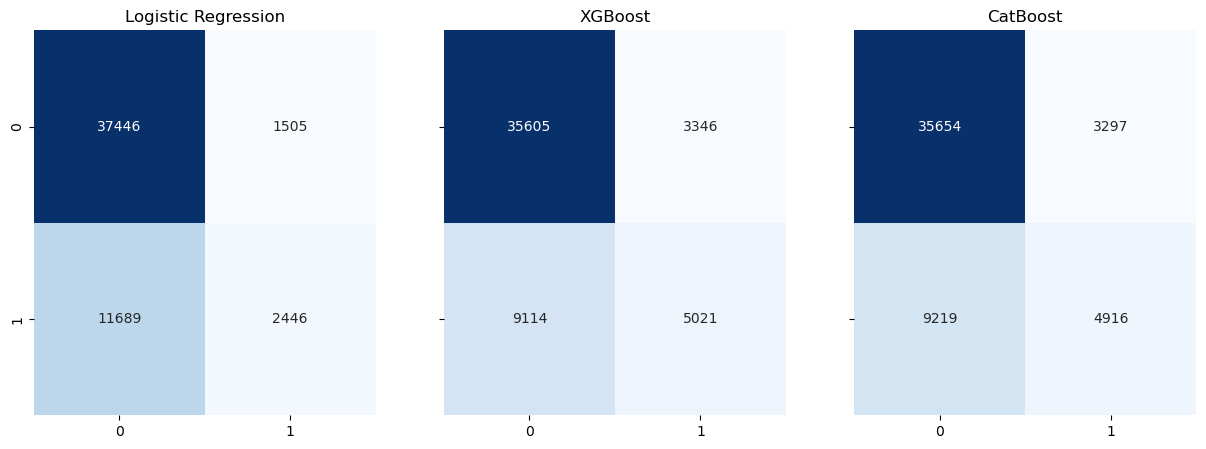

In [23]:
#Combines all of the confuision matrixs into a single visual.
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.heatmap(logistic_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Logistic Regression")

sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("XGBoost")

# Model 3
sns.heatmap(catboost_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[2])
axes[2].set_title("CatBoost")

plt.show()